# Simulating Chemotaxis Receptors

## Maxim Zewe, 2023-2024
## AMOLF, the Netherlands

-----

This code is supplementary to the thesis 'The Ising on the Cake: Mapping the Ising Model to an Effective MWC Description of Chemoreceptor Activity', written in partial fulfilment towards the MSc Physics \& Astronomy at University of Amsterdam and Vrije Universiteit Amsterdam during the academic year 2023-2024 at AMOLF in Amsterdam, the Netherlands.

### Preliminaries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import numba
from numba import jit
from numba.typed import List
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [2]:
# define some colours to use throughout for plotting
my_red = '#CD5C5C'
my_blue = '#5D8AA8'
my_yellow = '#ED9121'
my_bright_yellow = '#FFBF00'
my_orange = '#FFA812'
my_green = '#228B22'
my_bright_green = '#4CBB17'
my_grey = '#7393B3'
my_pink = '#FAA0A0'

colormap = matplotlib.colormaps.get_cmap('coolwarm')
colormap_aux = matplotlib.colormaps.get_cmap('tab10')
colormap_viridis = matplotlib.colormaps.get_cmap('viridis')
colormap_inferno = matplotlib.colormaps.get_cmap('inferno')
colormap_greens = matplotlib.colormaps.get_cmap('Greens')

In [3]:
def bs_ci(x,y,Nbs,alpha=0.05):
    '''
    Performs bootstrapping to obtain confidence intervals on the sample mean.
   
    Parameters
    ----------
    x: ndarray
        1-D array containing of independent variable
    y: ndarray
        2-D array containing Ns samples of the dependent variable for each x
    Nbs: int
        number of bootstrapping samples
    alpha: float, optional
        significance level. Default is 0.05
       
    Returns
    ---------
    lb, ub: ndarray
        lower and upper bounds, resp., extracted from bootstrapped
        distribution. 1-D arrays of size x.size
    bs_means: ndarray
        1-D array of the Nbs bootstrapped means
    '''
    # extract how many samples there are and at how many instances
    Ns = y[:,0].size
   
    # set up bootstrapping procedure
    bs_means = np.zeros((Nbs,x.size),dtype='float64')
   
    for n in range(Nbs):
        # resample from original data
        idx = np.random.choice(np.arange(Ns),size=Ns,replace=True)
        bs_sample = y[idx]
        bs_means[n] = np.mean(bs_sample,axis=0)
       
    # extract confidence interval from bootstrapped distribution
    lb = np.percentile(bs_means,100*alpha/2,axis=0)
    ub = np.percentile(bs_means,100*(1-alpha/2),axis=0)
   
    return lb, ub, bs_means

def bs_fitting(x,y,func,Nbs,alpha=0.05,bounds=(-np.inf,np.inf),maxfev=2000):
    '''
    Performs bootstrapping to obtain confidence intervals on fitting parameters.
   
    Parameters
    ----------
    x: ndarray
        1-D array containing of independent variable
    y: ndarray
        Ns-D array containing Ns samples of the dependent variable
    func: func. object
        function used for fitting, i.e., mean(y) = func(x)
    Nbs: int
        number of bootstrapping samples
    alpha: float, optional
        significance level. Default is 0.05
       
    Returns
    ---------
    mean_parms: ndarray
        fitting parameters from the original samples
    lb, ub: ndarray
        lower and upper bounds, resp., extracted from bootstrapped
        distribution. Same dimension as mean_parms
    bs_parms: ndarray
        bootstrapped fitting parameters. Shape is (no. parameters,Nbs)
    '''
    # extract how many samples there are
    Ns = y[:,0].size
   
    # find the mean fitting parameters from the data
    mean_parms,_ = curve_fit(func,x,np.mean(y,axis=0),bounds=bounds)
   
    # set up bootstrapping procedure
    bs_parms = np.zeros((mean_parms.size,Nbs),dtype='float64')
   
    for n in range(Nbs):
        # resample from original data
        idx = np.random.choice(np.arange(Ns),size=Ns,replace=True)
        bs_sample = y[idx]

        # fit to bootstrap sample
        bs_parms[:,n],_ = curve_fit(func,x,np.mean(bs_sample,axis=0),bounds=bounds,maxfev=maxfev)
       
    # extract confidence interval from bootstrapped distribution
    lb = np.percentile(bs_parms,100*alpha/2,axis=1)
    ub = np.percentile(bs_parms,100*(1-alpha/2),axis=1)
   
    return mean_parms, lb, ub, bs_parms

## Nonadaptive MWC model

### Main functions

In [4]:
@numba.jit(nopython=True)
def mwc_simulator(Ns,tf,tc,k_act=50,c0=100,cf=90,N=6,Ki=18,Ka=2900):
    '''
    Simulates a kinetic, non-adaptive MWC model using Gillespie's algorithm. Runs in Numba's
    nopython mode.
    
    Parameters
    ----------
    Ns: int
        number of samples
    tf: float
        final time of the simulation. By default, unit is s
    tc: float
        time at which the concentration changes
    k_act: float, optional
        sets time scale of (de)activation kinetics. Default is 50
    c0: float, optional
        baseline concentration in microM. Default is 100 microM
    cf: float, optional
        concentration after the step change in microM. Default is 90 microM
    N: float, optional
        number of receptors per MWC cluster. Default is 6
    Ki, Ka: float, optional
        dissocation constants for inactive and active state, respectively, in microM.
        Defaults are 18 and 2900 microM, respectively.
        
    Returns
    ---------
    ensemble: typed List
        contains the ensemble of Ns activities
    all_tau: typed List
        contains the ensemble of Ns waiting time traces
    
    '''
    
    ensemble = List() # use typed lists, because nested lists will be deprecated
    all_tau = List()
    
    # simulate the process Ns times
    for s in range(Ns):
        # initialisation
        act = np.random.choice(np.array([0.,1.]),size=1)
        tau = np.zeros(1,dtype='float64')
        
        eps0 = -N*np.log((1+c0/Ki)/(1+c0/Ka)) # baseline energy
        time = 0 # to keep track of the time
        switch_bool = False # checks whether the concentration has been changed yet
        
        # set rates
        F = 0. # free-energy difference at baseline
        k_deact = k_act # at baseline, equally likely to be active or inactive
        
        # each realisation runs until tf plus one step (which we ignore later on)
        while time <= tf:
            # set rates
            if act[-1] == 0: # state will activate
                rate = k_act
                event = 1.
            else: # state will deactivate
                rate = k_deact
                event = -1.
                
            # determine waiting time until the next event
            u = np.random.uniform(0,1)
            time += -np.log(u)/rate
            
            # if has passed tc: reset the system to the time of the concentration change
            if time > tc and switch_bool == False:
                # time needed to advance from last time step to tc
                advance = tc-(time + np.log(u)/rate)
                
                # update rates
                F = N*np.log((1+cf/Ki)/(1+cf/Ka)) + eps0
                k_deact = k_act*np.exp(F) # from detailed balance
                
                if act[-1] == 0: # state will activate
                    rate = k_act
                    event = 1.
                else: # state will deactivate
                    rate = k_deact
                    event = -1.
                    
                # determine waiting time until next event
                u = np.random.uniform(0,1)
                time = tc-np.log(u)/rate
                
                # update time and state and the switch boolean
                tau = np.append(tau,advance-np.log(u)/rate)
                act = np.append(act,act[-1]+event)
                switch_bool = True
                
            # most cases: just save waiting time and new state
            else:
                tau = np.append(tau,-np.log(u)/rate)
                act = np.append(act,act[-1] + event)
                
        # store results
        ensemble.append(act)
        all_tau.append(tau)
        
    return ensemble, all_tau

@numba.jit(nopython=True)
def sampler(ensemble,all_tau,Ns,tf,st):
    '''
    Samples the time series of an ensemble defined by waiting times at regular time points.
    Runs in Numba's nopython mode.
    
    Parameters
    ----------
    ensemble: typed List
        contains Ns realisations over time
    all_tau: typed List
        contains the waiting times for each realisation
    Ns: int
        number of realisations
    tf: float
        final time of the simulation of the ensemble
    st: float
        sampling time
    
    Returns
    ----------
    all_samples: ndarray
        contains the sampled version of each realisation from 0 to tf. Has shape (Ns,int(tf/st) + 1)
    t_grid: ndarray
        regularly spaced grid of time points from 0 to tf at which the samples have been taken
    
    '''
    
    # arrays to save results
    all_samples = np.zeros((Ns,int(tf/st)+1),dtype='float64')
    t_grid = np.linspace(0,tf,int(tf/st)+1)
    
    # sample each realisation
    for s in range(Ns):
        # time of the realisation
        time_r = np.cumsum(all_tau[s])
        
        for n,t_s in enumerate(t_grid):
            # find first instance where the sampling time is below the waiting time
            idx = np.argmax(t_s < time_r)
            
            # store the value of the realisation before the sampling time crosses the event time
            all_samples[s,n] = ensemble[s][idx-1]
            
    return all_samples, t_grid

In [5]:
def pA(c,N,c0=100,Ki=18,Ka=2900):
    '''
    Returns the probability that an MWC cluster is active at equilibrium.
    
    Parameters
    ----------
    c: ndarray
        concentration in microM
    N: ndarray
        number of receptors per cluster
    c0: float
        baseline concentration in microM. Default is 100 microM
    Ki, Ka: float
        dissocation constants of the inactive and active state, respectively.
        Defaults are 18 and 2900 microM, respectively
        
    Returns
    ----------
    pA: ndarray
        probability that the cluster is active
        
    '''
    eps0 = -N*np.log((1+c0/Ki)/(1+c0/Ka))
    F = N*np.log((1+c/Ki)/(1+c/Ka)) + eps0
    return 1/(1+np.exp(F))

In [6]:
# check how fast these functions are
tf = 25
tc = 20
Ns = 10**3
%timeit mwc_simulator(Ns,tf,tc)

ensemble, all_tau = mwc_simulator(Ns,tf,tc)

st = 0.1

%timeit sampler(ensemble,all_tau,Ns,tf,st)

1.01 s ± 30.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
394 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Verification

/tmp/ipykernel_2972345/4102436535.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


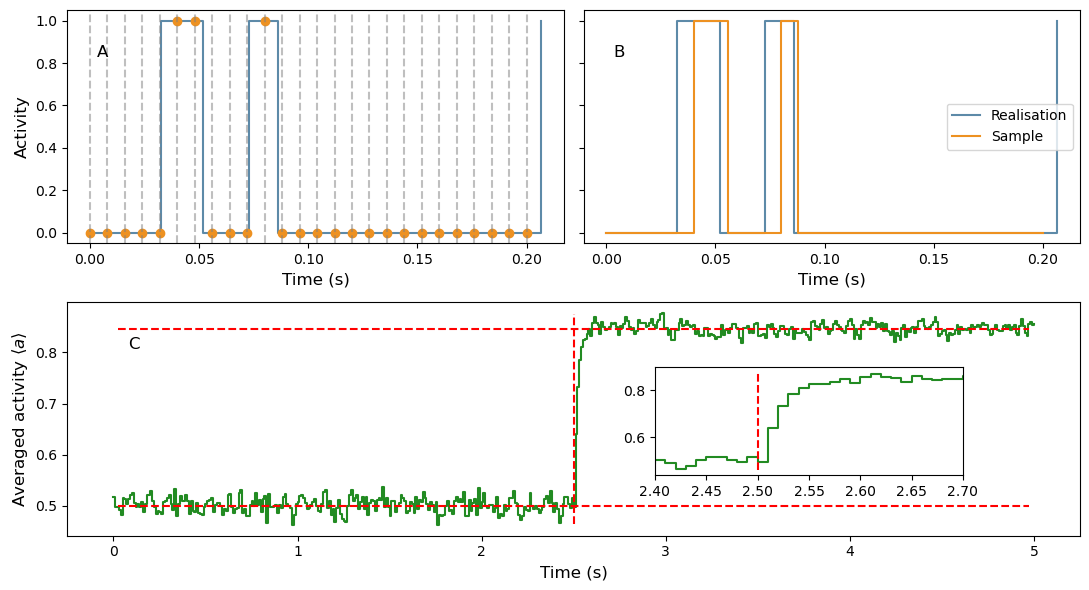

In [7]:
# preparation
fig_sampling = plt.figure(figsize=(11,6))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0,:1])
ax2 = plt.subplot(gs[0,1:],sharey=ax1)
ax3 = plt.subplot(gs[1,:])

# inset for the third plot
left, bottom, width, height = [0.6, 0.20, 0.28, 0.18]
axx = fig_sampling.add_axes([left, bottom, width, height])

# parameters for showing how sampling works
Ns = 1
tf = 0.2
tc = tf + 1
st = tf/25

ensemble, all_tau = mwc_simulator(Ns,tf,tc)
all_samples, t_grid = sampler(ensemble,all_tau,Ns,tf,st)

# show actual realisation and the sampling comb
for n in range(Ns):
    ax1.step(np.cumsum(all_tau[n]),ensemble[n],where='post',color=my_blue)
    ax1.plot(t_grid,all_samples[n],'o',color=my_yellow)
    
for t in t_grid:
    ax1.axvline(x=t,ls='--',color='grey',alpha=0.5)

# show the resulting sample    
ax2.step(np.cumsum(all_tau[0]),ensemble[0],where='post',color=my_blue,label='Realisation')
ax2.step(t_grid,all_samples[0],where='post',color=my_yellow,label='Sample')

ax2.legend(fontsize=10)
plt.setp(ax2.get_yticklabels(), visible=False)

# show a representative time series of the average
Ns = 1000
tf = 5
tc = 2.5
c0 = 100
cf = 70
st = 0.01

ensemble, all_tau = mwc_simulator(Ns,tf,tc,cf=cf)
all_samples, t_grid = sampler(ensemble,all_tau,Ns,tf,st)

# for n in range(0,Ns,100):
#     ax3.step(np.cumsum(all_tau[n]),ensemble[n],where='post',color='grey',alpha=0.1)
    
ax3.step(t_grid,np.mean(all_samples,axis=0),where='post',color=my_green)
ax3.axvline(x=tc,ymin=0.05,ymax=0.95,ls='--',color='r')
ax3.axhline(y=pA(c0,6),xmin=0.05,xmax=0.95,ls='--',color='r')
ax3.axhline(y=pA(cf,6),xmin=0.05,xmax=0.95,ls='--',color='r')

axx.step(t_grid,np.mean(all_samples,axis=0),where='post',color=my_green)
axx.axvline(x=tc,ymin=0.05,ymax=0.95,ls='--',color='r')
axx.set_xlim(tc-0.1,tc+0.2)

# further formatting
letter_list = ['A','B','C']
for i,ax in enumerate((ax1,ax2,ax3)):
    ax.set_xlabel('Time (s)',size=12)
    ax.text(0.06,0.8,letter_list[i],size=12,transform = ax.transAxes)
    
ax1.set_ylabel('Activity',size=12)
ax3.set_ylabel(r'Averaged activity $\langle a \rangle$',size=12)

plt.tight_layout()
# fig_sampling.savefig('Figures/sampling.pdf')
plt.show()

### DRC

In [7]:
def drc(Ns,tf,tc,st,c_arr,c0=100,N=6,Nbs=1000):
    '''
    Finds the dose-response curve for the MWC model.
    
    Parameters
    ----------
    Ns: int
        number of realisations
    tf: float
        final time of the simulations in s
    tc: float
        time in s at which the concentration is changed
    st: float
        sampling period in s
    c_arr: ndarray
        array of final concentrations in microM
    c0: float
        initial concentration. Default is 100 microM
    N: float
        number of receptors per MWC cluster
    Nbs: int, optional
        number of bootstrapping samples. Default is 1000
    
    Returns
    ----------
    mean_delta_a: ndarray
        ensemble-averaged response, defined as the difference between the pre- 
        and post-stimulus activity. Of same length as c_arr.
    lb, ub: ndarray
        lower and upper bound on the mean response, respectively. Obtained through
        bootstrapping with a 95% confidence interval
        
    '''
    all_delta_a = np.zeros((Ns,c_arr.size),dtype='float64')
    mean_delta_a = np.zeros(c_arr.size,dtype='float64')
    
    for k,cf in enumerate(c_arr):
        # obtain an ensemble and sample
        ensemble, all_tau = mwc_simulator(Ns,tf,tc,c0=c0,cf=cf,N=N)
        all_samples, t_grid = sampler(ensemble,all_tau,Ns,tf,st)
        
        # compute response 
        all_delta_a[:,k] = all_samples[:,-1]-all_samples[:,int(tc//st)-1]
        mean_delta_a[k] = np.mean(all_delta_a[:,k])
        
    # get confidence interval from bootstrapping
    lb, ub, bs_means = bs_ci(c_arr,all_delta_a,Nbs,alpha=0.05)
        
    return mean_delta_a, lb, ub, all_delta_a

# Hill function used for fitting
def hill_function(c,nH,d_max):
    c0 = 100
    return 2*d_max*(c**nH/(c0**nH + c**nH) - 0.5)

In [9]:
Ns = 10**3
tf = 4
tc = 2
st = 0.1
c_arr = np.array([70,80,100,120])

%timeit drc(Ns,tf,tc,st,c_arr)

540 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


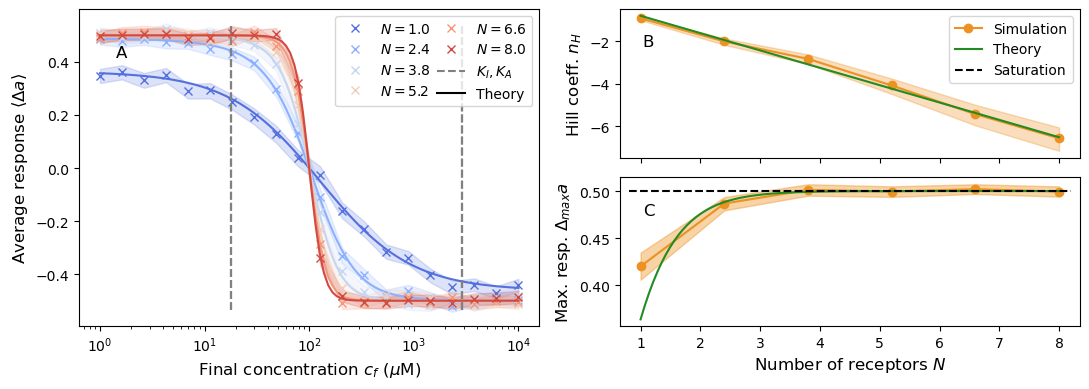

In [10]:
# preparation
fig_drc_mwc = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:,:1])
ax2 = plt.subplot(gs[0,1:])
ax3 = plt.subplot(gs[1,1:],sharex=ax2)

# parameters
N_arr = np.linspace(1,8,6)
#Ns = 5000
Nbs = 1500
Ns = 2000
tf = 4
tc = 2
st = 0.1
c_arr = np.logspace(0.,4.,20)
c_arr_plt = np.logspace(0.,4.,100)

all_mean_delta_a = np.zeros((c_arr.size,N_arr.size),dtype='float64')
all_lb = np.zeros_like(all_mean_delta_a)
all_ub = np.zeros_like(all_mean_delta_a)
all_bs_parms = np.zeros((2,Nbs,N_arr.size),dtype='float64')

hill_parms = np.zeros((2,N_arr.size),dtype='float64') # to store results
hill_lb = np.zeros_like(hill_parms)
hill_ub = np.zeros_like(hill_parms)
handles = []

for n,N in enumerate(N_arr):
    # obtain drc
    mean_delta_a, lb, ub, all_delta_a = drc(Ns,tf,tc,st,c_arr,N=N,Nbs=Nbs)
    all_mean_delta_a[:,n] = mean_delta_a
    all_lb[:,n] = lb
    all_ub[:,n] = ub
    theoretical_drc = pA(c_arr_plt,N) - pA(100,N)
    
    # fit Hill function and perform bootstrapping
    hill_popt, lb_parms, ub_parms, bs_parms = bs_fitting(c_arr,all_delta_a,hill_function,Nbs,alpha=0.05,bounds=([-np.inf,0],[0,np.inf]))
    hill_parms[:,n] = hill_popt
    hill_lb[:,n] = lb_parms
    hill_ub[:,n] = ub_parms
    all_bs_parms[:,:,n] = bs_parms
    
    # results
    color = colormap((n+0.5)/N_arr.size)
    
    # theoretical result
    ax1.semilogx(c_arr,mean_delta_a,'x',label=f'$N={N}$',color=color)
    ax1.fill_between(c_arr,lb,ub,color=color,alpha=0.2)
    ax1.semilogx(c_arr_plt,theoretical_drc,color=color)
    ax1.axvline(x=18,ymin=0.05,ymax=0.95,ls='--',color='grey',alpha=0.5) # Ki
    ax1.axvline(x=2900,ymin=0.05,ymax=0.95,ls='--',color='grey',alpha=0.5) # Ka
    
    handles.append(Line2D([],[],color=color,marker='x',linestyle='None',label=f'$N={np.round(N,1)}$'))
    
# formatting
handles.append(Line2D([], [], color='grey', linestyle='--', label=r'$K_I,K_A$'))
handles.append(Line2D([], [], color='k', label=r'Theory'))

ax1.legend(handles=handles,fontsize=10,ncol=2,columnspacing=0.5)
ax1.set_ylabel(r'Average response $\langle \Delta a \rangle$',size=12)
ax1.set_xlabel(r'Final concentration $c_f$ ($\mu$M)',size=12)
ax1.text(0.08,0.85,'A',size=12,transform = ax1.transAxes)

# fitting parameters
th_nH = N_arr*100*(18-2900)/((18+100)*(2900+100)) # theoretical result

ax2.plot(N_arr,hill_parms[0],'-o',label='Simulation',color=my_yellow)
ax2.fill_between(N_arr,hill_lb[0],hill_ub[0],color=my_yellow,alpha=0.3)
ax2.plot(N_arr,th_nH,label='Theory',color=my_green)
ax2.set_ylabel(r'Hill coeff. $n_H$',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

# legend
handles = []
handles.append(Line2D([],[],color=my_yellow,marker='o',label=f'Simulation'))
handles.append(Line2D([], [], color=my_green, label=r'Theory'))
handles.append(Line2D([], [], color='k', linestyle='--', label=r'Saturation'))
ax2.legend(handles=handles,fontsize=10)

N_arr_plt = np.linspace(N_arr[0],N_arr[-1],100) # for plotting a smooth curve
th_dmax_a = (1/(1 + ((1 + 100/2900)/(1 + 100/18))**N_arr_plt) - 0.5) # theoretical

ax3.plot(N_arr,hill_parms[1],'-o',color=my_yellow)
ax3.fill_between(N_arr,hill_lb[1],hill_ub[1],color=my_yellow,alpha=0.4)
ax3.plot(N_arr_plt,th_dmax_a,color=my_green)
ax3.axhline(y=0.5,xmin=0.02,xmax=0.98,ls='--',color='k',label='Saturation')
ax3.set_ylabel(r'Max. resp. $\Delta_{max} a$',size=12)
ax3.set_xlabel(r'Number of receptors $N$',size=12)

letter_list = ['B','C'] # for formatting
for i,ax in enumerate((ax2,ax3)):
    ax.text(0.05,0.75,letter_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()

plt.show()

In [11]:
#fig_drc_mwc.savefig('Figures/drc_mwc.pdf')

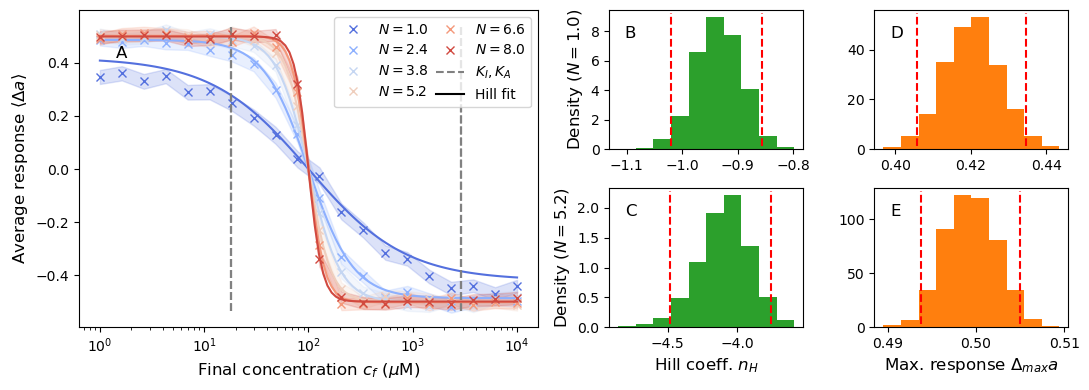

In [12]:
# preparation
fig_drc_mwc_si = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[:,:2])
ax2 = plt.subplot(gs[0,2])
ax3 = plt.subplot(gs[1,2])
ax4 = plt.subplot(gs[0,3])
ax5 = plt.subplot(gs[1,3])

# show data and Hill functions
handles = []
for n,N in enumerate(N_arr):
    color = colormap((n+0.5)/N_arr.size)
    
    # Hill function
    ax1.semilogx(c_arr,all_mean_delta_a[:,n],'x',color=color)
    ax1.fill_between(c_arr,all_lb[:,n],all_ub[:,n],color=color,alpha=0.2)
    ax1.semilogx(c_arr_plt,hill_function(c_arr_plt,*hill_parms[:,n]),color=color)
    ax1.axvline(x=18,ymin=0.05,ymax=0.95,ls='--',color='grey',alpha=0.5) # Ki
    ax1.axvline(x=2900,ymin=0.05,ymax=0.95,ls='--',color='grey',alpha=0.5) # Ka
    
    handles.append(Line2D([],[],color=color,marker='x',linestyle='None',label=f'$N={np.round(N,1)}$'))
    
# formatting
handles.append(Line2D([], [], color='grey', linestyle='--', label=r'$K_I,K_A$'))
handles.append(Line2D([], [], color='k', label=r'Hill fit'))

ax1.legend(handles=handles,fontsize=10,ncol=2,columnspacing=0.5,loc='upper right')
ax1.set_ylabel(r'Average response $\langle \Delta a \rangle$',size=12)
ax1.set_xlabel(r'Final concentration $c_f$ ($\mu$M)',size=12)
ax1.text(0.08,0.85,'A',size=12,transform = ax1.transAxes)

for i,ax in enumerate((ax2,ax3)):
    ax.hist(all_bs_parms[0,:,3*i],density=True,color=colormap_aux(2))
    ax.set_ylabel(f'Density ($N={np.round(N_arr[3*i],1)}$)',size=12)
    ax.axvline(hill_lb[0,3*i],ymin=0.02,ymax=0.98,color='r',ls='--')
    ax.axvline(hill_ub[0,3*i],ymin=0.02,ymax=0.98,color='r',ls='--')

ax3.set_xlabel(r'Hill coeff. $n_H$',fontsize=12)

for i,ax in enumerate((ax4,ax5)):
    ax.hist(all_bs_parms[1,:,3*i],density=True,color=colormap_aux(1))
    ax.axvline(hill_lb[1,3*i],ymin=0.02,ymax=0.98,color='r',ls='--')
    ax.axvline(hill_ub[1,3*i],ymin=0.02,ymax=0.98,color='r',ls='--')
    
ax5.set_xlabel(r'Max. response $\Delta_{max}a$',fontsize=12)

text_list = ['B','C','D','E']

for i,ax in enumerate((ax2,ax3,ax4,ax5)):
    ax.text(0.08,0.8,text_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()
plt.show()

In [13]:
# fig_drc_mwc_si.savefig('Figures/drc_mwc_si.pdf')

### Response kernel

/home/ipausers/zewe/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_2972345/2826268299.py:3: RuntimeWarning: overflow encountered in exp
  return G*(1-np.exp(-t/tau_r))


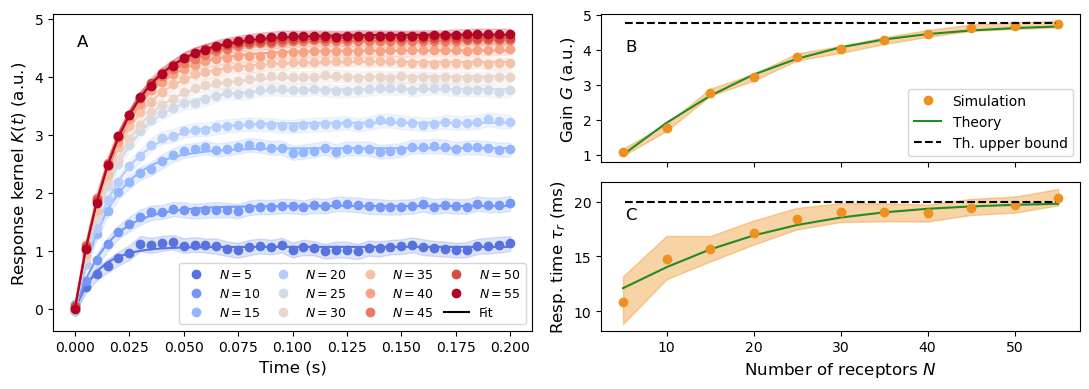

In [14]:
# nonadaptive response kernel
def rk_star(t,G,tau_r):
    return G*(1-np.exp(-t/tau_r))

# preparation
fig_rk_mwc_na = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1],sharex=ax2)

N_arr = np.arange(5,56,5)
Ns = 10**4
tf = 3.2
tc = 3.
st = 0.005
k_act = 50
c0 = 100
cf = 90
Nbs = 1000

rk_parms = np.zeros((2,N_arr.size),dtype='float64')
rk_lb = np.zeros_like(rk_parms)
rk_ub = np.zeros_like(rk_parms)

handles = []

for n,N in enumerate(N_arr):
    # obtain ensemble and sample
    ensemble, all_tau = mwc_simulator(Ns,tf,tc,c0=c0,cf=cf,k_act=k_act,N=N)
    all_samples, t_grid = sampler(ensemble,all_tau,Ns,tf,st)
    
    # find response kernel
    all_responses = ((all_samples[:,t_grid >= tc].T - all_samples[:,int(tc/st)-1].T)/np.log(c0/cf)).T
    response = np.mean(all_responses,axis=0)
    time_s = t_grid[t_grid >= tc] - tc
    
    # get confidence interval from bootstrapping
    lb, ub, bs_means = bs_ci(time_s,all_responses,Nbs,alpha=0.05)
    
    # fitting and bootstrappin'
    popt, lb_parms, ub_parms, bs_parms = bs_fitting(time_s,all_responses,rk_star,Nbs,alpha=0.05)
    popt,_ = curve_fit(rk_star,time_s,response)
    rk_parms[:,n] = popt
    rk_lb[:,n] = lb_parms
    rk_ub[:,n] = ub_parms
    
    color=colormap((n+1)/N_arr.size)
    ax1.plot(time_s,response,'o',color=color)
    ax1.fill_between(time_s,lb,ub,color=color,alpha=0.2)
    ax1.plot(time_s,rk_star(time_s,*popt),color=color)
    handles.append(Line2D([],[],color=color,marker='o',linestyle='None',label=f'$N={N}$'))
    
# formatting
handles.append(Line2D([],[],color='k',label='Fit'))
ax1.legend(handles=handles,loc='lower right',fontsize=9,ncol=4,columnspacing=0.8)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel(r'Response kernel $K(t)$ (a.u.)',size=12) 
ax1.text(0.05,0.9,'A',size=12,transform = ax1.transAxes)

ax2.plot(N_arr,(pA(cf,N_arr)-0.5)/np.log(c0/cf),color=my_green,label='Theory')
ax2.plot(N_arr,rk_parms[0,:],'o',color=my_yellow,label='Fitted')
ax2.fill_between(N_arr,rk_lb[0,:],rk_ub[0,:],color=my_yellow,alpha=0.4)
ax2.axhline(y=0.5/np.log(c0/cf),xmin=0.05,xmax=0.95,ls='--',color='k')

handles = []
handles.append(Line2D([],[],color=my_yellow,marker='o',linestyle='None',label='Simulation'))
handles.append(Line2D([],[],color=my_green,label=f'Theory'))
handles.append(Line2D([],[],color='k',linestyle='--',label='Th. upper bound'))

ax2.legend(handles=handles,loc='lower right',fontsize=10)
ax2.set_ylabel(r'Gain $G$ (a.u.)',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3.plot(N_arr,pA(cf,N_arr)/k_act*1000,color=my_green)
ax3.plot(N_arr,rk_parms[1,:]*1000,'o',color=my_yellow)
ax3.fill_between(N_arr,rk_lb[1,:]*1000,rk_ub[1,:]*1000,color=my_yellow,alpha=0.4)
ax3.axhline(y=1000/k_act,xmin=0.05,xmax=0.95,ls='--',color='k')

ax3.set_xlabel(r'Number of receptors $N$',size=12)
ax3.set_ylabel(r'Resp. time $\tau_r$ (ms)',size=12)

letter_list = ['B','C'] # for formatting
for i,ax in enumerate((ax2,ax3)):
    ax.text(0.05,0.75,letter_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()

plt.show()

In [15]:
fig_rk_mwc_na.savefig('Figures/rk_mwc_na.pdf')

### Noise kernel

In [8]:
@numba.jit(nopython=True)
def cell_activity(Ns,Nc,tf,tc,st,N=6,cf=90):
    '''
    Finds an ensemble of single-cell activities, i.e., activities averaged over the cell's clusters.
    Runs on Numba's nopython mode.

    Parameters
    ----------
    Ns: int
        number of samples, i.e., the number of cells in the ensemble
    Nc: int
        number of clusters per cell
    tf: float
        final time of the underlying Gillepsie simulation
    tc: float
        time at which the concentration is changed
    st: float
        sampling time period
    N: float, optional
        number of receptors per cluster. By default 6
    cf: float, optional
        final concentration. Default is 90 microM

    Returns
    ----------
    all_cell_act: ndarray
        time-sampled traces of the activity for each cell. Shape is (Ns,int(tf/st) + 1)
    t_grid: ndarray
        times at which the time series are sampled, length int(tf/st) + 1
       
    '''
   
    # array to save result
    all_cell_act = np.zeros((Ns,int(tf/st) + 1),dtype='float64')
   
    for s in range(Ns):
        # obtain a single-cell realisation
        ensemble, all_tau = mwc_simulator(Nc,tf,tc,cf=cf,N=N)
        all_samples, t_grid = sampler(ensemble,all_tau,Nc,tf,st)
        all_cell_act[s,:] = np.sum(all_samples,axis=0)/Nc # average over the cell's clusters
   
    return all_cell_act, t_grid

def autocorr(ensemble,t_grid,co,Nbs=1000,alpha=0.05):
    '''
    Computes the autocorrelation of an ensemble over time.
    
    Parameters
    ----------
    ensemble: ndarray
        contains samples of the realisations over time
    t_grid: ndarray
        regularly spaced times at which the realisations have been sampled
    co: int
        cut-off point where time is reset to zero to ensure equilibrium
    Nbs: int, optional
        number of bootstrapping samples. Default is zero
    alpha: float, optional
        significance level. Default is 0.05
        
    Returns
    ----------
    obs_auto_corr: ndarray
        autocorrelation over time for the ensemble
    lb, ub: ndarray
        lower and upper bounds, resp., extracted from bootstrapped
        distribution. Same dimension as obs_auto_corr
    time_s: ndarray
        time shifted such that time is zero at the cut-off point
    all_auto_corr: ndarray
        contains the Nbs bootstrapped autocorrelations
    '''
    # obtain relevant ensemble averages
    av_prod = np.mean(ensemble[:,co:].T*ensemble[:,co].T,axis=1)
    prod_av = np.mean(ensemble[:,co:],axis=0)*np.mean(ensemble[:,co])
    
    obs_auto_corr = av_prod - prod_av
    
    # shift time
    time_s = t_grid[co:]-t_grid[co]
    
    # perform bootstrapping to get confidence interval
    Ns = ensemble[:,0].size
    t_size = time_s.size
    all_auto_corr = np.zeros((Nbs,t_size),dtype='float64')
    
    for n in range(Nbs):
        # resample the original data
        idx = np.random.choice(np.arange(Ns),size=Ns,replace=True)
        bs_sample = ensemble[idx]
        
        # compute the autocorrelation for the bootstrapping sample
        av_prod = np.mean(bs_sample[:,co:].T*bs_sample[:,co].T,axis=1)
        prod_av = np.mean(bs_sample[:,co:],axis=0)*np.mean(bs_sample[:,co])
        all_auto_corr[n,:] = av_prod - prod_av 
        
    # extract confidence interval from bootstrapped distribution
    lb = np.percentile(all_auto_corr,100*alpha/2,axis=0)
    ub = np.percentile(all_auto_corr,100*(1-alpha/2),axis=0)
   
    return obs_auto_corr, lb, ub, time_s, all_auto_corr

/tmp/ipykernel_2972345/3373015341.py:3: RuntimeWarning: overflow encountered in exp
  return sigma_n**2*np.exp(-np.abs(t)/tau_n)


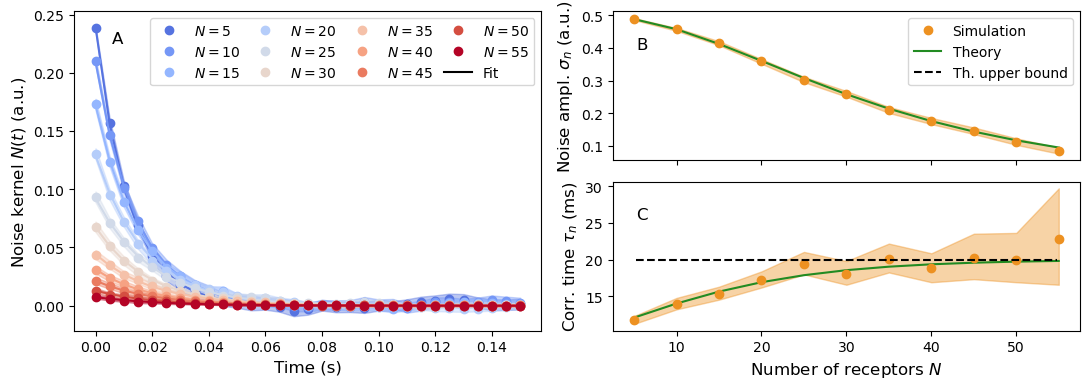

In [17]:
# noise kernel
def nk(t,sigma_n,tau_n):
    return sigma_n**2*np.exp(-np.abs(t)/tau_n)

# preparation
fig_nk_mwc_na = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1],sharex=ax2)

N_arr = np.arange(5,56,5)
Ns = 10**4
Nc = 1
tf = 1.5
tc = 0.0
st = 0.005
co = int(0.9*tf/st)
cf = 90
Nbs = 1000
alpha = 0.05

nk_parms = np.zeros((2,N_arr.size),dtype='float64')
nk_lb = np.zeros_like(nk_parms)
nk_ub = np.zeros_like(nk_parms)

handles = []

for n,N in enumerate(N_arr):
    # obtain ensemble and sample
    cell_ensemble, t_grid = cell_activity(Ns,Nc,tf,tc,st,N=N,cf=cf)
    auto_corr, lb, ub, time_s, all_auto_corr = autocorr(cell_ensemble,t_grid,co,Nbs=Nbs,alpha=alpha)
        
    # fittin' and bootstrappin'
    popt,_ = curve_fit(nk,time_s,auto_corr)
    nk_parms[:,n] = popt
    bs_parms = np.zeros((popt.size,Nbs),dtype='float64')
   
    for nbs in range(Nbs):
        bs_parms[:,nbs],_ = curve_fit(nk,time_s,all_auto_corr[nbs,:])
       
    # extract confidence interval from bootstrapped distribution
    nk_lb[:,n] = np.percentile(bs_parms,100*alpha/2,axis=1)
    nk_ub[:,n] = np.percentile(bs_parms,100*(1-alpha/2),axis=1)
    
    # show results
    color = colormap((n+1)/N_arr.size)
    ax1.plot(time_s,auto_corr,'o',color=color)
    ax1.fill_between(time_s,lb,ub,color=color,alpha=0.4)
    ax1.plot(time_s,nk(time_s,*popt),color=color)
    handles.append(Line2D([],[],color=color,marker='o',linestyle='None',label=f'$N={N}$'))
    
# formatting
handles.append(Line2D([],[],color='k',label='Fit'))
ax1.legend(handles=handles,loc='upper right',fontsize=10,ncol=4,columnspacing=0.8)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel(r'Noise kernel $N(t)$ (a.u.)',size=12) 
ax1.text(0.08,0.9,'A',size=12,transform = ax1.transAxes)

handles = []
handles.append(Line2D([],[],color=my_yellow,marker='o',linestyle='None',label='Simulation'))
handles.append(Line2D([],[],color=my_green,label=f'Theory'))
handles.append(Line2D([],[],color='k',linestyle='--',label='Th. upper bound'))

ax2.plot(N_arr,np.sqrt(pA(cf,N_arr)*(1-pA(cf,N_arr))),color=my_green,label='Theory')
ax2.plot(N_arr,nk_parms[0,:],'o',color=my_yellow,label='Simulation')
ax2.fill_between(N_arr,nk_lb[0,:],nk_ub[0,:],color=my_yellow,alpha=0.4)
ax2.legend(loc='upper right',handles=handles,fontsize=10)
ax2.set_ylabel(r'Noise ampl. $\sigma_n$ (a.u.)',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3.plot(N_arr,pA(cf,N_arr)/k_act*1000,color=my_green)
ax3.plot(N_arr,nk_parms[1,:]*1000,'o',color=my_yellow)
ax3.fill_between(N_arr,nk_lb[1,:]*1000,nk_ub[1,:]*1000,color=my_yellow,alpha=0.4)
ax3.axhline(y=1000/k_act,xmin=0.05,xmax=0.95,ls='--',color='k')

ax3.set_xlabel(r'Number of receptors $N$',size=12)
ax3.set_ylabel(r'Corr. time $\tau_n$ (ms)',size=12)

letter_list = ['B','C'] # for formatting
for i,ax in enumerate((ax2,ax3)):
    ax.text(0.05,0.75,letter_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()

plt.show()

In [18]:
# fig_nk_mwc_na.savefig('Figures/nk_mwc_na.pdf')

/tmp/ipykernel_2972345/3373015341.py:3: RuntimeWarning: overflow encountered in exp
  return sigma_n**2*np.exp(-np.abs(t)/tau_n)


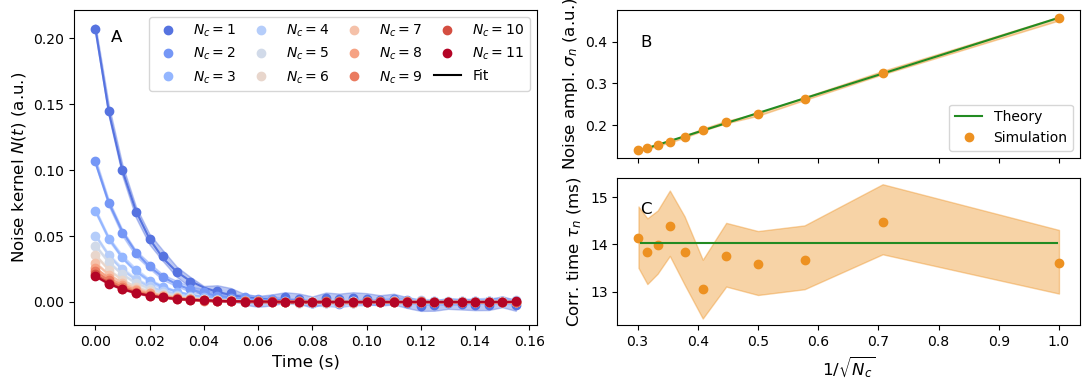

In [19]:
# preparation
fig_nk_mwc_na_si = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1],sharex=ax2)

Nc_arr = np.arange(1,12,1)
Ns = 10**4
N = 10
tf = 3.
tc = 0.0
st = 0.005
co = int(0.95*tf/st)
cf = 90

Nc_nk_parms = np.zeros((2,Nc_arr.size),dtype='float64')
Nc_nk_lb = np.zeros_like(Nc_nk_parms)
Nc_nk_ub = np.zeros_like(Nc_nk_parms)

handles = []

for n,Nc in enumerate(Nc_arr):
    # obtain ensemble and sample
    cell_ensemble, t_grid = cell_activity(Ns,Nc,tf,tc,st,N=N,cf=cf)
    auto_corr, lb, ub, time_s, all_auto_corr = autocorr(cell_ensemble,t_grid,co,Nbs=Nbs,alpha=alpha)
        
    # fittin' and bootstrappin'
    popt,_ = curve_fit(nk,time_s,auto_corr)
    Nc_nk_parms[:,n] = popt
    bs_parms = np.zeros((popt.size,Nbs),dtype='float64')
   
    for nbs in range(Nbs):
        bs_parms[:,nbs],_ = curve_fit(nk,time_s,all_auto_corr[nbs,:])
       
    # extract confidence interval from bootstrapped distribution
    Nc_nk_lb[:,n] = np.percentile(bs_parms,100*alpha/2,axis=1)
    Nc_nk_ub[:,n] = np.percentile(bs_parms,100*(1-alpha/2),axis=1)
    
    # show results
    color = colormap((n+1)/N_arr.size)
    ax1.plot(time_s,auto_corr,'o',color=color)
    ax1.fill_between(time_s,lb,ub,color=color,alpha=0.4)
    ax1.plot(time_s,nk(time_s,*popt),color=color)
    handles.append(Line2D([],[],color=color,marker='o',linestyle='None',label=f'$N_c={Nc}$'))
    
# formatting
handles.append(Line2D([],[],color='k',label='Fit'))
ax1.legend(handles=handles,loc='upper right',fontsize=10,ncol=4,columnspacing=0.8)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel(r'Noise kernel $N(t)$ (a.u.)',size=12) 
ax1.text(0.08,0.9,'A',size=12,transform = ax1.transAxes)

handles = []
handles.append(Line2D([],[],color=my_yellow,marker='o',linestyle='None',label='Simulation'))
handles.append(Line2D([],[],color=my_green,label=f'Theory'))

ax2.plot(1/np.sqrt(Nc_arr),np.sqrt(pA(cf,N)*(1-pA(cf,N))/Nc_arr),color=my_green,label='Theory')
ax2.plot(1/np.sqrt(Nc_arr),Nc_nk_parms[0,:],'o',color=my_yellow,label='Simulation')
ax2.fill_between(1/np.sqrt(Nc_arr),Nc_nk_lb[0,:],Nc_nk_ub[0,:],color=my_yellow,alpha=0.4)
#ax2.axhline(y=0.5/np.log(c0/cf),xmin=0.05,xmax=0.95,ls='--',color=my_red)
ax2.legend(loc='lower right',fontsize=10)
ax2.set_ylabel(r'Noise ampl. $\sigma_n$ (a.u.)',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3.plot(1/np.sqrt(Nc_arr),Nc_nk_parms[1,:]*1000,'o',color=my_yellow)
ax3.fill_between(1/np.sqrt(Nc_arr),Nc_nk_lb[1,:]*1000,Nc_nk_ub[1,:]*1000,color=my_yellow,alpha=0.4)
ax3.axhline(y=pA(cf,N)/k_act*1000,xmin=0.05,xmax=0.95,color=my_green)

ax3.set_xlabel(r'$1/\sqrt{N_c}$',size=12)
ax3.set_ylabel(r'Corr. time $\tau_n$ (ms)',size=12)

letter_list = ['B','C'] # for formatting
for i,ax in enumerate((ax2,ax3)):
    ax.text(0.05,0.75,letter_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()

plt.show()

In [20]:
# fig_nk_mwc_na_si.savefig('Figures/nk_mwc_na_si.pdf')

## Adaptive MWC

### Main functions

In [87]:
@numba.jit(nopython=True)
def multi_dim_sampler(ensemble,all_tau,Ns,tf,st):
    '''
    Samples the time series of an ensemble defined by waiting times at regular time points.
    The ensemble consists of state vectors of length larger than 1. Runs in Numba's nopython mode.
    
    Parameters
    ----------
    ensemble: typed List
        contains Ns realisations over time
    all_tau: typed List
        contains the waiting times for each realisation
    Ns: int
        number of realisations
    tf: float
        final time of the simulation of the ensemble
    st: float
        sampling time
    
    Returns
    ----------
    all_samples: ndarray
        contains the sampled version of each realisation from 0 to tf. Has shape (Ns,int(tf/st) + 1,D),
        where the state is described by D variables
    t_grid: ndarray
        regularly spaced grid of time points from 0 to tf at which the samples have been taken

    '''
    # arrays to save results
    D = len(ensemble[0][0])
    all_samples = np.zeros((Ns,int(tf/st)+1,D),dtype='float64')
        
    t_grid = np.linspace(0,tf,int(tf/st)+1)
    
    # sample each realisation
    for s in range(Ns):
        # time of the realisation
        time_r = np.cumsum(all_tau[s])
        
        for n,t_s in enumerate(t_grid):
            # find first instance where the sampling time is below the waiting time
            idx = np.argmax(t_s < time_r)
            
            # store the value of the realisation before the sampling time crosses the event time
            all_samples[s,n] = ensemble[s][idx-1]
            
    return all_samples, t_grid

In [88]:
# function to draw a biased sample in numba
@numba.jit(nopython=True)
def biased_choice(outcomes,prob,size=1):
    '''
    Numba-analog of np.random.choice().
    
    Parameters
    ----------
    outcomes: ndarray
        array of possible values of the random variable of interest
    prob: ndarray
        array of probabilities corresponding to each outcome
    size: int
        size of the sample. Default is 1
    
    Returns
    ----------
    sample: float
        a sample drawn from outcomes given the probabilities in prob
    '''
    
    return outcomes[np.searchsorted(np.cumsum(prob), np.random.rand(size))]

In [89]:
@numba.jit(nopython=True)
def adaptive_mwc_simulator(Ns,tf,tc,k_act=50,c0=100,cf=90,N=6,Ki=18,Ka=2900,
                          dfm=-2,kR=0.075,kB=0.15):
    '''
    Simulates a kinetic, adaptive MWC model using Gillespie's algorithm. Runs in Numba's
    nopython mode.
    
    Parameters
    ----------
    Ns: int
        number of samples
    tf: float
        final time of the simulation. By default, unit is s
    tc: float
        time at which the concentration changes
    k_act: float, optional
        sets time scale of (de)activation kinetics. Default is 50 per s
    c0: float, optional
        baseline concentration in microM. Default is 100 microM
    cf: float, optional
        concentration after the step change in microM. Default is 90 microM
    N: float, optional
        number of receptors per MWC cluster. Default is 6
    Ki, Ka: float, optional
        dissocation constants for inactive and active state, respectively, in microM.
        Defaults are 18 and 2900 microM, respectively
    dfm: float
        free-energy cost of an additional methyl group. Default is -2 kT
    kR, kB: float
        methylation and demethylation rate, respectively. Defaults are 0.075 
        and 0.15 per s, respectively
        
    Returns
    ---------
    ensemble: typed List
        contains the ensemble of Ns activities and Ns methylation levels
        Note: the methylation level is an integer between 0 and 4*N
    all_tau: typed List
        contains the ensemble of Ns waiting time traces
    
    '''
    # other methylation parameters
    m0 = N/2 # baseline 
    mMax = 4*N # maximum 
    
    # objects to store results
    ensemble = List() # use Numba lists; nested list will be deprecated
    all_tau = List()
    
    rates = np.zeros(2,dtype='float64')
    events = np.zeros((2,2),dtype='float64')
    
    # simulate the process Ns times
    for s in range(Ns):
        # initialise each realisation
        tau = np.array([0.])
        am = np.array([[0.,0.]])
        stack_aux = np.array([[0.,0.]]) # needed later on for stacking
        
        am[0,0] = biased_choice(np.array([0.,1.]),np.array([kB/(kR+kB),kR/(kR+kB)]))[0]
        am[0,1] = mMax/3
        
        # initialise concentration-dependent free energy and time
        Fc = N*np.log((1+c0/Ki)/(1+c0/Ka))
        time = 0
        switch_bool = False # to keep track of concentration switch
        
        # run until the final time
        while time <= tf:
            # calculate free-energy difference
            F = Fc + dfm*(am[-1,1] - m0)

            # set methylation booleans
            m_ceiling = am[-1,1] < mMax
            m_floor = am[-1,1] > 0.
            
            # set rates and possible events
            if am[-1,0] == 0.: # inactive cluster
                rates[0] = k_act # activation
                events[0] = np.array([1.,0.])

                rates[1] = kR*m_ceiling # methylation
                events[1] = np.array([0.,1.])

            else: # active cluster
                rates[0] = k_act*np.exp(F) # deactivation
                events[0] = np.array([-1.,0.])

                rates[1] = kB*m_floor # demethylation
                events[1] = np.array([0.,-1.])

            # determine waiting time until next event
            u = np.random.uniform(0,1)
            time += -np.log(u)/np.sum(rates)

            # condition on which to change concentration
            if time >= tc and not switch_bool:
                # time needed to advance from last time step to tc
                advance = tc-(time + np.log(u)/np.sum(rates))

                # update free energy
                Fc = N*np.log((1+cf/Ki)/(1+cf/Ka))
                F = Fc + dfm*(am[-1,1] - m0)

                # update rates for deactivation (only one that changes)
                if am[-1,0] == 1.:
                    rates[0] = k_act*np.exp(F)

                # determine waiting time until next event
                u = np.random.uniform(0,1)
                time = tc-np.log(u)/np.sum(rates) # reset time to before the transgression

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                e_idx = np.argmax(p < np.cumsum(rates))
                stack_aux[0,0] = am[-1,0] + events[e_idx,0] # for stacking later on; dumb Numba way
                stack_aux[0,1] = am[-1,1] + events[e_idx,1]
                
                # update time and state and the switch boolean
                tau = np.append(tau,advance-np.log(u)/np.sum(rates))
                am = np.vstack((am,stack_aux))
                switch_bool = True

            else: # most cases
                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                e_idx = np.argmax(p < np.cumsum(rates))
                
                stack_aux[0,0] = am[-1,0] + events[e_idx,0] # for stacking later on; dumb Numba way
                stack_aux[0,1] = am[-1,1] + events[e_idx,1]
                
                # save results
                tau = np.append(tau,-np.log(u)/np.sum(rates))
                am = np.vstack((am,stack_aux))
    
        # store the realisation
        all_tau.append(tau)
        ensemble.append(am)
    
    return ensemble, all_tau

def pA_m(c,N,m,c0=100,Ki=18,Ka=2900,dfm=-2):
    '''
    Returns the probability that an adaptive MWC cluster is active at equilibrium.
    
    Parameters
    ----------
    c: ndarray
        concentration in microM
    N: ndarray
        number of receptors per cluster
    m: ndarray
        number of methyl groups bound
    c0: float
        baseline concentration in microM. Default is 100 microM
    Ki, Ka: float
        dissocation constants of the inactive and active state, respectively.
        Defaults are 18 and 2900 microM, respectively
    dfm: float
        free energy due to binding one methyl group. Default is -2kBT
        
    Returns
    ----------
    pA_m: ndarray
        probability that the cluster is active
        
    '''
    m0 = N/2 # baseline methylation
    F = N*np.log((1+c/Ki)/(1+c/Ka)) + dfm*(m-m0)
    return 1/(1+np.exp(F))

In [90]:
Ns = 10**1
tf = 20
tc = 10
cf = 70

%timeit adaptive_mwc_simulator(Ns,tf,tc,cf=cf)

26 ms ± 3.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Response kernel

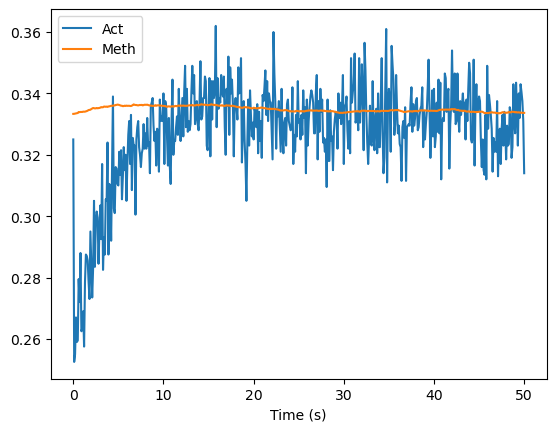

In [381]:
# parameters
Ns = 2000
tf = 50
tc = tf+1
st = 0.1
N = 6
c0 = 100
cf = 90

# obtain ensemble and sample
ensemble, all_tau = adaptive_mwc_simulator(Ns,tf,tc,N=N,c0=c0,cf=cf)
all_samples, t_grid = multi_dim_sampler(ensemble,all_tau,Ns,tf,st)

plt.plot(t_grid,np.mean(all_samples[:,:,0],axis=0),label='Act')
plt.plot(t_grid,np.mean(all_samples[:,:,1],axis=0)/(4*N),label='Meth')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

N = 6


/tmp/ipykernel_2861916/735124065.py:3: RuntimeWarning: overflow encountered in exp
  return G*(1-np.exp(-t/tau_r))*np.exp(-t/tau_a)
/home/ipausers/zewe/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


N = 12


/tmp/ipykernel_2861916/735124065.py:3: RuntimeWarning: overflow encountered in multiply
  return G*(1-np.exp(-t/tau_r))*np.exp(-t/tau_a)


N = 18
N = 24
N = 30


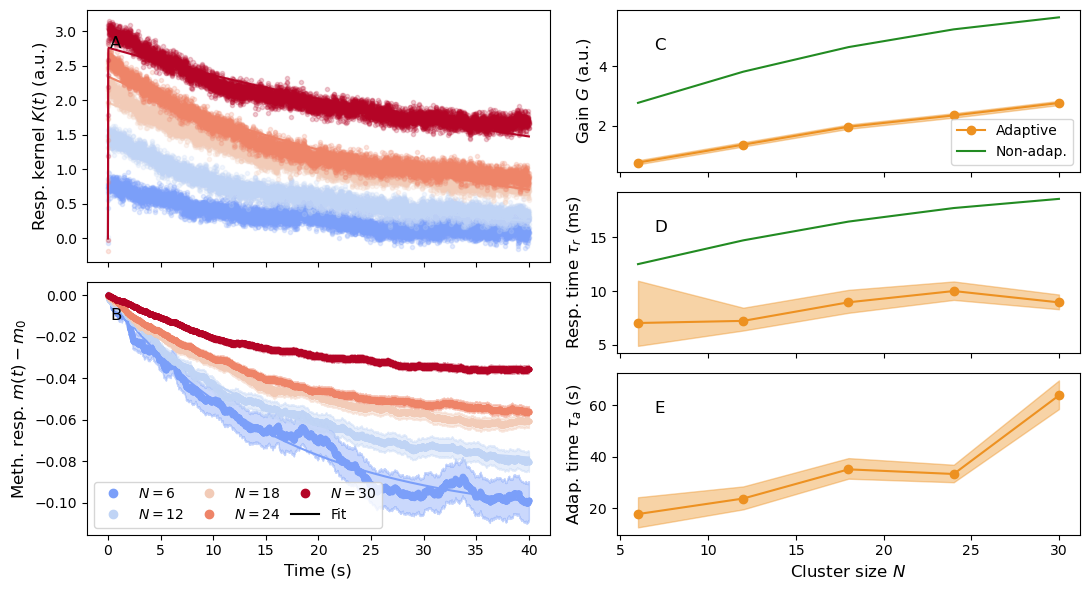

In [91]:
# adaptive response kernel
def rk(t,G,tau_r,tau_a):
    return G*(1-np.exp(-t/tau_r))*np.exp(-t/tau_a)

def meth_fit(t,Gm,tau_m):
    return Gm*(1-np.exp(-t/tau_m))

# preparation
fig_rk_mwc_ad = plt.figure(figsize=(11,6))

# create subplots
gs = gridspec.GridSpec(6, 2)
ax1 = plt.subplot(gs[:3,0])
ax2 = plt.subplot(gs[3:,0],sharex=ax1)
ax3 = plt.subplot(gs[:2,1])
ax4 = plt.subplot(gs[2:4,1],sharex=ax3)
ax5 = plt.subplot(gs[4:,1],sharex=ax3)

# parms
Ns = 2500 # 2000
tf = 65
tc = 25
st = 0.005
k_act = 50
Nbs = 1000
alpha = 0.32
c0 = 100
cf = 90

N_arr = np.arange(6,31,6)

rk_parms_ad = np.zeros((3,N_arr.size),dtype='float64')
rk_lb_ad = np.zeros_like(rk_parms_ad)
rk_ub_ad = np.zeros_like(rk_parms_ad)

ltr_lb = np.zeros(N_arr.size,dtype='float64') # for log of ratio of time scales
ltr_ub = np.zeros_like(ltr_lb)

meth_parms_ad = np.zeros((2,N_arr.size),dtype='float64')
meth_lb_ad = np.zeros_like(meth_parms_ad)
meth_ub_ad = np.zeros_like(meth_parms_ad)

handles = []

for n,N in enumerate(N_arr):
    print('N =',N)
    # obtain ensemble and sample
    ensemble, all_tau = adaptive_mwc_simulator(Ns,tf,tc,N=N,c0=c0,cf=cf)
    all_samples, t_grid = multi_dim_sampler(ensemble,all_tau,Ns,tf,st)
    
    # find response kernel
    all_responses = ((all_samples[:,t_grid >= tc,0].T - all_samples[:,int(tc/st)-1,0].T)/np.log(c0/cf)).T
    all_meth = ((all_samples[:,t_grid >= tc,1].T - all_samples[:,int(tc/st)-1,1].T)/np.log(c0/cf)).T
    all_meth /= 4*N # normalise
    response = np.mean(all_responses,axis=0)
    meth = np.mean(all_meth,axis=0)
    time_s = t_grid[t_grid >= tc] - tc
    
    # get confidence interval from bootstrapping
    # lb, ub, bs_means = bs_ci(time_s,all_responses,Nbs,alpha=alpha)
    meth_lb, meth_ub, bs_means = bs_ci(time_s,all_meth,Nbs,alpha=alpha)
    
    # fitting and bootstrappin'
    rk_parms_ad[:,n], rk_lb_ad[:,n], rk_ub_ad[:,n], bs_parms = bs_fitting(time_s,all_responses,rk,Nbs,alpha=alpha)
    ltr = np.log10(bs_parms[2]/bs_parms[1])
    ltr_lb[n] = np.percentile(ltr,100*alpha/2)
    ltr_ub[n] = np.percentile(ltr,100*(1-alpha/2))
    
    meth_parms_ad[:,n], meth_lb_ad[:,n], meth_ub_ad[:,n],_ = bs_fitting(time_s,all_meth,meth_fit,Nbs,alpha=alpha)
    
    color=colormap((n+1)/N_arr.size)
    
    ax1.plot(time_s,response,'.',color=color,alpha=0.2)
    # ax1.fill_between(time_s,lb,ub,color=color,alpha=0.4)
    ax1.plot(time_s,rk(time_s,*rk_parms_ad[:,n]),color=color)
    
    ax2.plot(time_s,meth,'.',color=color,alpha=0.8)
    ax2.fill_between(time_s,meth_lb,meth_ub,color=color,alpha=0.4)
    ax2.plot(time_s,meth_fit(time_s,*meth_parms_ad[:,n]),color=color)
    
    handles.append(Line2D([],[],color=color,marker='o',linestyle='None',label=f'$N={N}$'))
    
# formatting
handles.append(Line2D([],[],color='k',label='Fit'))
ax1.set_ylabel(r'Resp. kernel $K(t)$ (a.u.)',size=12) 
ax1.text(0.05,0.85,'A',size=12,transform = ax1.transAxes)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2.legend(handles=handles,loc='lower left',fontsize=10,ncol=3,columnspacing=0.8)
ax2.set_xlabel('Time (s)',size=12)
ax2.set_ylabel(r'Meth. resp. $m(t)-m_0$',size=12)
ax2.text(0.05,0.85,'B',size=12,transform = ax2.transAxes)

ax3.plot(N_arr,(pA(cf,N_arr)-1/3)/np.log(c0/cf),color=my_green)
ax3.plot(N_arr,rk_parms_ad[0,:],'-o',color=my_yellow)
ax3.fill_between(N_arr,rk_lb_ad[0,:],rk_ub_ad[0,:],color=my_yellow,alpha=0.4)

handles = []
handles.append(Line2D([],[],color=my_yellow,marker='o',label='Adaptive'))
handles.append(Line2D([],[],color=my_green,label=f'Non-adap.'))

ax3.legend(handles=handles,loc='lower right',fontsize=10)
ax3.set_ylabel(r'Gain $G$ (a.u.)',size=12)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4.plot(N_arr,pA(cf,N_arr)/k_act*1000,color=my_green)
ax4.plot(N_arr,rk_parms_ad[1,:]*1000,'-o',color=my_yellow)
ax4.fill_between(N_arr,rk_lb_ad[1,:]*1000,rk_ub_ad[1,:]*1000,color=my_yellow,alpha=0.4)
# ax4.legend(handles=handles,loc='lower right',fontsize=10)
ax4.set_ylabel(r'Resp. time $\tau_r$ (ms)',size=12)
plt.setp(ax4.get_xticklabels(), visible=False)

# ax5.plot(N_arr,meth_parms_ad[1,:],'-o',color=my_blue,label=r'$\tau_m$')
# ax5.fill_between(N_arr,meth_lb_ad[1,:],meth_ub_ad[1,:],color=my_blue,alpha=0.4)
ax5.plot(N_arr,rk_parms_ad[2,:],'-o',color=my_yellow,label=r'$\tau_a$')
ax5.fill_between(N_arr,rk_lb_ad[2,:],rk_ub_ad[2,:],color=my_yellow,alpha=0.4)
ax5.set_ylabel(r'Adap. time $\tau_a$ (s)',size=12)
ax5.set_xlabel(r'Cluster size $N$',size=12)
# ax5.legend(fontsize=10,ncol=2,loc='upper center')

letter_list = ['C','D','E'] # for formatting
for i,ax in enumerate((ax3,ax4,ax5)):
    ax.text(0.08,0.75,letter_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()
plt.show()

In [92]:
fig_rk_mwc_ad.savefig('Figures/rk_mwc_ad.pdf')

### Noise kernel

In [93]:
@numba.jit(nopython=True)
def adaptive_cell_activity(Ns,Nc,tf,tc,st,N=6,cf=90):
    '''
    Finds an ensemble of single-cell activities, i.e., activities averaged over the cell's clusters.
    Runs on Numba's nopython mode.

    Parameters
    ----------
    Ns: int
        number of samples, i.e., the number of cells in the ensemble
    Nc: int
        number of clusters per cell
    tf: float
        final time of the underlying Gillepsie simulation
    tc: float
        time at which the concentration is changed
    st: float
        sampling time period
    N: float, optional
        number of receptors per cluster. By default 6
    cf: float, optional
        final concentration. Default is 90 microM

    Returns
    ----------
    all_cell_act: ndarray
        time-sampled traces of the activity for each cell. Shape is (Ns,int(tf/st) + 1)
    all_meth_act: ndarray
        time-sampled traces of the methylation level for each cell. Shape is (Ns,int(tf/st) + 1)
    t_grid: ndarray
        times at which the time series are sampled, length int(tf/st) + 1
    '''
   
    # array to save result
    all_cell_act = np.zeros((Ns,int(tf/st) + 1),dtype='float64')
    all_cell_meth = np.zeros_like(all_cell_act)
   
    for s in range(Ns):
        # obtain a single-cell realisation
        ensemble, all_tau = adaptive_mwc_simulator(Nc,tf,tc,cf=cf,N=N)
        all_samples, t_grid = multi_dim_sampler(ensemble,all_tau,Nc,tf,st)
        all_cell_act[s,:] = np.sum(all_samples[:,:,0],axis=0)/Nc # average over the cell's clusters
        all_cell_meth[s,:] = np.sum(all_samples[:,:,1],axis=0)/Nc
   
    return all_cell_act, all_cell_meth, t_grid

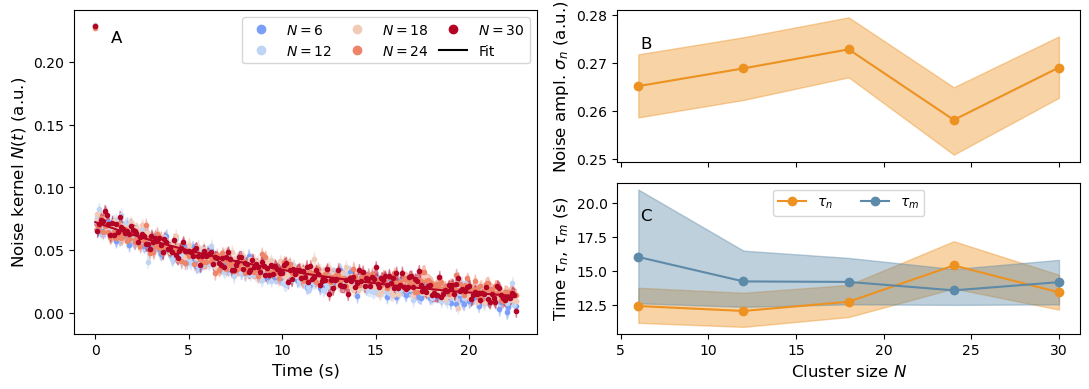

In [94]:
# noise kernel
def nk(t,sigma_n,tau_n):
    return sigma_n**2*np.exp(-np.abs(t)/tau_n)

# preparation
fig_nk_mwc_ad = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1],sharex=ax2)

# N_arr = np.arange(5,21,5)
Ns = 2000
Nc = 1
tf = 45
tc = 0
st = 0.1
co = int(0.5*tf/st)
cf = 90
Nbs = 1000
alpha = 0.32

nk_parms_ad = np.zeros((2,N_arr.size),dtype='float64')
nk_lb_ad = np.zeros_like(nk_parms_ad)
nk_ub_ad = np.zeros_like(nk_parms_ad)

handles = []

for n,N in enumerate(N_arr):
    # obtain ensemble and sample
    cell_ensemble, meth_ensemble, t_grid = adaptive_cell_activity(Ns,Nc,tf,tc,st,cf=cf)
    auto_corr, lb, ub, time_s, all_auto_corr = autocorr(cell_ensemble,t_grid,co,Nbs=Nbs,alpha=alpha)
        
    # fittin' and bootstrappin'
    nk_parms_ad[:,n],_ = curve_fit(nk,time_s[1:],auto_corr[1:])
    bs_parms = np.zeros((nk_parms_ad[:,n].size,Nbs),dtype='float64')
   
    for nbs in range(Nbs):
        bs_parms[:,nbs],_ = curve_fit(nk,time_s[1:],all_auto_corr[nbs,1:])
       
    # extract confidence interval from bootstrapped distribution
    nk_lb_ad[:,n] = np.percentile(bs_parms,100*alpha/2,axis=1)
    nk_ub_ad[:,n] = np.percentile(bs_parms,100*(1-alpha/2),axis=1)
    
    # show results
    color = colormap((n+1)/N_arr.size)
    ax1.plot(time_s,auto_corr,'.',color=color)
    ax1.fill_between(time_s[1:],lb[1:],ub[1:],color=color,alpha=0.4)
    ax1.plot(time_s,nk(time_s,*nk_parms_ad[:,n]),color=color)
    handles.append(Line2D([],[],color=color,marker='o',linestyle='None',label=f'$N={N}$'))
    
# formatting
handles.append(Line2D([],[],color='k',label='Fit'))
ax1.legend(handles=handles,loc='upper right',fontsize=10,ncol=3,columnspacing=0.8)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel(r'Noise kernel $N(t)$ (a.u.)',size=12) 
ax1.text(0.08,0.9,'A',size=12,transform = ax1.transAxes)

# handles = []
# handles.append(Line2D([],[],color=my_yellow,marker='-o',linestyle='None',label='Simulation'))
# handles.append(Line2D([],[],color=my_green,label=f'Theory'))
# handles.append(Line2D([],[],color='k',linestyle='--',label='Th. upper bound'))

# ax2.plot(N_arr,np.sqrt(pA(cf,N_arr)*(1-pA(cf,N_arr))),color=my_green,label='Theory')
ax2.plot(N_arr,nk_parms_ad[0,:],'-o',color=my_yellow,label='Simulation')
ax2.fill_between(N_arr,nk_lb_ad[0,:],nk_ub_ad[0,:],color=my_yellow,alpha=0.4)
# ax2.legend(loc='upper right',handles=handles,fontsize=10)
ax2.set_ylabel(r'Noise ampl. $\sigma_n$ (a.u.)',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

# ax3.plot(N_arr,pA(cf,N_arr)/k_act*1000,color=my_green)
ax3.plot(N_arr,nk_parms_ad[1,:],'-o',color=my_yellow,label=r'$\tau_n$')
ax3.fill_between(N_arr,nk_lb_ad[1,:],nk_ub_ad[1,:],color=my_yellow,alpha=0.4)
ax3.plot(N_arr,meth_parms_ad[1,:],'-o',color=my_blue,label=r'$\tau_m$')
ax3.fill_between(N_arr,meth_lb_ad[1,:],meth_ub_ad[1,:],color=my_blue,alpha=0.4)
ax3.legend(fontsize=10,ncol=2,loc='upper center')
ax3.set_xlabel(r'Cluster size $N$',size=12)
ax3.set_ylabel(r'Time $\tau_n$, $\tau_m$ (s)',size=12)

letter_list = ['B','C'] # for formatting
for i,ax in enumerate((ax2,ax3)):
    ax.text(0.05,0.75,letter_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()

plt.show()

In [95]:
fig_nk_mwc_ad.savefig('Figures/nk_mwc_ad.pdf')

### Response kernel

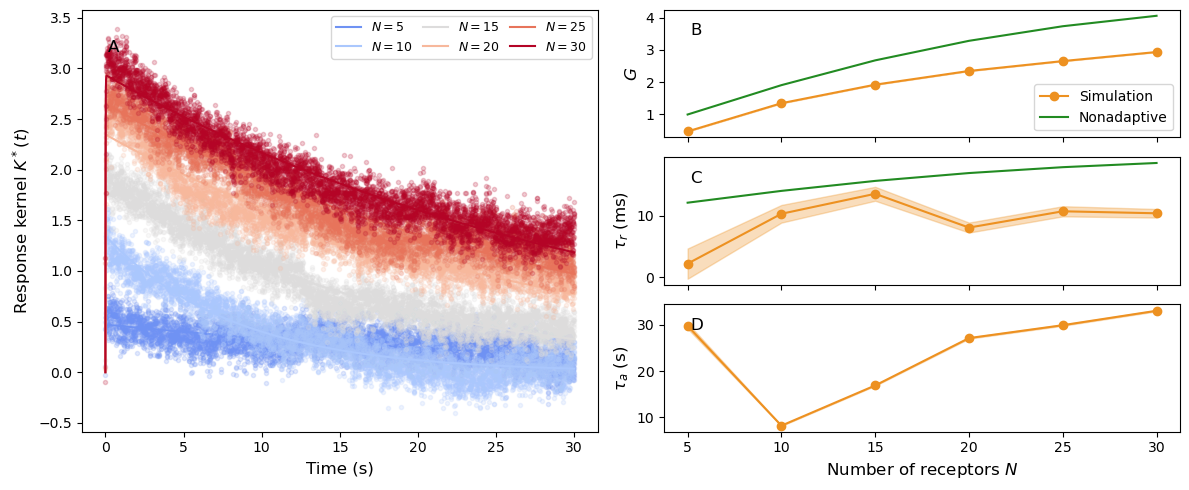

In [38]:
# nonadaptive response kernel
def rk(t,G,tau_r,tau_a):
    return G*(1-np.exp(-t/tau_r))*np.exp(-t/tau_a)

# fitting function for methylation level
def mk(t,mB,tau_m):
    return mB*np.exp(-t/tau_m)

# preparation
fig = plt.figure(figsize=(12,5))

# create subplots
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1],sharex=ax2)
ax4 = plt.subplot(gs[2,1],sharex=ax2)

N_arr = np.arange(5,31,5)
Ns = 1000
tf = 60
tc = 30
st = 0.005
k_act = 50
c0 = 100
cf = 90

# arrays to store results
rk_adap_parms = np.zeros((3,N_arr.size),dtype='float64')
rk_adap_sds = np.zeros_like(rk_adap_parms)

mk_parms = np.zeros((2,N_arr.size),dtype='float64')
mk_sds = np.zeros_like(mk_parms)

for n,N in enumerate(N_arr):
    # obtain ensemble and sample
    ensemble, all_tau = adaptive_mwc_simulator(Ns,tf,tc,N=N,c0=c0,cf=cf,k_act=k_act)
    all_samples, t_grid = multi_dim_sampler(ensemble,all_tau,Ns,tf,st)
    
    # find response kernel
    av_act = np.mean(all_samples[:,:,0],axis=0)
    response = (av_act[t_grid >= tc] - av_act[int(tc/st)-1])/np.log(c0/cf)
    time_s = t_grid[t_grid >= tc] - tc
    
    # fitting
    rk_popt, rk_pcov = curve_fit(rk,time_s,response,bounds=(0,np.inf))
    rk_adap_parms[:,n] = rk_popt
    rk_adap_sds[:,n] = [np.sqrt(rk_pcov[i,i]) for i in range(3)]
    
    # show results
    ax1.plot(time_s,response,'.',alpha=0.2,color=colormap((n+1)/N_arr.size))
    ax1.plot(time_s,rk(time_s,*rk_popt),color=colormap((n+1)/N_arr.size),label=f'$N={N}$')
    
    # characterise how methylation responds
    av_meth = np.mean(all_samples[:,:,1],axis=0)/(4*N)
    meth_response = av_meth[t_grid >= tc] - av_meth[-1]
    mk_popt, mk_pcov = curve_fit(mk,time_s,meth_response,bounds=(0,np.inf))
    mk_parms[:,n] = mk_popt
    mk_sds[:,n] = [np.sqrt(mk_pcov[i,i]) for i in range(2)]
    
# formatting
ax1.legend(loc='upper right',fontsize=9,ncol=3,columnspacing=0.8)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel(r'Response kernel $K^*(t)$',size=12) 
ax1.text(0.05,0.9,'A',size=12,transform = ax1.transAxes)

# convert the response time to units of ms
rk_adap_parms[1,:] *= 1000
rk_adap_sds[1,:] *= 1000

# plot the fitting parameters
letter_list = ['B','C','D']
for i,ax in enumerate((ax2,ax3,ax4)):
    ax.plot(N_arr,rk_adap_parms[i,:],'-o',color=my_yellow,label='Simulation')
    ax.fill_between(N_arr,rk_adap_parms[i,:]-rk_adap_sds[i,:],rk_adap_parms[i,:]+rk_adap_sds[i,:],color=my_yellow,alpha=0.3)
    ax.text(0.05,0.8,letter_list[i],size=12,transform = ax.transAxes) # formatting

# formatting and theoretical results
ax2.plot(N_arr,(pA(cf,N_arr)-0.5)/np.log(c0/cf),color=my_green,label='Non-adaptive') # theoretical
#ax2.axhline(y=(2/3)/np.log(c0/cf),xmin=0.05,xmax=0.95,ls='--',color=my_red)
ax2.legend(loc='lower right',fontsize=10)
ax2.set_ylabel(r'$G$',size=12)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3.plot(N_arr,pA(cf,N_arr)/k_act*1000,color=my_green) # theoretical
#ax3.axhline(y=1000/k_act,xmin=0.05,xmax=0.95,ls='--',color=my_red)
ax3.set_ylabel(r'$\tau_r$ (ms)',size=12)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4.set_xlabel(r'Number of receptors $N$',size=12)
ax4.set_ylabel(r'$\tau_a$ (s)',size=12)

plt.tight_layout()

plt.show()

In [346]:
Ns = 1000
tf = 100
tc = 35
cf = 70
st = 0.01

ensemble, all_tau = adaptive_mwc_simulator(Ns,tf,tc,cf=cf)
all_samples, t_grid = multi_dim_sampler(ensemble,all_tau,Ns,tf,st)

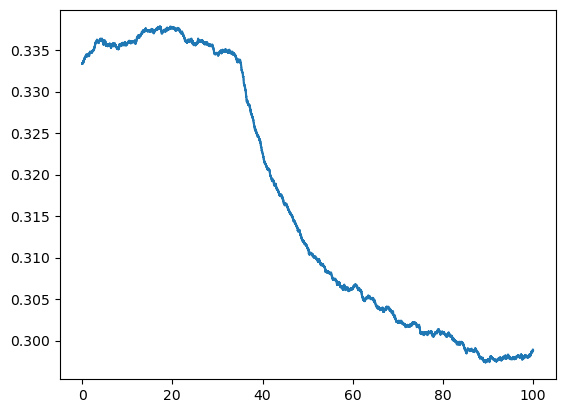

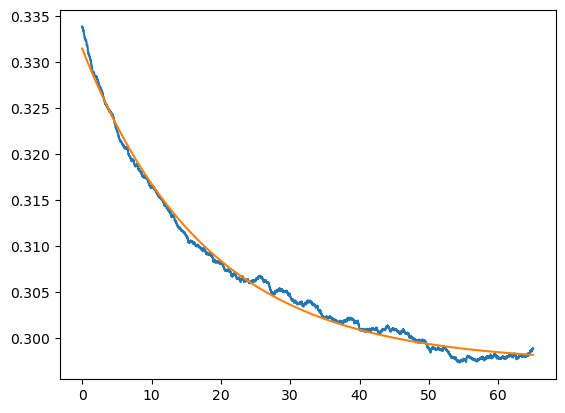

In [351]:
#plt.step(t_grid,np.mean(all_samples,axis=0)[:,0],where='post')
plt.step(t_grid,np.mean(all_samples,axis=0)[:,1]/24,where='post')
plt.show()

def meth_fit(t,base,scale,tau_m):
    return base + scale*np.exp(-t/tau_m)

av_meth = np.mean(all_samples,axis=0)[:,1]/24

time_s = t_grid[t_grid >= tc] - tc
meth_resp = av_meth[t_grid >= tc]

meth_popt, meth_pcov = curve_fit(meth_fit,time_s,meth_resp)

plt.plot(time_s,meth_resp)
plt.plot(time_s,meth_fit(time_s,*meth_popt))
plt.show()

### Alternative, slower implementations

In [21]:
def list_mwc_simulator(Ns,tf,tc,k_act=50,c0=100,cf=90,N=6,Ki=18,Ka=2900,
                          dfm=-2,kR=0.075,kB=0.15):
    '''
    Simulates a kinetic, adaptive MWC model using Gillespie's algorithm. Runs in Numba's
    nopython mode.
    
    Parameters
    ----------
    Ns: int
        number of samples
    tf: float
        final time of the simulation. By default, unit is s
    tc: float
        time at which the concentration changes
    k_act: float, optional
        sets time scale of (de)activation kinetics. Default is 50 per s
    c0: float, optional
        baseline concentration in microM. Default is 100 microM
    cf: float, optional
        concentration after the step change in microM. Default is 90 microM
    N: float, optional
        number of receptors per MWC cluster. Default is 6
    Ki, Ka: float, optional
        dissocation constants for inactive and active state, respectively, in microM.
        Defaults are 18 and 2900 microM, respectively
    dfm: float
        free-energy cost of an additional methyl group. Default is -2 kT
    kR, kB: float
        methylation and demethylation rate, respectively. Defaults are 0.075 
        and 0.15 per s, respectively
        
    Returns
    ---------
    ensemble: typed List
        contains the ensemble of Ns activities and Ns methylation levels
        Note: the methylation level is an integer between 0 and 4*N
    all_tau: typed List
        contains the ensemble of Ns waiting time traces
    
    '''
    # other methylation parameters
    m0 = N/2 # baseline 
    mMax = 4*N # maximum 
    
    # objects to store results
    ensemble = List() # use Numba lists; nested list will be deprecated
    all_tau = List()
    
    rates = np.zeros(2,dtype='float64')
    events = np.zeros((2,2),dtype='float64')
    
    # simulate the process Ns times
    for s in range(Ns):
        # initialise each realisation
        tau = List()
        am = List()
        a_init = biased_choice(np.array([0.,1.]),np.array([kB/(kR+kB),kR/(kR+kB)]))[0]
        m_init = mMax/3.
        am.append(List([a_init,m_init]))
        
        # initialise concentration-dependent free energy and time
        Fc = N*np.log((1+c0/Ki)/(1+c0/Ka))
        time = 0
        switch_bool = False # to keep track of concentration switch
        
        # run until the final time
        while time <= tf:
            # calculate free-energy difference
            F = Fc + dfm*(am[-1][1] - m0)

            # set methylation booleans
            m_ceiling = am[-1][1] < mMax
            m_floor = am[-1][1] > 0.
            
            # set rates and possible events
            if am[-1][0] == 0.: # inactive cluster
                rates[0] = k_act # activation
                events[0] = np.array([1.,0.])

                rates[1] = kR*m_ceiling # methylation
                events[1] = np.array([0.,1.])

            else: # active cluster
                rates[0] = k_act*np.exp(F) # deactivation
                events[0] = np.array([-1.,0.])

                rates[1] = kB*m_floor # demethylation
                events[1] = np.array([0.,-1.])

            # determine waiting time until next event
            u = np.random.uniform(0,1)
            time += -np.log(u)/np.sum(rates)

            # condition on which to change concentration
            if time >= tc and not switch_bool:
                # time needed to advance from last time step to tc
                advance = tc-(time + np.log(u)/np.sum(rates))

                # update free energy
                Fc = N*np.log((1+cf/Ki)/(1+cf/Ka))
                F = Fc + dfm*(am[-1][1] - m0)

                # update rates for deactivation (only one that changes)
                if am[-1][0] == 1.:
                    rates[0] = k_act*np.exp(F)

                # determine waiting time until next event
                u = np.random.uniform(0,1)
                time = tc-np.log(u)/np.sum(rates) # reset time to before the transgression

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                e_idx = np.argmax(p < np.cumsum(rates))
                
                # update time and state and the switch boolean
                tau.append(advance-np.log(u)/np.sum(rates))
                am.append(List([am[-1][0] + events[e_idx,0],am[-1][1] + events[e_idx,1]]))
                switch_bool = True

            else: # most cases
                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                e_idx = np.argmax(p < np.cumsum(rates))

                # save results
                tau.append(-np.log(u)/np.sum(rates))
                am.append(List([am[-1][0] + events[e_idx,0],am[-1][1] + events[e_idx,1]]))
    
        # store the realisation
        all_tau.append(tau)
        ensemble.append(am)
    
    return ensemble, all_tau

Ns = 10**1
tf = 20
tc = 10
cf = 70

%timeit list_mwc_simulator(Ns,tf,tc)

1.41 s ± 95.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
def numpy_mwc(Ns,tf,tc,k_act=50,c0=100,cf=90,N=6,Ki=18,Ka=2900,
                          dfm=-2,kR=0.075,kB=0.15):
    
    # other methylation parameters
    m0 = N/2 # baseline 
    mMax = 4*N # maximum 
    
    # objects to store results
    ensemble = [] # use Numba lists; nested list will be deprecated
    all_tau = []
    
    rates = np.zeros(2,dtype='float64')
    events = np.zeros((2,2),dtype='float64')
    
    # simulate the process Ns times
    for s in range(Ns):
        # initialise each realisation
        tau = np.array([0.])
        am = np.array([[0.,0.]])
        
        am[0,0] = np.random.choice(np.array([0.,1.]),p=np.array([kB/(kR+kB),kR/(kR+kB)]))
        # am[0,1] = biased_choice(meth_outcomes,meth_probs)[0]
        am[0,1] = mMax/3
        
        # initialise concentration-dependent free energy and time
        Fc = N*np.log((1+c0/Ki)/(1+c0/Ka))
        time = 0
        switch_bool = False # to keep track of concentration switch
        
        # run until the final time
        while time <= tf:
            # calculate free-energy difference
            F = Fc + dfm*(am[-1,1] - m0)

            # set methylation booleans
            m_ceiling = am[-1,1] < mMax
            m_floor = am[-1,1] > 0.
            
            # set rates and possible events
            if am[-1,0] == 0.: # inactive cluster
                rates[0] = k_act # activation
                events[0] = np.array([1.,0.])

                rates[1] = kR*m_ceiling # methylation
                events[1] = np.array([0.,1.])

            else: # active cluster
                rates[0] = k_act*np.exp(F) # deactivation
                events[0] = np.array([-1.,0.])

                rates[1] = kB*m_floor # demethylation
                events[1] = np.array([0.,-1.])

            # determine waiting time until next event
            u = np.random.uniform(0,1)
            time += -np.log(u)/np.sum(rates)

            # condition on which to change concentration
            if time >= tc and not switch_bool:
                # time needed to advance from last time step to tc
                advance = tc-(time + np.log(u)/np.sum(rates))

                # update free energy
                Fc = N*np.log((1+cf/Ki)/(1+cf/Ka))
                F = Fc + dfm*(am[-1,1] - m0)

                # update rates for deactivation (only one that changes)
                if am[-1,0] == 1.:
                    rates[0] = k_act*np.exp(F)

                # determine waiting time until next event
                u = np.random.uniform(0,1)
                time = tc-np.log(u)/np.sum(rates) # reset time to before the transgression

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                e_idx = np.argmax(p < np.cumsum(rates))
                
                # update time and state and the switch boolean
                tau = np.append(tau,advance-np.log(u)/np.sum(rates))
                am = np.vstack((am,am[-1]+events[e_idx]))
                switch_bool = True

            else: # most cases
                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                e_idx = np.argmax(p < np.cumsum(rates))

                # save results
                tau = np.append(tau,-np.log(u)/np.sum(rates))
                am = np.vstack((am,am[-1]+events[e_idx])) # numpy way
    
        # store the realisation
        all_tau.append(tau)
        ensemble.append(am)
    
    return ensemble, all_tau

Ns = 10**1
tf = 20
tc = 10
cf = 70

%timeit numpy_mwc(Ns,tf,tc)

748 ms ± 47.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Nonadaptive Ising Model

### Main functions

In [13]:
@numba.jit(nopython=True)
def ising_rates(s,J,H,omega0=1,open_boundary=True):
    '''
    Gives the flipping rates for a simple kinetic Ising model.
    
    Parameters
    ----------
    s: 2d array
        lattice of spins
    J: float
        coupling strength in units of kBT
    H: float
        external field strength in units of kBT
    omega0: float, optional
        fundamental flipping frequency. Note that all time is in units of 1/omega0
    open_boundary: bool, optional
        defines the boundary condition. By default, open boundaries are used
        
    Returns
    ----------
    omega: 2d array
        flipping rate of each spin. Has same shape as s and is computed as
        omega0*e^(-(coupling + external)), where coupling and external are the 
        coupling or external field contributions to the energy difference upon spin flipping
    '''
    
    # arrays to store the nearest neighbours
    nn = np.zeros_like(s)

    # loop through the array to store nearest neighbours (fast than using np.roll in Numba)
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            left = s[i,j-1]
            right = s[i,(j+1)%s.shape[1]]
            top = s[i-1,j]
            bottom = s[(i+1)%s.shape[0],j]

            nn[i,j] = left + right + top + bottom
                    
    # if we have open boundaries, remove neighbours at the edges
    if open_boundary:
        nn[:,0] += -s[:,-1]
        nn[:,-1] += -s[:,0]
        nn[0,:] += -s[-1,:]
        nn[-1,:] += -s[0,:]
    
    if s.size == 1:
        nn *= 0.
    
    # return the rates; based on detailed balance
    return omega0*np.exp(-(J*nn + H)*s)

In [14]:
@numba.jit(nopython=True)
def ising_simulator(Ns,tf,tc,L,J,
                    omega0=1,c0=100,cf=90,Ki=18,Ka=2900,open_boundary=True):
    '''
    Simulates a kinetic, non-adaptive two-dimensional Ising model on a square lattice 
    using Gillespie's algorithm. Runs in Numba's nopython mode.
    
    Parameters
    ----------
    Ns: int
        number of realisations
    tf: float
        final time of the simulation
    tc: float
        time at which the concentration changes
    L: int
        linear dimension of lattice, i.e., there are LxL spins
    J: float
        coupling strength in units of kBT
    omega0: float, optional
        fundamental flipping frequency. Note that all time is in units of 1/omega0
    c0: float, optional
        baseline concentration. Default is 100 microM
    cf: float, optional
        concentration after the step change Default is 90 microM
    Ki, Ka: float, optional
        dissocation constants for inactive and active state, respectively, in microM.
        Defaults are 18 and 2900 microM, respectively.
    open_boundary: bool, optional
        defines the boundary condition. By default, open boundaries are used
        
    Returns
    ---------
    ensemble: typed List
        contains the ensemble of Ns realisations of the Ising model
        note: ensemble[0] gives the first realisation; ensemble[0][0] the first lattice of
        the first realisation etc.
    all_tau: typed List
        contains the ensemble of Ns waiting time traces
    '''
    # Numba lists to store results
    ensemble = List()
    all_tau = List()

    # baseline external field; chosen s.t. H = 0 at c = c0
    eps0 = -np.log((1+c0/Ki)/(1+c0/Ka))

    # obtain Ns realisations
    for n in range(Ns):
        # initialise each realisation
        s = np.random.choice(np.array([-1.,1.]),size=(L,L))
        spins = np.expand_dims(s,axis=0)

        tau = np.zeros(1,dtype='float64')
        time = 0
        
        H = 0. # set to baseline energy at c0
        switch_bool = False # to check whether concentration has changed

        # evolve system until tf
        while time <= tf:
            # determine flipping rates
            rates = ising_rates(s,J,H,open_boundary=open_boundary)

            # sample time until next event
            u = np.random.uniform(0,1)
            time += -np.log(u)/np.sum(rates)

            # if has passed tc: reset the system to the time of the concentration change
            if time > tc and switch_bool == False:
                # time needed to advance from last time step to tc
                advance = tc-(time + np.log(u)/np.sum(rates))

                # update external field and rates
                H = -0.5*(np.log((1+cf/Ki)/(1+cf/Ka)) + eps0)
                rates = ising_rates(s,J,H,open_boundary=open_boundary)

                # sample time until next event
                u = np.random.uniform(0,1)
                time = tc-np.log(u)/np.sum(rates)
                tau = np.append(tau,advance-np.log(u)/np.sum(rates))

                # update the boolean to prevent further switching
                switch_bool = True
            # most cases: just save waiting time 
            else:
                tau = np.append(tau,-np.log(u)/np.sum(rates))

            # determine which spin flips
            p = np.random.uniform(0,1)*np.sum(rates)
            e_idx = np.argmax(p < np.cumsum(rates))

            # convert to lattice coordinates, flip the spin and save the state
            x,y = np.divmod(e_idx,L)
            s[x,y] *= -1.
            spins = np.concatenate((spins,np.expand_dims(s,axis=0)))

        ensemble.append(spins)
        all_tau.append(tau)
        
    return ensemble, all_tau

@numba.jit(nopython=True)
def ising_sampler(ensemble,all_tau,Ns,tf,st):
    '''
    Samples the time series of an ensemble of Ising lattices defined by waiting times at regular time points.
    The ensemble consists of state vectors of length larger than 1. Runs in Numba's nopython mode.
    
    Parameters
    ----------
    ensemble: typed List
        contains Ns realisations over time
    all_tau: typed List
        contains the waiting times for each realisation
    Ns: int
        number of realisations
    tf: float
        final time of the simulation of the ensemble
    st: float
        sampling time
    
    Returns
    ----------
    all_samples: ndarray
        contains the sampled version of each realisation from 0 to tf. Has shape (Ns,int(tf/st) + 1,L,L),
        where L is the linear dimension of the lattice
    t_grid: ndarray
        regularly spaced grid of time points from 0 to tf at which the samples have been taken
    '''
    # extract size
    L = len(ensemble[0][0])

    # arrays to store results
    all_samples = np.zeros((Ns,int(tf/st)+1,L,L),dtype='float64')
    t_grid = np.linspace(0,tf,int(tf/st)+1)

    # sample each realisation
    for n in range(Ns):
        # time in the realisation
        time_r = np.cumsum(all_tau[n])

        # save the state before passing a regular time point
        for t,t_s in enumerate(t_grid):
            all_samples[n,t] = ensemble[n][np.argmax(t_s < time_r)-1]
            
    return all_samples, t_grid

In [15]:
# check how fast this is
Ns = 100
tf = 30
tc = 15
st = 0.01
L = 2
J = 0.3
%timeit ising_simulator(Ns,tf,tc,L,J)

16.9 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Model verification

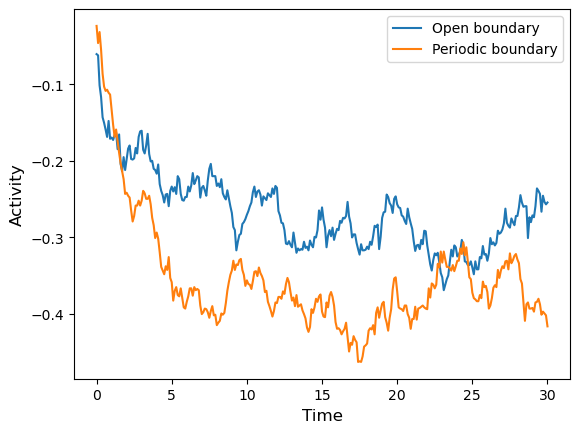

In [292]:
Ns = 100
tf = 30
tc = 0
st = 0.1
L = 5
J = 0.3
ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=120)
all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)


plt.plot(t_grid,np.mean(all_samples,axis=(0,-1,-2)),label='Open boundary')

ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=120,open_boundary=False)
all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)

plt.plot(t_grid,np.mean(all_samples,axis=(0,-1,-2)),label='Periodic boundary')

plt.xlabel('Time',size=12)
plt.ylabel('Activity',size=12)
plt.legend()
plt.show()

/tmp/ipykernel_2505665/3889710908.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


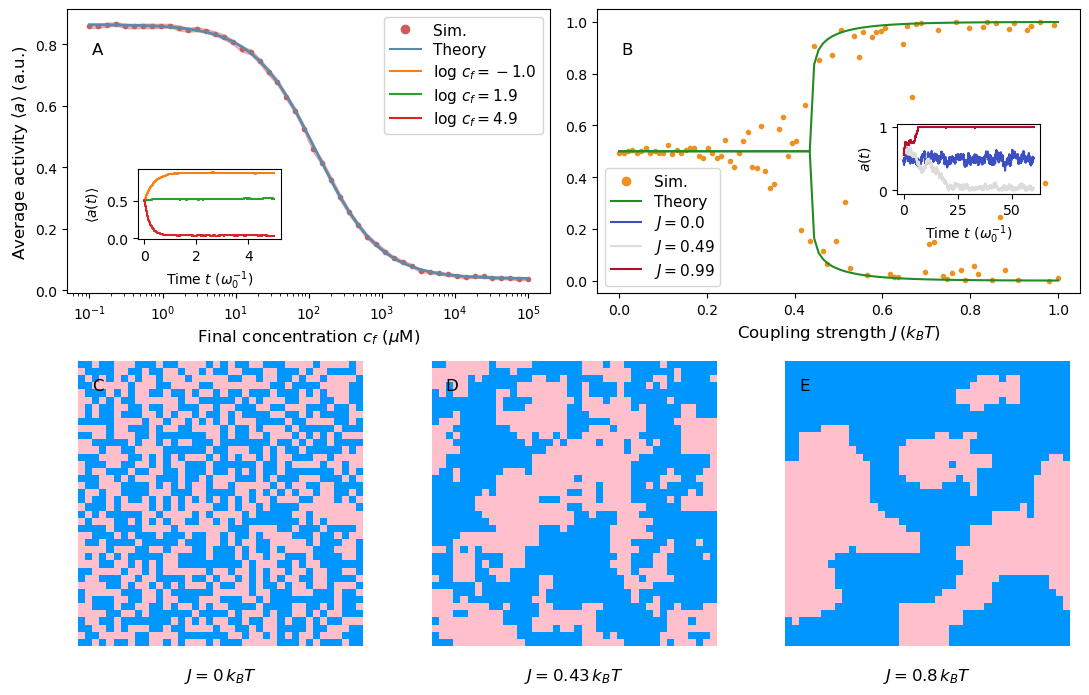

In [44]:
# preparation
fig_ising_benchmarks = plt.figure(figsize=(11,7))

# create subplots
gs = gridspec.GridSpec(2, 6)
ax1 = plt.subplot(gs[0,:3])

# create insets
left, bottom, width, height = [0.13, 0.65, 0.13, 0.1]
axx = fig_ising_benchmarks.add_axes([left, bottom, width, height])

ax2 = plt.subplot(gs[0,3:])

left, bottom, width, height = [0.82, 0.715, 0.13, 0.1]
axy = fig_ising_benchmarks.add_axes([left, bottom, width, height])

ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:])

#################
## No coupling ##
#################

# parameters
Ns = 100
tf = 5
tc = 0
st = 0.01
L = 10
Nbs = 1000
alpha = 0.05

# prep
J = 0
c_arr = np.logspace(-1,5,50)
all_act = np.empty((Ns,c_arr.size))
avg_act = np.empty(c_arr.size)
color_counter = 1

# loop through various concentrations
handles = []
handles.append(Line2D([],[],color=my_red,marker='o',linestyle='None',label='Sim.'))
handles.append(Line2D([],[],color=my_blue,label='Theory'))

for k,c in enumerate(c_arr):    
    # obtain average magnetisation at equilibrium
    ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c,open_boundary=False)
    all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
    all_act[:,k] = 0.5*np.mean(all_samples,axis=(-1,-2))[:,-1] + 0.5
    avg_act[k] = np.mean(all_act[:,k],axis=0)
        
    # plot realisations in the inset for some exemplars
    if k % (c_arr.size//2 - 1) == 0:
        axx.step(t_grid,0.5*np.mean(all_samples,axis=(0,-1,-2)) + 0.5,color=colormap_aux(color_counter),
                 where='post',label=f'log $c_f={np.round(np.log10(c),1)}$')
        handles.append(Line2D([],[],color=colormap_aux(color_counter),label=f'log $c_f={np.round(np.log10(c),1)}$'))
        color_counter += 1

# bootstrappin'
lb, ub, bs_means = bs_ci(c_arr,all_act,Nbs,alpha=alpha)

# check theoretical result
def theoretical_a(c,L,Ki=18,Ka=2900):
    epsilon = -np.log((1+100/Ki)/(1+100/Ka))
    return 0.5 + 0.5*np.tanh(-0.5*(epsilon + np.log((1+c/Ki)/(1+c/Ka))))

# show results
ax1.semilogx(c_arr,avg_act,'.',label='Simulation',color=my_red)
ax1.fill_between(c_arr,lb,ub,color=my_red,alpha=0.4)
ax1.semilogx(c_arr,theoretical_a(c_arr,L),label='Theory',color=my_blue,linewidth=2.)
ax1.set_xlabel(r'Final concentration $c_f$ ($\mu$M)',size=12)
ax1.set_ylabel(r'Average activity $\langle a \rangle$ (a.u.)',size=12)
ax1.text(0.05,0.84,'A',size=12,transform = ax1.transAxes)
ax1.legend(handles=handles,ncol=1,fontsize=11,loc='upper right',labelspacing=0.3,columnspacing=0.8)

# inset formatting
axx.set_xlabel(r'Time $t$ $(\omega_0^{-1})$',size=10)
axx.set_ylabel(r'$\langle a(t) \rangle$',size=10)
axx.tick_params(axis='both', which='major', labelsize=10)

######################
## Phase transition ##
######################

# preparation
J_arr = np.linspace(0,1,100)
avg_act = np.empty(J_arr.size)
lb_J = np.empty_like(avg_act)
ub_J = np.empty_like(avg_act)
Ns = 1
tf = 60
tc = tf + 1
st = 0.01
c0 = 100
L = 10

handles = []
handles.append(Line2D([],[],color=my_yellow,marker='o',linestyle='None',label='Sim.'))
handles.append(Line2D([],[],color=my_green,label='Theory'))

# loop through various coupling strengths
for j,J in enumerate(J_arr):
    # obtain average magnetisation at equilibrium
    ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c0,c0=c0,open_boundary=False)
    lattice_mean = np.mean(ensemble[0],axis=(-1,-2))
    trunc_lattice_mean = lattice_mean[100:-1]
    weights = all_tau[0][101:]
    avg_act[j] = 0.5*np.average(trunc_lattice_mean,weights=weights) + 0.5
    
    # plot realisations in the inset for some exemplars
    if j % (J_arr.size//2 - 1) == 0:
        axy.step(np.cumsum(all_tau[0]),0.5*lattice_mean + 0.5,color=colormap((j+1)/J_arr.size),
                 where='post',label=f'$J={np.round(J,2)}$')
        handles.append(Line2D([],[],color=colormap((j+1)/J_arr.size),label=f'$J={np.round(J,2)}$'))

# theoretical result for an infinite system
def theoretical_act(J,Jcrit=0.5*np.log(1+np.sqrt(2))):
    return np.piecewise(J, [J < Jcrit, J >= Jcrit], [0.5, lambda J: 0.5 + 0.5*((1 - (np.sinh(2*J))**-4)**(1/8))])

# show results
ax2.plot(J_arr,avg_act,'.',label='Simulation',color=my_yellow)
# ax2.fill_between(J_arr,lb_J,ub_J,color=my_yellow,alpha=0.4)
ax2.plot(J_arr,theoretical_act(J_arr),color=my_green)
ax2.plot(J_arr,1-theoretical_act(J_arr),color=my_green,alpha=1)
ax2.set_xlabel(r'Coupling strength $J \, (k_B T)$',size=12)
ax2.text(0.05,0.84,'B',size=12,transform = ax2.transAxes)
ax2.legend(handles=handles,ncol=1,fontsize=11,loc='lower left',labelspacing=0.3,columnspacing=0.8)

# inset formatting
axy.set_xlabel(r'Time $t$ $(\omega_0^{-1})$',size=10)
axy.set_ylabel(r'$a(t)$',size=10)
axy.tick_params(axis='both', which='major', labelsize=10)

##########################
## Spatial organisation ##
##########################

# formatting
ax3.set_axis_off()
ax4.set_axis_off()
ax5.set_axis_off()

# parameters
Ns = 1
tf = 10
tc = tf + 1
c0 = 100
L = 40
J_list = [0,0.43,0.8]

# for formatting
text_list = ['C','D','E']
cmap = matplotlib.colors.ListedColormap(['#FFC0CB','#0096FF'])

for i,ax in enumerate((ax3, ax4, ax5)):
    # obtain data and show lattice
    ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J_list[i],cf=c0,c0=c0,open_boundary=False)
    ax.imshow(0.5 + 0.5*ensemble[0][-1],cmap=cmap)
    ax.set_title(f'$J={J_list[i]} \, k_B T$', y=-0.15, size=12)
    ax.text(0.05,0.9,text_list[i],size=12,transform = ax.transAxes)

plt.tight_layout()
#plt.margins(x=0,y=0)
plt.show()

In [45]:
fig_ising_benchmarks.savefig('Figures/ising_benchmarks.pdf')

### Dose-response curves

L = 2
L = 4
L = 6


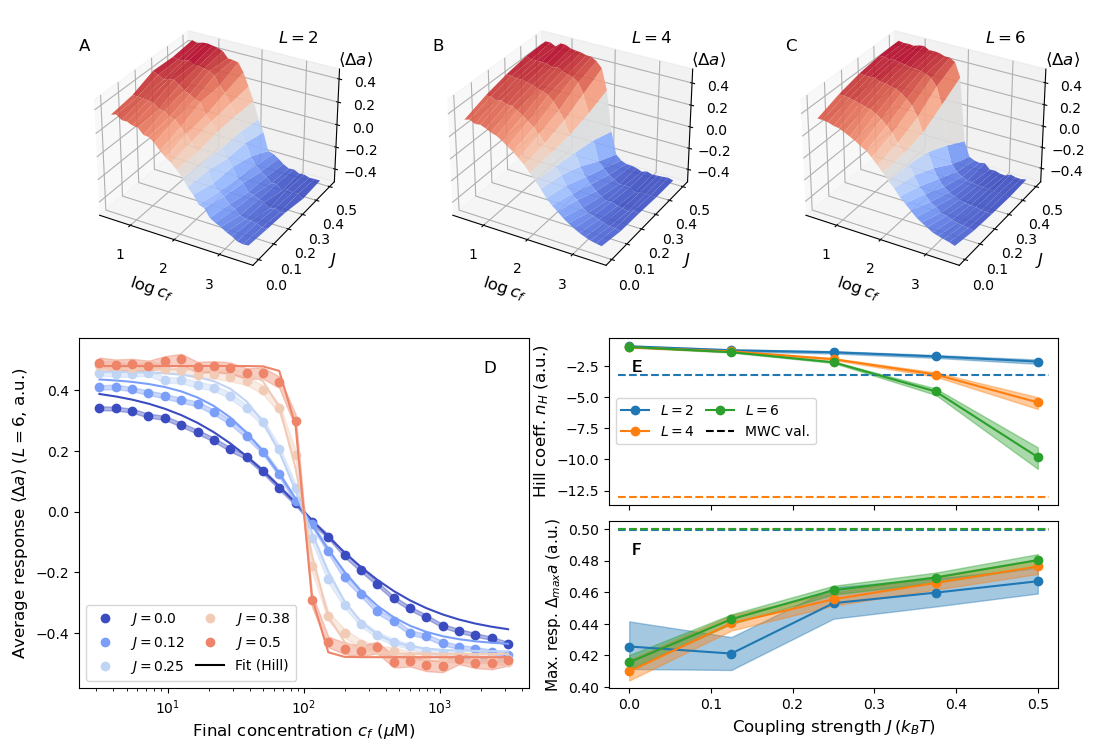

In [355]:
# preparation
fig_ising_drc = plt.figure(figsize=(11,8))
gs = gridspec.GridSpec(4, 6)

# get a nice color map
colormap = matplotlib.colormaps.get_cmap('coolwarm')

##############
## 3D plots ##
##############

ax1 = fig_ising_drc.add_subplot(gs[0:2,:2], projection='3d')
ax2 = fig_ising_drc.add_subplot(gs[0:2,2:4], projection='3d')
ax3 = fig_ising_drc.add_subplot(gs[0:2,4:], projection='3d')
ax4 = fig_ising_drc.add_subplot(gs[2:,:3])
ax5 = fig_ising_drc.add_subplot(gs[2,3:])
ax6 = fig_ising_drc.add_subplot(gs[3,3:],sharex=ax5)

Ns = 1000
tf = 45
tc = 5
st = 0.1
Nbs = 1000
alpha = 0.05

L_arr = np.array([2,4,6])
J_arr = np.linspace(0.,0.5,5)
c_arr = np.logspace(0.5,3.5,26)

J_plot, c_plot = np.meshgrid(J_arr,c_arr)

delta_a = np.zeros((L_arr.size,J_arr.size,c_arr.size),dtype='float64')
hill_parms = np.zeros((2,L_arr.size,J_arr.size))
hill_lb = np.zeros_like(hill_parms)
hill_ub = np.zeros_like(hill_parms)

text_list = ['A','B','C']
handles = []

all_delta_a = np.zeros((Ns,L_arr.size,J_arr.size,c_arr.size),dtype='float64')
mean_delta_a = np.zeros((L_arr.size,J_arr.size,c_arr.size),dtype='float64')
    
for l,ax in enumerate((ax1,ax2,ax3)):
    L = L_arr[l]
    print('L =',L)
    for j,J in enumerate(J_arr):
        for k,c in enumerate(c_arr):
            # obtain an ensemble and sample
            ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c)
            all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
            
            all_delta_a[:,l,j,k] = 0.5*np.mean(all_samples[:,-1]-all_samples[:,int(tc//st)-1],axis=(-1,-2))
            mean_delta_a[l,j,k] = np.mean(all_delta_a[:,l,j,k],axis=0)
            
        # perform fitting of hill function
        hill_popt, lb_parms, ub_parms, bs_parms = bs_fitting(c_arr,all_delta_a[:,l,j,:],hill_function,Nbs,alpha=0.05,bounds=([-np.inf,0],[0,np.inf]))
        hill_parms[:,l,j] = hill_popt
        hill_lb[:,l,j] = lb_parms
        hill_ub[:,l,j] = ub_parms
            
        # show slices for some results
        if L == L_arr[-1]:
            color = colormap(j/J_arr.size)
            lb, ub, _ = bs_ci(c_arr,all_delta_a[:,l,j,:],Nbs,alpha=alpha)
            ax4.semilogx(c_arr,mean_delta_a[l,j,:],'o',label=f'$J={J}$',color=color)
            ax4.fill_between(c_arr,lb,ub,color=color,alpha=0.4)
            ax4.semilogx(c_arr,hill_function(c_arr,*hill_parms[:,l,j]),color=color)
            handles.append(Line2D([],[],color=color,marker='o',linestyle='None',label=f'$J={np.round(J,2)}$'))
            
    ax.plot_surface(np.log10(c_plot).T, J_plot.T,mean_delta_a[l,:,:],cmap=plt.cm.coolwarm,alpha=0.9)
    ax.set_xlabel(r'$\log c_f$',size=12)
    ax.set_ylabel('$J$',size=12)
    ax.text2D(0.95,0.8,r'$\langle \Delta a \rangle$',size=12,transform = ax.transAxes)
    ax.text2D(0,0.85,text_list[l],size=12,transform = ax.transAxes)
    ax.text2D(0.73,0.88,f'$L={L_arr[l]}$',size=12,transform = ax.transAxes)

# figure formatting
handles.append(Line2D([],[],color='k',label='Fit (Hill)'))
ax4.set_xlabel(r'Final concentration $c_f$ ($\mu$M)',size=12)
ax4.set_ylabel(r'Average response $\langle \Delta a \rangle$ ($L = '+str(L_arr[-1])+'$, a.u.)',size=12)
ax4.legend(handles=handles,fontsize=10,columnspacing=0.8,ncol=2,loc='lower left')
ax4.text(0.9,0.9,'D',size=12,transform = ax4.transAxes)

text_list = ['E','F']
handles = []
for i,ax in enumerate((ax5,ax6)):
    for l,L in enumerate(L_arr):
        color = colormap_aux(l)
        ax.plot(J_arr,hill_parms[i,l,:],'-o',label=f'$L={L}$',color=color)
        ax.fill_between(J_arr,hill_lb[i,l,:],hill_ub[i,l,:],alpha=0.4,color=color)
        ax.text(0.05,0.8,text_list[i],size=12,transform = ax.transAxes)
        
        if i == 0 and L < L_arr[-1]:
            ax.axhline(y=(L**2)*100*(18-2900)/((18+100)*(2900+100)),xmin=0.02,xmax=0.98,color=color,ls='--')
        elif i == 1:
            ax.axhline(y=(1/(1+((1+100/2900)/(1+100/18))**(L**2))-0.5),xmin=0.02,xmax=0.98,color=color,ls='--')
            handles.append(Line2D([],[],color=color,marker='o',label=f'$L={L}$'))
        
# formatting
handles.append(Line2D([],[],color='k',linestyle='--',label='MWC val.'))
ax5.set_ylabel(r'Hill coeff. $n_H$ (a.u.)',size=12)
plt.setp(ax5.get_xticklabels(), visible=False)
ax5.legend(handles=handles,fontsize=10,ncol=2,columnspacing=0.8)

ax6.set_ylabel(r'Max. resp. $\Delta_{max} a$ (a.u.)',size=11)
ax6.set_xlabel('Coupling strength $J \, (k_B T)$',size=12)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

plt.show()

In [356]:
fig_ising_drc.savefig('Figures/ising_drc.pdf')

### Convergence: strong coupling

In [16]:
# self-consistency relation
def scr(m,J,c,q=4,Ki=18,Ka=2900):
    # define external field
    epsilon0 = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    H = -0.5*(epsilon0 + np.log((1+c/Ki)/(1+c/Ka)))
    
    return m-np.tanh(q*J*m + H)

# derivative of the scr; necessary for numerical solver
def scr_deriv(m,J,c,q=4,Ki=18,Ka=2900):
    epsilon0 = -np.log((1+100/Ki)/(1+100/Ka))
    H = -0.5*(epsilon0 + np.log((1+c/Ki)/(1+c/Ka)))
    
    return 1-q*J+q*J*(np.tanh(q*J*m+H))**2

def my_solver(guess,J,c,maxev=1000,tol=10**-6):
    '''
    Numerically solves the self-consistency relation for the mean-field Ising
    model based on Newton's method.
    
    Parameters
    ----------
    guess: 1d array
        initial guess for the solutions of the scr
    J: float
        coupling strength in units of kBT
    c: float
        ligand concentration in microM
    maxev: int, optional
        maximum number of iterations of the algorithm. Default is 1000
    tol: float, optional
        tolerance of the algorithm. Default is 10^-6
        
    Returns
    ----------
    sol: 1d array
        numerical solutions of the scr. Solutions for which the algorithm has not 
        converged are set to -2 and should be removed later
    '''
    # intialise
    sol = guess
    err = scr(sol,J,c)
    counter = 0
    
    # apply Newton's method until convergence
    while np.any(np.abs(err) > tol):
        sol = sol - scr(sol,J,c)/scr_deriv(sol,J,c)
        err = scr(sol,J,c)
        counter += 1
        
        if counter >= maxev:
            break
    
    # manually remove solutions that have not converged
    sol[np.abs(err) > tol] = -2.
    
    return sol

-0.6897544913829876
-0.6897544913829876
-2.0


/home/ipausers/zewe/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


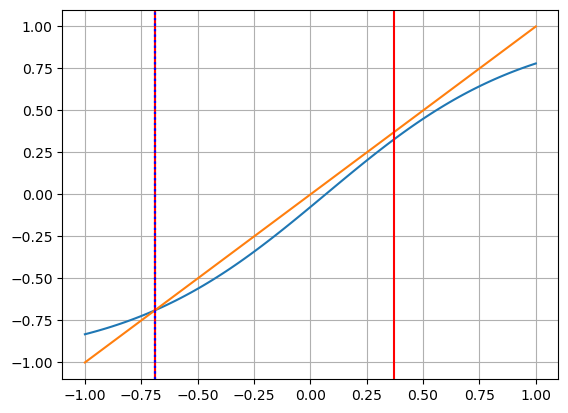

err. for fsolve [8.73116709e-06 1.38697036e-05 4.30246143e-02]
err. for newton [ 0.          0.         -1.01932249]


In [34]:
# compare my numerical solver against fsolve
c = 120
epsilon0 = -np.log((1 + 100/18)/(1 + 100/2900))
H = -0.5*(epsilon0 + np.log((1+c/18)/(1+c/2900)))
x = np.linspace(-1,1,100)
J = 0.28

guess = np.array([-1.,0.,1.])

# check my numerical solver versus fsolve
my_sol = my_solver(guess,J,c)
fsolve_sol = fsolve(scr,guess,args=(J,c),maxfev=1000)

plt.plot(x,np.tanh(4*J*x + H),label=f'tanh$(qJm + H)$')
plt.plot(x,x,label='$m$')
for i in fsolve_sol:
    plt.axvline(x=i,color='r')
    
for i in my_sol:
    print(i)
    if np.abs(i) < 1:
        plt.axvline(x=i,color='b',ls=':')
        
plt.grid()
plt.show()

print('err. for fsolve', scr(fsolve_sol,J,c))
print('err. for newton', scr(my_sol,J,c))

In [35]:
# function for calculating the theoretical ratio based on a mean-field theory
def ratio_mfa(J,c,N,q=4,Ki=18,Ka=2900):
    '''
    Computes the ratio of the probability of being inactive versus active for the 
    mean-field Ising model based on solutions of the self-consistency relation.
    
    Parameters
    ----------
    J: float
        coupling strength in units of kBT
    c: float
        ligand concentration in microM
    N: int
        number of receptors
    q: int, optional
        number of neighbours. Default is 4
    Ki, Ka: float, optional
        dissociation constants for the inactive and active state, resp.
        Defaults are 18 and 2900 microM.
        
    Returns
    ----------
    ratio: float
        ratio of the probability of inactivity versus activity, estimated as
        p(-F(m_min))/p(-F(m_plus)), where F is the mfa free energy and m_min and
        m_plus are stable solutions of the self-consistency relation
    '''
    # define external field
    epsilon0 = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    H = -0.5*(epsilon0 + np.log((1+c/Ki)/(1+c/Ka)))
    
    # this solves the self-consistency relation
    roots = my_solver(np.array([-1.,0.,1.]),J,c)
    
    # extract only the outer two solutions
    m_min = roots[0]
    m0 = roots[1]
    m_plus = roots[-1]
        
    # calculate ratio using analytical expression if two distinct outer solution branches exist
    if np.isclose([m_min],[m0]) or np.isclose([m0],[m_plus]) or np.isclose([m_min],[m_plus]):
        return -1
    else:
        prefac = np.exp(-0.5*q*J*(m_min**2 - m_plus**2))
        cosh_ratio = np.cosh(q*J*m_min + H)/np.cosh(q*J*m_plus + H)
    
        return (prefac*cosh_ratio)**N

# theoretical estimate of the desired ratio based on MWC
def mwc_ratio(c,N=6,Ki=18,Ka=2900):
    epsilon0 = -N*np.log((1 + 100/Ki)/(1 + 100/Ka))
    return np.exp(epsilon0)*((1 + c/Ki)/(1 + c/Ka))**N

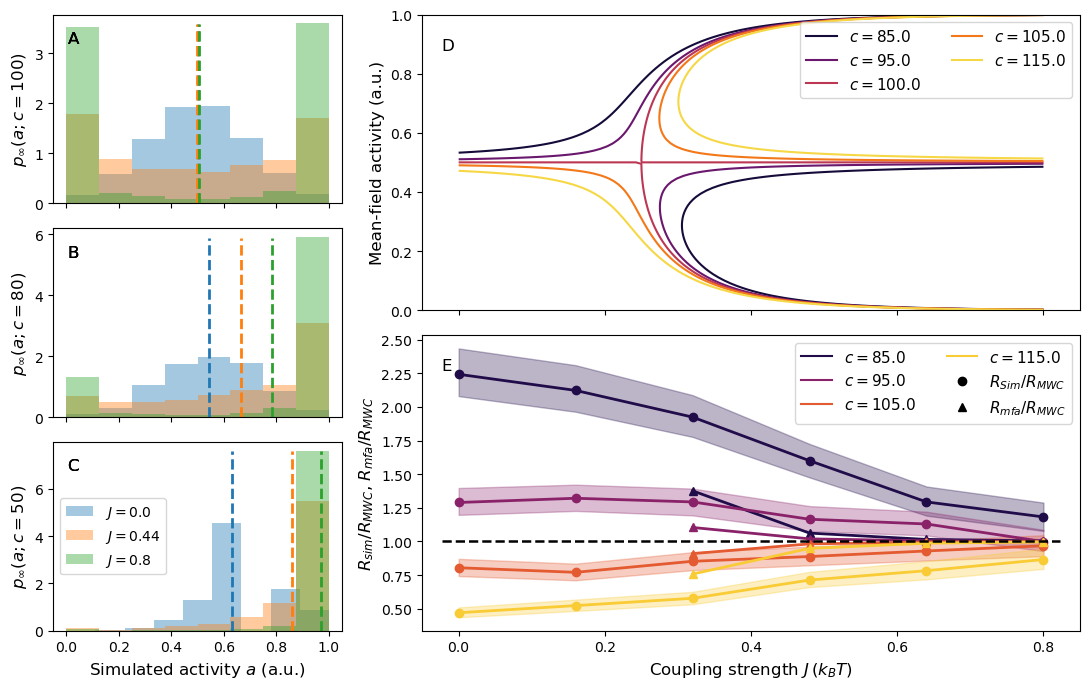

In [52]:
# preparation
fig_convergence = plt.figure(figsize=(11,7))
gs = gridspec.GridSpec(6, 3)

##############################
## Stationary distributions ##
##############################

ax3 = fig_convergence.add_subplot(gs[4:,0])
ax1 = fig_convergence.add_subplot(gs[0:2,0],sharex=ax3)
ax2 = fig_convergence.add_subplot(gs[2:4,0],sharex=ax3)

# parameters
Ns = 2500
tf = 100
tc = 0
st = 0.1
L = 3
N = L**2

J_arr = np.array([0.,0.44,0.8])
c_arr = np.array([100.,80.,50.])
text_list = ['A','B','C']

# for various J in absence of external field
for i,ax in enumerate((ax1, ax2, ax3)):
    for j,J in enumerate(J_arr):
        # set concentration and color
        c = c_arr[i]
        color = colormap_aux(j)
        
        # obtain an ensemble and sample
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c,open_boundary=True)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)

        # consider only the last time step of each realisation
        last_act = 0.5 + 0.5*np.mean(all_samples[:,-1,:,:],axis=(1,2))
        
        # plot distributions along with mean
        ax.hist(last_act,bins=8,density=True,color=color,label=f'$J={J}$',alpha=0.4)
        ax.axvline(x=np.mean(last_act),ymin=0.0,ymax=0.95,ls='--',color=color,linewidth=2.)
        ax.text(0.05,0.85,text_list[i],size=12,transform = ax.transAxes)
        
    ax.set_ylabel(r'$p_\infty(a; c = '+str(int(c))+')$',size=12)

# formatting
ax3.legend(fontsize=10,loc='center left')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax3.set_xlabel(r'Simulated activity $a$ (a.u.)',size=12)

#########################
## Bifurcation diagram ##
#########################

ax5 = fig_convergence.add_subplot(gs[3:,1:])
ax4 = fig_convergence.add_subplot(gs[0:3,1:],sharex=ax5)

# perform for various c
c_arr = np.array([85.,95.,100.,105.,115])
J_arr = np.linspace(0.,0.8,6)

# show the bifurcation diagram of the mean-field Ising model
m = np.linspace(-1,1,100)
J = np.linspace(J_arr[0],J_arr[-1],100)
m, J = np.meshgrid(m, J)

# transform to activity
a = 0.5*m + 0.5
handles = []

# solve the src for various c
for k,c in enumerate(c_arr):
    # set color
    color = colormap_inferno((k+0.5)/c_arr.size)
    cmap = matplotlib.colors.ListedColormap([color,color])
    
    # solve the self-consistency relation
    z = scr(m,J,c)
    ax4.contour(J, a, z, levels=[0], cmap=cmap)
    
    # legend formatting
    handles.append(Line2D([],[],color=color,label=f'$c={c}$'))

# formatting
ax4.legend(handles=handles,fontsize=11,ncol=2)
ax4.set_ylabel(r'Mean-field activity (a.u.)',size=12)
ax4.text(0.03,0.88,'D',size=12,transform = ax4.transAxes)
plt.setp(ax4.get_xticklabels(), visible=False)

#################
## Convergence ##
#################

c_arr = np.array([85.,95.,105.,115])

# bootstrapping parameters
Nbs = 1000
alpha = 0.05
bs_ratio = np.zeros((Nbs,c_arr.size,J_arr.size),dtype='float64')

# store results
ratio_sim = np.zeros((c_arr.size,J_arr.size),dtype='float64')
ratio_mfa_arr = np.zeros_like(ratio_sim)
handles = []

for k,c in enumerate(c_arr):
    # set a color and format legend
    color = colormap_inferno((k+0.5)/c_arr.size)
    handles.append(Line2D([],[],color=color,label=f'$c={c}$'))
    
    # increase J systematically
    for j,J in enumerate(J_arr):
        # obtain an ensemble and sample
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c,open_boundary=True)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
        
        all_last_act = 0.5 + 0.5*np.mean(all_samples[:,-1],axis=(-1,-2))
        
        # estimate the ratios
        ratio_sim[k,j] = np.sum(all_last_act < 0.5)/np.sum(all_last_act > 0.5)
        ratio_mfa_arr[k,j] = ratio_mfa(J,c,N)
        
        for n in range(Nbs):
            idx = np.random.choice(np.arange(Ns),size=Ns,replace=True)
            bs_sample = all_last_act[idx]
            bs_ratio[n,k,j] = np.sum(bs_sample < 0.5)/np.sum(bs_sample > 0.5)
        
    # show ratio of ratios for both sim and mfa
    lb = np.percentile(bs_ratio[:,k,:]/mwc_ratio(c,N=N),100*alpha/2,axis=0)
    ub = np.percentile(bs_ratio[:,k,:]/mwc_ratio(c,N=N),100*(1-alpha/2),axis=0)

    # check where the mfa ratio is well-defined
    mask = ratio_mfa_arr[k,:] >= 0.
    
    # show ratio of ratios for both sim and mfa
    ax5.plot(J_arr,ratio_sim[k,:]/mwc_ratio(c,N=N),'-o',color=color,linewidth=2.0)
    ax5.fill_between(J_arr,lb,ub,color=color,alpha=0.3)
    ax5.plot(J_arr[mask],ratio_mfa_arr[k,mask]/mwc_ratio(c,N=N),'-^',color=color,linewidth=2.0)

# formatting
handles.append(Line2D([], [], color='k', marker='o', linestyle='None', label=r'$R_{Sim}/R_{MWC}$'))
handles.append(Line2D([], [], color='k', marker='^', linestyle='None', label=r'$R_{mfa}/R_{MWC}$'))

ax5.legend(handles=handles,fontsize=11,ncol=2,loc='upper right')
ax5.set_xlabel(r'Coupling strength $J \, (k_B T)$',size=12)
ax5.set_ylabel(r'$R_{sim}/R_{MWC}$, $R_{mfa}/R_{MWC}$',size=12)
ax5.set_xlim(J_arr[0]-0.05,J_arr[-1]+0.05)
ax5.text(0.03,0.88,'E',size=12,transform = ax5.transAxes)
ax5.axhline(y=1,xmin=0.03,xmax=0.97,ls='--',color='k',linewidth=1.8)

plt.tight_layout()
plt.show()

In [53]:
fig_convergence.savefig('Figures/convergence.pdf')

### Estimating $N_\text{eff}$ 

L =  1
  Neff:  1.0191015175801963
  Neff:  0.978055742196514
  Neff:  0.9926851878396034
  Neff:  1.0097152862661125
  Neff:  1.036709034262646
  Neff:  1.0226616321294586
L =  2
  Neff:  1.0048447772852518
  Neff:  1.1383127361901682
  Neff:  1.2847134934572244
  Neff:  1.445950305990483
  Neff:  1.604187368790826
  Neff:  1.8061614175914853
L =  3
  Neff:  0.9945550232516327
  Neff:  1.2936937193604972
  Neff:  1.7181904874436928
  Neff:  2.352268165859516
  Neff:  3.320062342408432
  Neff:  4.833252019393809
L =  4
  Neff:  1.005250967104591
  Neff:  1.287667735677126
  Neff:  1.7101416434573373
  Neff:  2.41084600358524
  Neff:  3.631183540533318
  Neff:  6.21773192837918
L =  5
  Neff:  0.9990095570800023
  Neff:  1.3039397489381586
  Neff:  1.7221771816501106
  Neff:  2.4314565545534075
  Neff:  3.789317961771736
  Neff:  7.129349904912083
L =  6
  Neff:  1.0002141184097793
  Neff:  1.2965766040473117
  Neff:  1.7310048790844386
  Neff:  2.416969631448608
  Neff:  3.803273795343

/tmp/ipykernel_1213369/1469114528.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


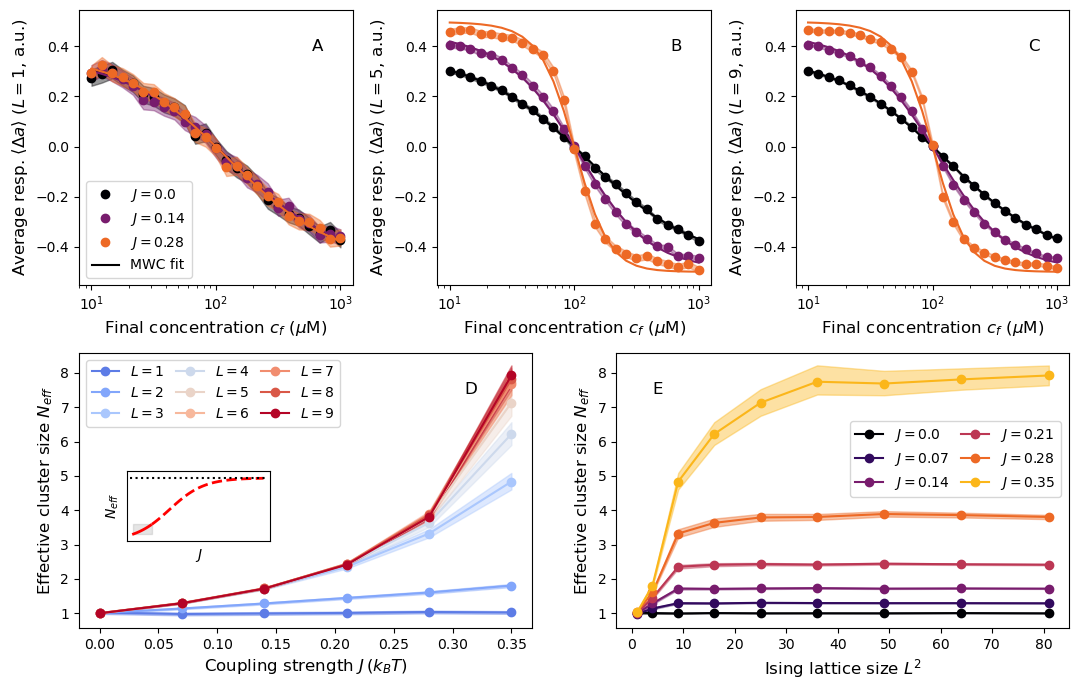

In [294]:
# define the drc for the MWC model
def drc_mwc(c,Neff):
    return pA(c,Neff)-1/2

# preparation
fig_Neff = plt.figure(figsize=(11,7))
gs = gridspec.GridSpec(2, 6)

ax1 = fig_Neff.add_subplot(gs[0,0:2])
ax2 = fig_Neff.add_subplot(gs[0,2:4],sharey=ax1)
ax3 = fig_Neff.add_subplot(gs[0,4:],sharey=ax1)

ax4 = fig_Neff.add_subplot(gs[1,:3])
ax5 = fig_Neff.add_subplot(gs[1,3:],sharey=ax4)

# insets
left, bottom, width, height = [0.12, 0.22, 0.13, 0.1]
axy = fig_Neff.add_axes([left, bottom, width, height])

# parameters
Ns = 1500
tf = 40 # 35 previously
tc = 5
st = 0.05
open_boundary = False
Nbs = 1000
alpha = 0.05

L_arr = np.array([1,2,3,4,5,6,7,8,9]) # add 9
J_arr = np.linspace(0,0.35,6) # or until 0.4
c_arr = np.logspace(1,3,25) # 25 values

#################
## drcs + fits ##
#################

mean_delta_a = np.zeros((L_arr.size,J_arr.size,c_arr.size),dtype='float64')
all_delta_a = np.zeros((Ns,L_arr.size,J_arr.size,c_arr.size),dtype='float64')
Neff_arr = np.zeros((L_arr.size,J_arr.size))
Neff_lb = np.zeros_like(Neff_arr)
Neff_ub = np.zeros_like(Neff_arr)

handles = []

for l,L in enumerate(L_arr):
    print('L = ', L)
    for j,J in enumerate(J_arr):
        for k,c in enumerate(c_arr):
            # obtain an ensemble and sample
            ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=c,open_boundary=open_boundary)
            all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
            
            all_delta_a[:,l,j,k] = 0.5*np.mean(all_samples[:,-1]-all_samples[:,int(tc//st)-1],axis=(-1,-2))
            mean_delta_a[l,j,k] = np.mean(all_delta_a[:,l,j,k],axis=0)
            
        # perform fitting and bootstrappin'
        Neff_arr[l,j], Neff_lb[l,j], Neff_ub[l,j], bs_parms = bs_fitting(c_arr,all_delta_a[:,l,j,:],drc_mwc,Nbs,alpha=0.05,bounds=([0,np.inf]))
        
        print('  Neff: ',Neff_arr[l,j])
        
        # check the fit
        if L == L_arr[0] and j%2 == 0:
            color = colormap_inferno(j/J_arr.size)
            lb, ub, _ = bs_ci(c_arr,all_delta_a[:,l,j,:],Nbs,alpha=alpha)
            ax1.semilogx(c_arr,mean_delta_a[l,j,:],'o',color=color)
            ax1.fill_between(c_arr,lb,ub,color=color,alpha=0.4)
            ax1.semilogx(c_arr,drc_mwc(c_arr,Neff_arr[l,j]),color=color)
            ax1.set_ylabel(r'Average resp. $\langle \Delta a \rangle$ ($L='+str(L)+'$, a.u.)',size=12)
            
            handles.append(Line2D([], [], color=color, marker='o',linestyle='None',label=f'$J={np.round(J,2)}$'))
            
        elif L == L_arr[int(L_arr.size/2)] and j%2 == 0:
            color = colormap_inferno(j/J_arr.size)
            lb, ub, _ = bs_ci(c_arr,all_delta_a[:,l,j,:],Nbs,alpha=alpha)
            ax2.semilogx(c_arr,mean_delta_a[l,j,:],'o',color=color)
            ax2.fill_between(c_arr,lb,ub,color=color,alpha=0.4)
            ax2.semilogx(c_arr,drc_mwc(c_arr,Neff_arr[l,j]),color=color)
            ax2.set_ylabel(r'Average resp. $\langle \Delta a \rangle$ ($L='+str(L)+'$, a.u.)',size=12)
            
        elif L == L_arr[-1] and j%2 == 0:
            color = colormap_inferno(j/J_arr.size)
            lb, ub, _ = bs_ci(c_arr,all_delta_a[:,l,j,:],Nbs,alpha=alpha)
            ax3.semilogx(c_arr,mean_delta_a[l,j,:],'o',color=color)
            ax3.fill_between(c_arr,lb,ub,color=color,alpha=0.4)
            ax3.semilogx(c_arr,drc_mwc(c_arr,Neff_arr[l,j]),color=color)
            ax3.set_ylabel(r'Average resp. $\langle \Delta a \rangle$ ($L='+str(L)+'$, a.u.)',size=12)
            
text_list = ['A','B','C']        
for i,ax in enumerate((ax1,ax2,ax3)):
    ax.set_xlabel(r'Final concentration $c_f$ ($\mu$M)',size=12)
    ax.text(0.85,0.85,text_list[i],size=12,transform = ax.transAxes)
        
# formatting
handles.append(Line2D([],[],color='k',label=r'MWC fit'))
ax1.legend(handles=handles,fontsize=10,loc='lower left',columnspacing=0.8)

################
## Neff plots ##
################

for l,L in enumerate(L_arr):
    color = colormap((l+1)/L_arr.size)
    ax4.plot(J_arr,Neff_arr[l,:],'-o',label=f'$L={L}$',color=color)
    ax4.fill_between(J_arr,Neff_lb[l,:],Neff_ub[l,:],color=color,alpha=0.4)
    
ax4.set_ylabel(r'Effective cluster size $N_{eff}$',size=12)
ax4.set_xlabel(r'Coupling strength $J \, (k_B T)$',size=12)
ax4.legend(fontsize=10,ncol=3,columnspacing=0.8,loc='upper left')
ax4.text(0.85,0.85,'D',size=12,transform = ax4.transAxes)

# plot mental picture for Neff versus J
def sigmoid(x,L,c):
    return L**2/(1+np.exp(-(c*x-np.log(L**2 - 1))))

x = np.linspace(0,2.5,100)
L = 3
c = 3

axy.plot(x[x<J_arr[-1]],sigmoid(x,L,c)[x<J_arr[-1]],color='r',linewidth=2)
axy.plot(x[x>J_arr[-1]],sigmoid(x,L,c)[x>J_arr[-1]],'--',color='r',linewidth=2)
axy.axhline(y=L**2,ls=':',xmin=0.02,xmax=0.98,color='k')
axy.fill_between([0,J_arr[-1]], 1, sigmoid(J_arr[-1],L,c),alpha=0.2,color='grey')
axy.set_ylim(0,L**2+1)

axy.set_ylabel(r'$N_{eff}$',size=10)
axy.set_xlabel(r'$J$',size=10)

plt.setp(axy.get_xticklabels(), visible=False)
plt.setp(axy.get_yticklabels(), visible=False)
axy.tick_params(left = False, bottom = False)

for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax5.plot(L_arr**2,Neff_arr[:,j],'-o',label=f'$J={np.round(J,2)}$',color=color)
    ax5.fill_between(L_arr**2,Neff_lb[:,j],Neff_ub[:,j],color=color,alpha=0.4)

ax5.set_ylabel(r'Effective cluster size $N_{eff}$',size=12)
ax5.set_xlabel(r'Ising lattice size $L^2$',size=12)
ax5.text(0.08,0.85,'E',size=12,transform = ax5.transAxes)
ax5.legend(fontsize=10,ncol=2,columnspacing=0.8,loc='best',bbox_to_anchor=(0.5,0.45))
# plt.setp(ax5.get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

In [295]:
fig_Neff.savefig('Figures/Neff.pdf')

### Correlation length (Manhattan)

In [267]:
@numba.jit(nopython=True)
def cross_corr(all_samples,L):    
    # prepare arrays
    g = np.zeros(L)
    dis_counts = np.zeros_like(g)
    dist = np.arange(0,L)
    
    # loop through all possible spin pairs
    for spin1 in range(L**2):
        x1,y1 = np.divmod(spin1,L)
        # start from spin1 to prevent double-counting
        for spin2 in range(spin1,L**2):
            x2,y2 = np.divmod(spin2,L)
            # compute Manhattan distance in a periodic lattice
            Dx = np.min(np.array([np.abs(x1-x2),L-np.abs(x1-x2)])) 
            Dy = np.min(np.array([np.abs(y1-y2),L-np.abs(y1-y2)]))
            dis = Dx + Dy

            # due to periodic boundaries only short distances matter
            if dis < L:
                g[dis] += np.corrcoef(np.vstack((all_samples[:,-1,x1,y1],all_samples[:,-1,x2,y2])))[0,1]
                dis_counts[dis] += 1

    # radial averaging
    for dis in dist:
        if dis_counts[dis] > 0:
            g[dis] /= dis_counts[dis]
            
    return g, dist

L =  2
L =  3
L =  4
L =  5
L =  6
L =  7
L =  8
L =  9


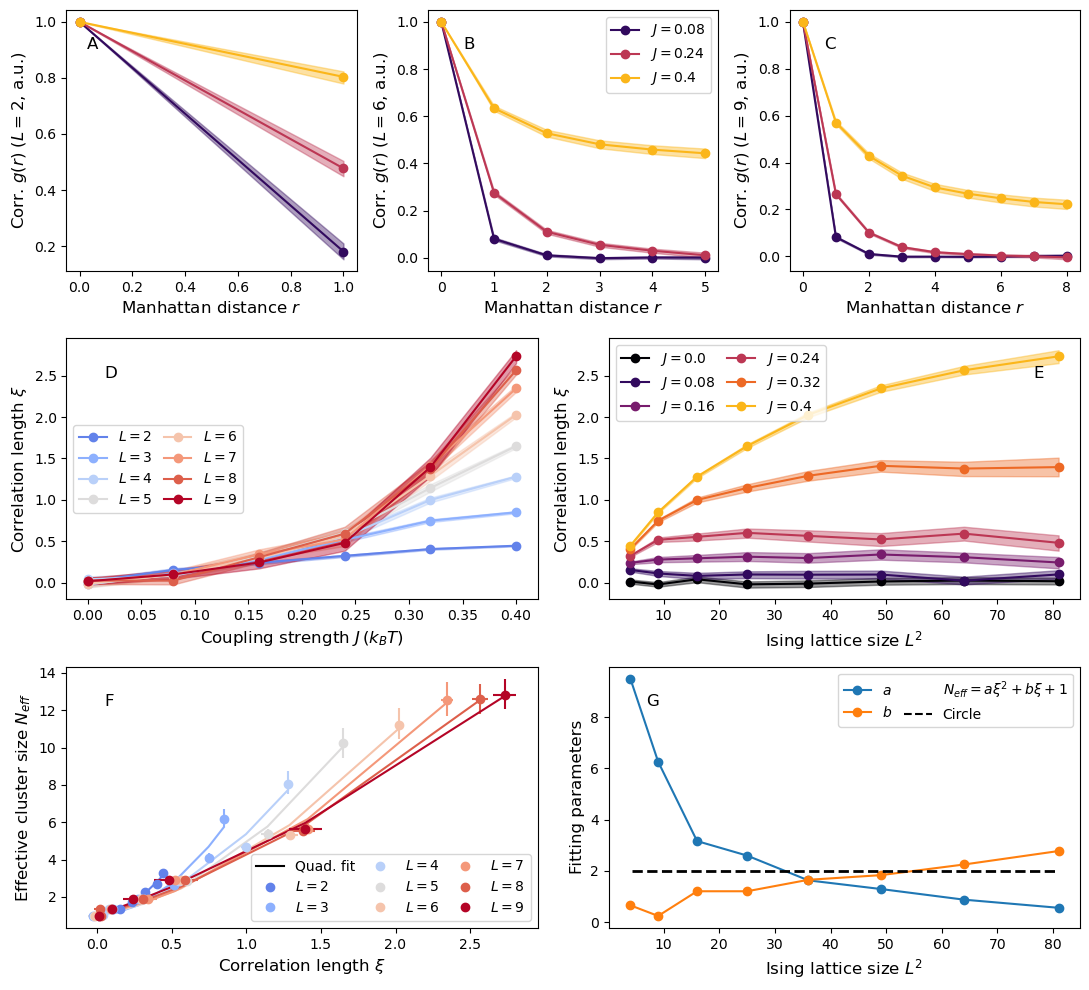

In [323]:
# preparation
fig_xi = plt.figure(figsize=(11,9))
gs = gridspec.GridSpec(3, 6)

ax1 = fig_xi.add_subplot(gs[0,0:2])
ax2 = fig_xi.add_subplot(gs[0,2:4])
ax3 = fig_xi.add_subplot(gs[0,4:])

ax4 = fig_xi.add_subplot(gs[1,:3])
ax5 = fig_xi.add_subplot(gs[1,3:])

ax6 = fig_xi.add_subplot(gs[2,:3])
ax7 = fig_xi.add_subplot(gs[2,3:])

# parameters; same as for estimating Neff
Ns = 1000
tf = 10
tc = tf + 1
st = 0.1
Nbs = 1000
alpha = 0.10
open_boundary = False


################################
## Compute correlation length ##
################################

all_xi = np.zeros((L_arr.size,J_arr.size))
xi_lb = np.zeros_like(all_xi)
xi_ub = np.zeros_like(all_xi)

handles = []

for l,L in enumerate(L_arr):
    print('L = ',L)
    for j,J in enumerate(J_arr):
        # get ensemble of Ising lattices
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,open_boundary=open_boundary)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
        
        g, dist = cross_corr(all_samples,L)
        all_xi[l,j] = np.sum(g*dist)/np.sum(g)
        
        # perform bootstrapping
        xi_bs = np.zeros(Nbs)
        g_bs = np.zeros((Nbs,dist.size))
        for n in range(Nbs):
            idx = np.random.choice(np.arange(Ns),size=Ns,replace=True)
            bs_sample = all_samples[idx]
            g_bs[n], dist_bs = cross_corr(bs_sample,L)
            xi_bs[n] = np.sum(g_bs[n]*dist_bs)/np.sum(g_bs[n])
            
        xi_lb[l,j] = np.percentile(xi_bs,100*alpha/2)
        xi_ub[l,j] = np.percentile(xi_bs,100*(1-alpha/2))
        
        # check the fit
        if L == L_arr[0] and j%2 == 1:
            lb = np.percentile(g_bs,100*alpha/2,axis=0)
            ub = np.percentile(g_bs,100*(1-alpha/2),axis=0)
            color = colormap_inferno(j/J_arr.size)
            ax1.plot(dist,g,'-o',label=f'$J={np.round(J,2)}$',color=color)
            ax1.fill_between(dist,lb,ub,color=color,alpha=0.4)
            ax1.set_ylabel(r'Cross-corr. $g(r)$ ($L='+str(L)+'$, a.u.)',size=12)
            
            handles.append(Line2D([], [], color=color, marker='o',label=f'$J={np.round(J,2)}$'))
            
        elif L == L_arr[int(L_arr.size/2)] and j%2 == 1:
            lb = np.percentile(g_bs,100*alpha/2,axis=0)
            ub = np.percentile(g_bs,100*(1-alpha/2),axis=0)
            color = colormap_inferno(j/J_arr.size)
            ax2.plot(dist,g,'-o',label=f'$J={np.round(J,2)}$',color=color)
            ax2.fill_between(dist,lb,ub,color=color,alpha=0.4)
            ax2.set_ylabel(r'Cross-corr. $g(r)$ ($L='+str(L)+'$, a.u.)',size=12)
            
        elif L == L_arr[-1] and j%2 == 1:
            lb = np.percentile(g_bs,100*alpha/2,axis=0)
            ub = np.percentile(g_bs,100*(1-alpha/2),axis=0)
            color = colormap_inferno(j/J_arr.size)
            ax3.plot(dist,g,'-o',label=f'$J={np.round(J,2)}$',color=color)
            ax3.fill_between(dist,lb,ub,color=color,alpha=0.4)
            ax3.set_ylabel(r'Cross-corr. $g(r)$ ($L='+str(L)+'$, a.u.)',size=12)

# formatting
text_list = ['A','B','C']
for i,ax in enumerate((ax1,ax2,ax3)):
    ax.set_xlabel(r'Manhattan distance $r$',size=12)
    if i == 0:
        ax.text(0.07,0.85,text_list[i],size=12,transform = ax.transAxes)
    else:
        ax.text(0.12,0.85,text_list[i],size=12,transform = ax.transAxes)
        
# formatting
# handles.append(Line2D([],[],color='k',label=r'Exp. fit'))
ax2.legend(handles=handles,fontsize=10,loc='upper right',columnspacing=0.8)

#############################
## Show correlation length ##
#############################

# show as a function of J
for l,L in enumerate(L_arr):
    color = colormap((l+1)/L_arr.size)
    ax4.plot(J_arr,all_xi[l,:],'-o',label=f'$L={L}$',color=color)
    ax4.fill_between(J_arr,xi_lb[l,:],xi_ub[l,:],color=color,alpha=0.4)
    
ax4.set_ylabel(r'Correlation length $\xi$',size=12)
ax4.set_xlabel(r'Coupling strength $J \, (k_B T)$',size=12)
ax4.legend(fontsize=10,ncol=2,columnspacing=0.8,loc='center left')
ax4.text(0.08,0.85,'D',size=12,transform = ax4.transAxes)

# show as a function of L
for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax5.plot(L_arr**2,all_xi[:,j],'-o',label=f'$J={np.round(J,2)}$',color=color)
    ax5.fill_between(L_arr**2,xi_lb[:,j],xi_ub[:,j],color=color,alpha=0.4)
    
ax5.set_xlabel(r'Ising lattice size $L^2$',size=12)
ax5.set_ylabel(r'Correlation length $\xi$',size=12)
ax5.legend(fontsize=10,ncol=2,columnspacing=0.8)
ax5.text(0.9,0.85,'E',size=12,transform = ax5.transAxes)

#################
## Neff vs. xi ##
#################

# polynomial fitting function
def poly_2d(x,a,b):
    return a*x**2 + b*x + 1

poly_parms = np.zeros((2,L_arr.size),dtype='float64')

handles = []
handles.append(Line2D([], [], color='k',label=f'Quad. fit'))

# show parametric plot of Neff versus xi^2
for l,L in enumerate(L_arr):
    # perform fit
    poly_parms[:,l], _ = curve_fit(poly_2d,all_xi[l],Neff_arr[l+1])

    color = colormap((l+1)/L_arr.size)
    ax6.errorbar(all_xi[l,:],Neff_arr[l+1,:],marker='o',ls='None',color=color,
                 xerr=np.array([all_xi[l,:]-xi_lb[l,:],xi_ub[l,:]-all_xi[l,:]]),
                 yerr=np.array([Neff_arr[l+1,:]-Neff_lb[l+1,:],Neff_ub[l+1,:]-Neff_arr[l+1,:]]))
    ax6.plot(all_xi[l],poly_2d(all_xi[l],*poly_parms[:,l]),color=color)
    
    handles.append(Line2D([], [], color=color, marker='o',linestyle='None',label=f'$L={L}$'))
    
ax6.set_xlabel(r'Correlation length $\xi$',size=12)
ax6.set_ylabel(r'Effective cluster size $N_{eff}$',size=12)
ax6.legend(handles=handles,fontsize=10,ncol=3,columnspacing=0.8,loc='lower right')
ax6.text(0.08,0.85,'F',size=12,transform = ax6.transAxes)

# show the fitting parameters as a function of L**2
handles = []
handles.append(Line2D([], [], color=colormap_aux(0), marker='o',label='$a$'))
handles.append(Line2D([], [], color=colormap_aux(1), marker='o',label='$b$'))
handles.append(Line2D([], [], linestyle='None',label=r'$N_{eff} = a\xi^2 + b\xi + 1$'))
handles.append(Line2D([], [], linestyle='--',color='k',label=r'Circle'))

ax7.plot(L_arr**2,poly_parms[0,:],'-o',color=colormap_aux(0))
ax7.plot(L_arr**2,poly_parms[1,:],'-o',color=colormap_aux(1))
#ax7.axhline(y=2,xmin=0.05,xmax=0.95,ls='--',color='k',linewidth=2.0)
ax7.set_xlabel(r'Ising lattice size $L^2$',size=12)
ax7.set_ylabel(r'Fitting parameters',size=12)
ax7.legend(handles = handles,ncol=3,fontsize=10,columnspacing=0.8)
ax7.text(0.08,0.85,'G',size=12,transform = ax7.transAxes)

plt.tight_layout()
plt.show()

In [328]:
fig_xi.savefig('Figures/xi_manhattan.pdf')

### Correlation length (Euclidean)

In [17]:
@numba.jit(nopython=True)
def cross_corr_euclidean(all_samples,L,bin_size):
    # for binning the distances
    max_dist = np.sqrt(2*(L//2)**2) 
    num_bins = int(max_dist/bin_size) + 1
    
    # prepare arrays
    g = np.zeros(num_bins,dtype='float64')
    dis_counts = np.zeros_like(g)
    
    dist = np.zeros(1,dtype='float64')
        
    # loop through all possible spin pairs
    for spin1 in range(L**2):
        x1,y1 = np.divmod(spin1,L)
        # start from spin1 to prevent double-counting
        for spin2 in range(spin1,L**2):
            x2,y2 = np.divmod(spin2,L)
            # compute Manhattan distance in a periodic lattice
            Dx = np.min(np.array([np.abs(x1-x2),L-np.abs(x1-x2)])) 
            Dy = np.min(np.array([np.abs(y1-y2),L-np.abs(y1-y2)]))
            dis = np.sqrt(Dx**2 + Dy**2)
            if dis >= 1.:
                dist = np.append(dist,dis)
            
            bin_idx = int(dis/bin_size)
            g[bin_idx] += np.corrcoef(np.vstack((all_samples[:,-1,x1,y1],all_samples[:,-1,x2,y2])))[0,1]
            dis_counts[bin_idx] += 1.

    # radial averaging
    for bn in range(num_bins):
        if dis_counts[bn] > 0:
            g[bn] /= dis_counts[bn]
            
    # only return non-empty bins and save every distance once
    return g[g!=0], np.unique(dist)

# exponential fit for extracting the correlation length
def exp_fit(r,xi):
    return np.exp(-r/xi)

L =  2


/home/ipausers/zewe/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1213369/2017205911.py:40: RuntimeWarning: overflow encountered in exp
  return np.exp(-r/xi)


L =  3
L =  4
L =  5
L =  6
L =  7
L =  8
L =  9


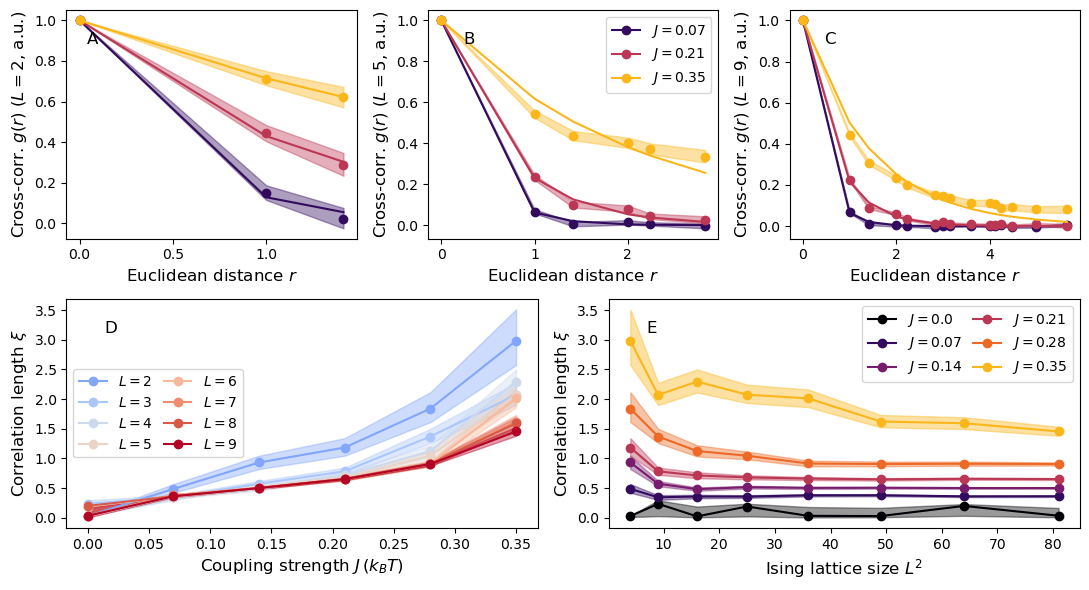

In [416]:
# preparation
fig_xi_eu = plt.figure(figsize=(11,6))
gs = gridspec.GridSpec(2, 6)

ax1 = fig_xi_eu.add_subplot(gs[0,0:2])
ax2 = fig_xi_eu.add_subplot(gs[0,2:4])
ax3 = fig_xi_eu.add_subplot(gs[0,4:])

ax4 = fig_xi_eu.add_subplot(gs[1,:3])
ax5 = fig_xi_eu.add_subplot(gs[1,3:])

# parameters
Ns = 500
tf = 15
tc = tf + 1
st = 0.1
Nbs = 1000
alpha = 0.10
open_boundary = False
bin_size = 0.1

L_arr = np.array([1,2,3,4,5,6,7,8,9]) # same as for Neff
J_arr = np.linspace(0,0.35,6) # or until 0.4

################################
## Compute correlation length ##
################################

all_xi = np.zeros((L_arr.size-1,J_arr.size))
xi_lb = np.zeros_like(all_xi)
xi_ub = np.zeros_like(all_xi)

handles = []

for l,L in enumerate(L_arr[1:]):
    print('L = ',L)
    for j,J in enumerate(J_arr):
        # get ensemble of Ising lattices
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,open_boundary=open_boundary)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
        
        g, dist = cross_corr_euclidean(all_samples,L,bin_size)
        all_xi[l,j],_ = curve_fit(exp_fit,dist,g) 
        
        # perform bootstrapping
        xi_bs = np.zeros(Nbs)
        g_bs = np.zeros((Nbs,dist.size))
        for n in range(Nbs):
            idx = np.random.choice(np.arange(Ns),size=Ns,replace=True)
            bs_sample = all_samples[idx]
            g_bs[n], dist_bs = cross_corr_euclidean(bs_sample,L,bin_size)
            xi_bs[n],_ = curve_fit(exp_fit,dist_bs,g_bs[n]) 
            
        xi_lb[l,j] = np.percentile(xi_bs,100*alpha/2)
        xi_ub[l,j] = np.percentile(xi_bs,100*(1-alpha/2))
        
        # check the fit
        if L == L_arr[1] and j%2 == 1:
            lb = np.percentile(g_bs,100*alpha/2,axis=0)
            ub = np.percentile(g_bs,100*(1-alpha/2),axis=0)
            color = colormap_inferno(j/J_arr.size)
            ax1.plot(dist,g,'o',label=f'$J={np.round(J,2)}$',color=color)
            ax1.plot(dist,exp_fit(dist,all_xi[l,j]),color=color)
            ax1.fill_between(dist,lb,ub,color=color,alpha=0.4)
            ax1.set_ylabel(r'Cross-corr. $g(r)$ ($L='+str(L)+'$, a.u.)',size=12)
            
            handles.append(Line2D([], [], color=color, marker='o',label=f'$J={np.round(J,2)}$'))
            
        elif L == L_arr[int(L_arr.size/2)] and j%2 == 1:
            lb = np.percentile(g_bs,100*alpha/2,axis=0)
            ub = np.percentile(g_bs,100*(1-alpha/2),axis=0)
            color = colormap_inferno(j/J_arr.size)
            ax2.plot(dist,g,'o',label=f'$J={np.round(J,2)}$',color=color)
            ax2.plot(dist,exp_fit(dist,all_xi[l,j]),color=color)
            ax2.fill_between(dist,lb,ub,color=color,alpha=0.4)
            ax2.set_ylabel(r'Cross-corr. $g(r)$ ($L='+str(L)+'$, a.u.)',size=12)
            
        elif L == L_arr[-1] and j%2 == 1:
            lb = np.percentile(g_bs,100*alpha/2,axis=0)
            ub = np.percentile(g_bs,100*(1-alpha/2),axis=0)
            color = colormap_inferno(j/J_arr.size)
            ax3.plot(dist,g,'o',label=f'$J={np.round(J,2)}$',color=color)
            ax3.plot(dist,exp_fit(dist,all_xi[l,j]),color=color)
            ax3.fill_between(dist,lb,ub,color=color,alpha=0.4)
            ax3.set_ylabel(r'Cross-corr. $g(r)$ ($L='+str(L)+'$, a.u.)',size=12)

# formatting
text_list = ['A','B','C']
for i,ax in enumerate((ax1,ax2,ax3)):
    ax.set_xlabel(r'Euclidean distance $r$',size=12)
    if i == 0:
        ax.text(0.07,0.85,text_list[i],size=12,transform = ax.transAxes)
    else:
        ax.text(0.12,0.85,text_list[i],size=12,transform = ax.transAxes)
        
# formatting
# handles.append(Line2D([],[],color='k',label=r'Exp. fit'))
ax2.legend(handles=handles,fontsize=10,loc='upper right',columnspacing=0.8)

#############################
## Show correlation length ##
#############################

# show as a function of J
for l,L in enumerate(L_arr[1:]):
    color = colormap((l+2)/L_arr.size)
    ax4.plot(J_arr,all_xi[l,:],'-o',label=f'$L={L}$',color=color)
    ax4.fill_between(J_arr,xi_lb[l,:],xi_ub[l,:],color=color,alpha=0.4)
    
ax4.set_ylabel(r'Correlation length $\xi$',size=12)
ax4.set_xlabel(r'Coupling strength $J \, (k_B T)$',size=12)
ax4.legend(fontsize=10,ncol=2,columnspacing=0.8,loc='center left')
ax4.text(0.08,0.85,'D',size=12,transform = ax4.transAxes)

# show as a function of L
for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax5.plot(L_arr[1:]**2,all_xi[:,j],'-o',label=f'$J={np.round(J,2)}$',color=color)
    ax5.fill_between(L_arr[1:]**2,xi_lb[:,j],xi_ub[:,j],color=color,alpha=0.4)
    
ax5.set_xlabel(r'Ising lattice size $L^2$',size=12)
ax5.set_ylabel(r'Correlation length $\xi$',size=12)
ax5.legend(fontsize=10,ncol=2,columnspacing=0.8)
ax5.text(0.08,0.85,'E',size=12,transform = ax5.transAxes)

plt.tight_layout()
plt.show()

In [417]:
fig_xi_eu.savefig('Figures/xi_eu.pdf')

[3.2688379  2.01134556]


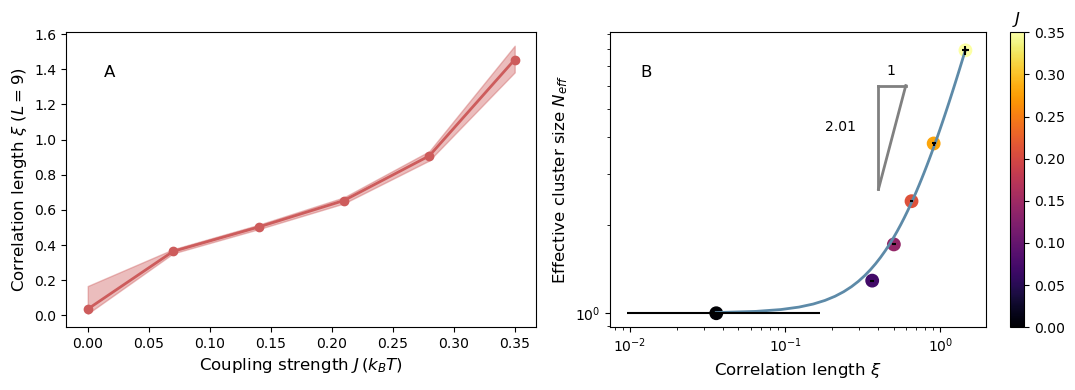

In [418]:
fig_xi_main = plt.figure(figsize=(11,4))
gs = gridspec.GridSpec(1, 2)

ax1 = fig_xi_main.add_subplot(gs[0,0])
ax2 = fig_xi_main.add_subplot(gs[0,1])

# show correlation length for largest lattice
ax1.plot(J_arr,all_xi[-1,:],'-o',color=my_red,linewidth=2.)
ax1.fill_between(J_arr,xi_lb[-1,:],xi_ub[-1,:],color=my_red,alpha=0.4)
ax1.set_ylabel(r'Correlation length $\xi$ ($L=9$)',size=12)
ax1.set_xlabel(r'Coupling strength $J \, (k_B T)$',size=12)
ax1.text(0.08,0.85,'A',size=12,transform = ax1.transAxes)

# power law fitting function
def power_law(x,a,q):
    return a*x**q + 1

popt,pcov = curve_fit(power_law,all_xi[-1,:],Neff_arr[-1,:])
q = popt[1]
print(popt)

# ax2.scatter(all_xi[-1,:],Neff_arr[-1,:],c=J_arr[:],cmap=colormap_inferno,s=20)
im = ax2.scatter(all_xi[-1,:],Neff_arr[-1,:],c=J_arr[:],cmap=colormap_inferno,s=80)
cbar = fig_xi_main.colorbar(im, ax=ax2)
xi_plot = np.linspace(all_xi[-1,0],all_xi[-1,-1])
ax2.plot(xi_plot,power_law(xi_plot,*popt),color=my_blue,linewidth=2.)
ax2.errorbar(all_xi[-1,:],Neff_arr[-1,:],marker='None',ls='None',color='k',
                 xerr=np.array([all_xi[-1,:]-xi_lb[-1,:],xi_ub[-1,:]-all_xi[-1,:]]),
                 yerr=np.array([Neff_arr[-1,:]-Neff_lb[-1,:],Neff_ub[-1,:]-Neff_arr[-1,:]]))

ax2.plot(np.array([0.4,0.6]),np.array([6.,6.]),color='grey',linewidth=2.)
ax2.plot(np.array([0.4,0.4]),np.array([6/(1.5**q),6.]),color='grey',linewidth=2.)
ax2.plot(np.array([0.4,0.6]),np.array([6/(1.5**q),6.]),color='grey',linewidth=2.)

ax2.text(0.18,4.2,f'{np.round(q,2)}')
ax2.text(0.45,6.5,f'1')
ax2.text(0.08,0.85,'B',size=12,transform = ax2.transAxes)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_xlabel(r'Correlation length $\xi$',size=12)
ax2.set_ylabel(r'Effective cluster size $N_{eff}$',size=12)

# cax = fig.add_axes([ax2.get_position().x1+0.03,ax2.get_position().y0,0.05,ax2.get_position().height])
# cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_title(r'$J$',size=12)

plt.tight_layout()
plt.show()

fig_xi_main.savefig('Figures/xi_main.pdf')

### Correlation length (Euclidean, wrong)

In [56]:
@numba.jit(nopython=True)
def indices_distinct_vals(arr):
    '''
    Numba-compatible function for finding the indices of distinct values in an array.
    
    Parameters
    ----------
    arr: ndarray
        one-dimensional numpy array
    
    Returns
    ----------
    unique: ndarray
        unique values in arr, i.e., np.unique(arr)
    indices: ndarray
        indices corresponding to the values in unique
    '''
    
    # sort the array and extract index when each distinct value occurs for the first time
    indices = np.searchsorted(np.sort(arr), np.unique(arr))
    
    # remove the first zero and add the final index manually
    return np.unique(arr), np.append(indices[1:],arr.size-1)

@numba.jit(nopython=True)
def cross_correlation(ensemble,L,alpha=0.05):
    '''
    Computes the spatial cross-correlation for an ensemble of spins.
    
    Parameters
    ----------
    ensemble: List
        ensemble of square lattices. Has dimensions (samples,time,L,L)
    L: int
        linear dimension of the lattice
    
    Returns
    ----------
    r_uniq: ndarray
        array of distinct euclidean separations in the lattice. Notice that this is
        less than L/2
    mean_cc: ndarray
        ensemble cross-correlation. Correlations are averaged over spins and 
        radial distance
    std_cc: ndarray
        ensemble standard deviation around mean_cc
    
    '''
    # set up arrays
    r_arr = np.zeros(int((L**2)*(L**2 - 1)/2),dtype='float64')
    cc = np.zeros_like(r_arr)
    counter = 0
    
    # find the cross-correlation between a spin and every other spin
    for spin1 in range(L**2):
        # determine coordinates of spin1
        m1,n1 = np.divmod(spin1,L)
        
        # only consider the spins that have not been considered
        for spin2 in range(spin1+1,L**2):
            # determine position of spin2
            m2,n2 = np.divmod(spin2,L)
            
            # compute distance and cross-correlation, and update counter
            r_arr[counter] = np.sqrt((m2-m1)**2 + (n2-n1)**2)
            cc[counter] = np.corrcoef(np.vstack((ensemble[:,-1,m1,n1],ensemble[:,-1,m2,n2])))[0,1]
            counter += 1
            
    ######################
    ## Radial averaging ##
    ######################
    
    # extract distinct distances and their indices
    r_uniq, indices_uniq = indices_distinct_vals(r_arr)
    
    # sort the cross-correlations based on r
    indices_sort = np.argsort(r_arr)
    sorted_cc = cc[indices_sort]
    
    # arrays to store sample statistics
    mean_cc = np.zeros_like(r_uniq,dtype='float64')
    lb_cc = np.zeros_like(mean_cc)
    ub_cc = np.zeros_like(mean_cc)
    
    # prepare looping through unique indices
    idx1 = 0
    
    # actual averaging per distinct values
    for i,idx in enumerate(indices_uniq):
        mean_cc[i] = np.mean(sorted_cc[idx1:idx])
        lb_cc[i] = np.percentile(sorted_cc[idx1:idx],100*alpha/2)
        ub_cc[i] = np.percentile(sorted_cc[idx1:idx],100*(1-alpha/2))
        # std_cc[i] = np.std(sorted_cc[idx1:idx])
        idx1 = idx
    
    # ensure that only reasonable correlation lengths are considered
    r_mask = r_uniq <= L/2.
    
    # return the distances, cross-correlation and its standard deviation
    return r_uniq[r_mask], mean_cc[r_mask], lb_cc[r_mask], ub_cc[r_mask]

# exponential fit for extracting the correlation length
def exp_fit(r,xi):
    return np.exp(-r/xi)

L =  3


/tmp/ipykernel_2972345/3911794996.py:66: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  cc[counter] = np.corrcoef(np.vstack((ensemble[:,-1,m1,n1],ensemble[:,-1,m2,n2])))[0,1]


  xi:  0.21093397210951595


/home/ipausers/zewe/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  xi:  0.3869175971618764
  xi:  0.5834906940588359
  xi:  0.7670155735926913
  xi:  1.2859031965857206
  xi:  2.221734342799092
L =  4
  xi:  0.19052467410194035
  xi:  0.36138202934828084
  xi:  0.500059230130989
  xi:  0.7178247643350557
  xi:  1.130022677022939
  xi:  1.9661185631291045
L =  5
  xi:  0.1248058394529446
  xi:  0.3695503147249536
  xi:  0.4929727300727526
  xi:  0.6790617236557176
  xi:  0.9912205913064007
  xi:  1.8688322037112464
L =  6
  xi:  0.17210527661896619


/tmp/ipykernel_2972345/3911794996.py:104: RuntimeWarning: overflow encountered in exp
  return np.exp(-r/xi)


  xi:  0.3598431018641069
  xi:  0.5120501117493389
  xi:  0.6267219711251881
  xi:  0.9393446047875814
  xi:  1.7190272694823163
L =  7
  xi:  0.16213967451021627
  xi:  0.36959660821905527
  xi:  0.5000550789639255
  xi:  0.6545450142337608
  xi:  0.9089190084081659
  xi:  1.5982800771976364
L =  8
  xi:  0.16769559586584393
  xi:  0.36684515704889165
  xi:  0.4898202463909279
  xi:  0.6546374697423396
  xi:  0.8786855043948285
  xi:  1.55677550587177
L =  9
  xi:  0.15843486743013263
  xi:  0.36619596658778186
  xi:  0.5007922497226078
  xi:  0.6472689145473035
  xi:  0.8974235476442066
  xi:  1.545980469186624


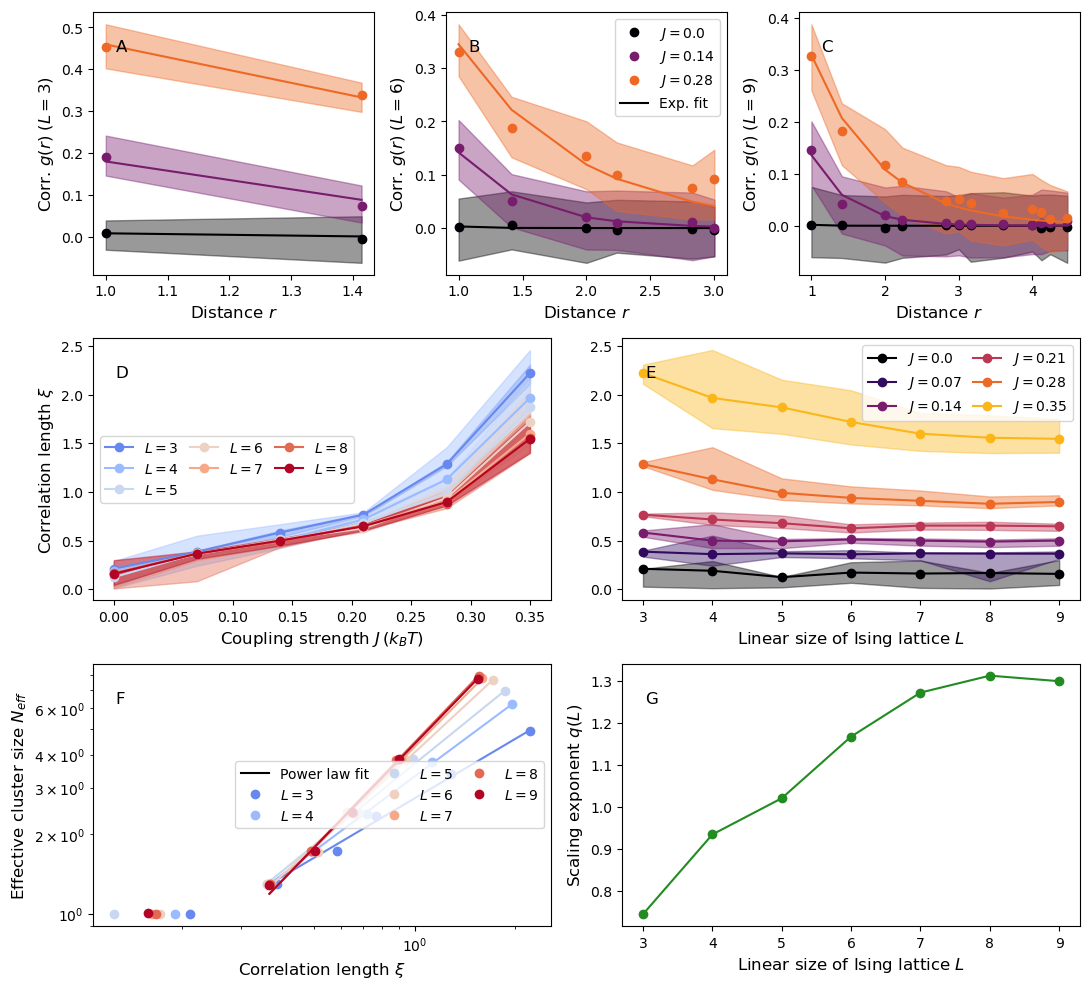

In [57]:
# preparation
fig_xi = plt.figure(figsize=(11,10))
gs = gridspec.GridSpec(3, 6)

ax1 = fig_xi.add_subplot(gs[0,0:2])
ax2 = fig_xi.add_subplot(gs[0,2:4])
ax3 = fig_xi.add_subplot(gs[0,4:])

ax4 = fig_xi.add_subplot(gs[1,:3])
ax5 = fig_xi.add_subplot(gs[1,3:])

ax6 = fig_xi.add_subplot(gs[2,:3])
ax7 = fig_xi.add_subplot(gs[2,3:])

# parameters; same as for estimating Neff
Ns = 1000
Nbs = 1000
alpha = 0.05
tf = 30
tc = 5
st = 0.1
cf = 100
open_boundary = False

################################
## Compute correlation length ##
################################

large_L_arr = L_arr[L_arr > 2] # only consider large enough lattices

all_xi = np.zeros((large_L_arr.size,J_arr.size),dtype='float64')
lb_xi = np.zeros_like(all_xi)
ub_xi = np.zeros_like(all_xi)

handles = []

# consider various lattice size
for l,L in enumerate(large_L_arr):
    print('L = ',L)
    for j,J in enumerate(J_arr):
        # obtain an ensemble and sample
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=cf,open_boundary=open_boundary)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
        
        # extract cross-correlation
        r_arr, mean_cc, lb_cc, ub_cc = cross_correlation(all_samples,L)

        # extract correlation length and error bar
        popt,_ = curve_fit(exp_fit,r_arr,mean_cc)
        all_xi[l,j] = popt[0]
        print('  xi: ',popt[0])
        
        Nr = r_arr.size
        bs_xi = np.zeros(Nbs)
        
        for n in range(Nbs):
            idx = np.random.choice(np.arange(Nr),size=Nr,replace=True)
            bs_r = r_arr[idx]
            bs_g = mean_cc[idx]
            bs_xi[n], _ = curve_fit(exp_fit,bs_r,bs_g)
            
        lb_xi[l,j] = np.percentile(bs_xi,100*alpha/2)
        ub_xi[l,j] = np.percentile(bs_xi,100*(1-alpha/2))
        
        # check the fit
        if L == large_L_arr[0] and j%2 == 0:
            color = colormap_inferno(j/J_arr.size)
            ax1.plot(r_arr,mean_cc,'o',label=f'$J={np.round(J,2)}$',color=color)
            ax1.fill_between(r_arr,lb_cc,ub_cc,color=color,alpha=0.4)
            ax1.plot(r_arr,exp_fit(r_arr,*popt),color=color)
            ax1.set_ylabel(r'Corr. $g(r)$ ($L='+str(L)+'$)',size=12)
            
            handles.append(Line2D([], [], color=color, marker='o',linestyle='None',label=f'$J={np.round(J,2)}$'))
            
        elif L == large_L_arr[int(large_L_arr.size/2)] and j%2 == 0:
            color = colormap_inferno(j/J_arr.size)
            ax2.plot(r_arr,mean_cc,'o',label=f'$J={np.round(J,2)}$',color=color)
            ax2.fill_between(r_arr,lb_cc,ub_cc,color=color,alpha=0.4)
            ax2.plot(r_arr,exp_fit(r_arr,*popt),color=color)
            ax2.set_ylabel(r'Corr. $g(r)$ ($L='+str(L)+'$)',size=12)
            
        elif L == large_L_arr[-1] and j%2 == 0:
            color = colormap_inferno(j/J_arr.size)
            ax3.plot(r_arr,mean_cc,'o',label=f'$J={np.round(J,2)}$',color=color)
            ax3.fill_between(r_arr,lb_cc,ub_cc,color=color,alpha=0.4)
            ax3.plot(r_arr,exp_fit(r_arr,*popt),color=color)
            ax3.set_ylabel(r'Corr. $g(r)$ ($L='+str(L)+'$)',size=12)

# formatting
text_list = ['A','B','C']
for i,ax in enumerate((ax1,ax2,ax3)):
    ax.set_xlabel(r'Distance $r$',size=12)
    ax.text(0.08,0.85,text_list[i],size=12,transform = ax.transAxes)
        
# formatting
handles.append(Line2D([],[],color='k',label=r'Exp. fit'))
ax2.legend(handles=handles,fontsize=10,loc='upper right',columnspacing=0.8)

#############################
## Show correlation length ##
#############################

# show as a function of J
for l,L in enumerate(large_L_arr):
    color = colormap((l+1)/large_L_arr.size)
    ax4.plot(J_arr,all_xi[l,:],'-o',label=f'$L={L}$',color=color)
    ax4.fill_between(J_arr,lb_xi[l,:],ub_xi[l,:],color=color,alpha=0.4)
    
ax4.set_ylabel(r'Correlation length $\xi$',size=12)
ax4.set_xlabel(r'Coupling strength $J \, (k_B T)$',size=12)
ax4.legend(fontsize=10,ncol=3,columnspacing=0.8,loc='center left')
ax4.text(0.05,0.85,'D',size=12,transform = ax4.transAxes)

# show as a function of L
for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax5.plot(large_L_arr,all_xi[:,j],'-o',label=f'$J={np.round(J,2)}$',color=color)
    ax5.fill_between(large_L_arr,lb_xi[:,j],ub_xi[:,j],color=color,alpha=0.4)
    
ax5.set_xlabel(r'Linear size of Ising lattice $L$',size=12)
ax5.legend(fontsize=10,ncol=2,columnspacing=0.8)
ax5.text(0.05,0.85,'E',size=12,transform = ax5.transAxes)

#################
## Neff vs. xi ##
#################

# power law fitting function
def power_law(x,a,b):
    return a*(x**b)

# fitting parms
pl_parms = np.zeros((2,large_L_arr.size),dtype='float64')
pl_sds = np.zeros_like(pl_parms)

handles = []
handles.append(Line2D([], [], color='k',label=f'Power law fit'))

# show parametric plot of Neff versus xi^2
len_diff = int(np.size(L_arr) - np.size(large_L_arr))
for l,L in enumerate(large_L_arr):
    # perform fit
    popt,pcov = curve_fit(power_law,all_xi[l,1:],Neff_arr[l+len_diff,1:])
    pl_parms[:,l] = popt
    pl_sds[:,l] = [np.sqrt(pcov[i,i]) for i in range(2)]

    color = colormap((l+1)/large_L_arr.size)
    # ax6.errorbar(all_xi[l,:],Neff_arr[l+len_diff,:],lolims=Neff_lb[l+len_diff,:],uplims=Neff_ub[l+len_diff,:],
    #             xlolims=lb_xi[l,:], xuplims=ub_xi[l,:])
    ax6.loglog(all_xi[l,:],Neff_arr[l+len_diff,:],'o',color=color,label=f'$L={L}$')
    ax6.loglog(all_xi[l,1:],power_law(all_xi[l,1:],*popt),color=color)
    
    handles.append(Line2D([], [], color=color, marker='o',linestyle='None',label=f'$L={L}$'))
    
ax6.set_xlabel(r'Correlation length $\xi$',size=12)
ax6.set_ylabel(r'Effective cluster size $N_{eff}$',size=12)
ax6.legend(handles=handles,fontsize=10,ncol=3,columnspacing=0.8,loc='center right')
ax6.text(0.05,0.85,'F',size=12,transform = ax6.transAxes)

# show the scaling exponent as a function of L
ax7.plot(large_L_arr,pl_parms[1,:],'-o',color=my_green)
ax7.set_xlabel(r'Linear size of Ising lattice $L$',size=12)
ax7.set_ylabel(r'Scaling exponent $q(L)$',size=12)
ax7.text(0.05,0.85,'G',size=12,transform = ax7.transAxes)

plt.tight_layout()
plt.show()

In [58]:
fig_xi.savefig('Figures/xi.pdf')

### Effective number of clusters

L =  1
L =  2
L =  3
L =  4
L =  5
L =  6
L =  7
L =  8
L =  9


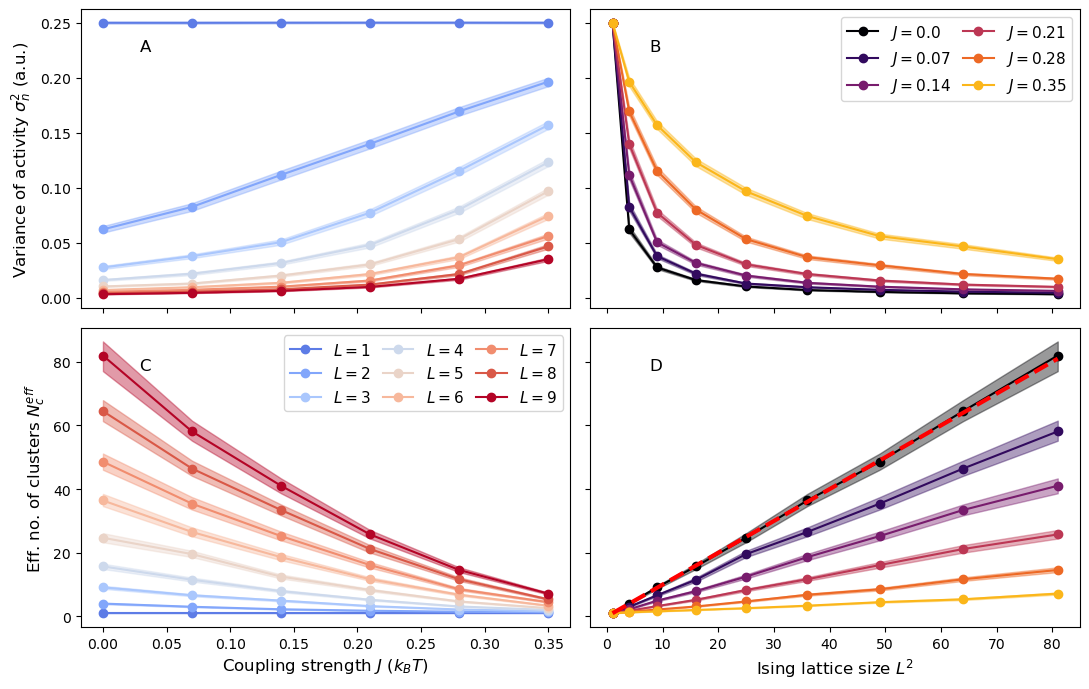

In [413]:
# preparation
fig_NcEff = plt.figure(figsize=(11,7))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1],sharey=ax1)
ax3 = plt.subplot(gs[1,0],sharex=ax1)
ax4 = plt.subplot(gs[1,1],sharex=ax2,sharey=ax3)

# parameters 
Ns = 2500
tf = 5
tc = tf + 1
st = 0.05
open_boundary = False
c0 = 100
cf = 100

Nbs = 1000
alpha = 0.05

L_arr = np.array([1,2,3,4,5,6,7,8,9]) # same as for Neff
J_arr = np.linspace(0,0.35,6)

# arrays to store results
Nc_eff = np.zeros((L_arr.size,J_arr.size),dtype='float64')
Nc_eff_lb = np.zeros_like(Nc_eff)
Nc_eff_ub = np.zeros_like(Nc_eff)

noise_ampl = np.zeros_like(Nc_eff)
noise_ampl_lb = np.zeros_like(Nc_eff)
noise_ampl_ub = np.zeros_like(Nc_eff)

noise_ampl_1 = np.zeros(J_arr.size)

all_baseline_act = np.zeros((J_arr.size,Ns))

############################
## Obtain noise amplitude ##
############################

for l,L in enumerate(L_arr):
    print('L = ',L)
    for j,J in enumerate(J_arr):
        # simulate an ensemble
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=cf,c0=c0,open_boundary=open_boundary)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
        noise_ampl[l,j] = np.var(0.5*np.mean(all_samples[:,-1,:,:],axis=(-1,-2)) + 0.5) # ensemble of activities at eql
            
        Nc_eff[l,j] = noise_ampl[0,j]/noise_ampl[l,j]
        
        if L == 1: # baseline samples for bootstrappin'
            all_baseline_act[j] = 0.5*np.mean(all_samples[:,-1,:,:],axis=(-1,-2)) + 0.5
        
        # bootstrappin'
        bs_sample_Nc_eff = np.zeros(Nbs)
        bs_sample_var = np.zeros(Nbs)
        for n in range(Nbs):
            # resample
            idx = np.random.choice(np.arange(Ns),size=Ns,replace=True)
            bs_sample_var[n] = np.var(0.5 + 0.5*np.mean(all_samples[idx,-1],axis=(-1,-2)))
            bs_sample_Nc_eff[n] = np.var(all_baseline_act[j,idx])/bs_sample_var[n]
        
        # obtain lower and upper bounds
        noise_ampl_lb[l,j] = np.percentile(bs_sample_var,100*alpha/2)
        noise_ampl_ub[l,j] = np.percentile(bs_sample_var,100*(1-alpha/2))
        
        Nc_eff_lb[l,j] = np.percentile(bs_sample_Nc_eff,100*alpha/2)
        Nc_eff_ub[l,j] = np.percentile(bs_sample_Nc_eff,100*(1-alpha/2))
            
    # plot as functions of J
    color = colormap((l+1)/L_arr.size)
    ax1.plot(J_arr,noise_ampl[l],'-o',color=color,label=f'$L={L}$')
    ax1.fill_between(J_arr,noise_ampl_lb[l],noise_ampl_ub[l],color=color,alpha=0.4)
    
    ax3.plot(J_arr,Nc_eff[l],'-o',color=color,label=f'$L={L}$')
    ax3.fill_between(J_arr,Nc_eff_lb[l],Nc_eff_ub[l],color=color,alpha=0.4)

# plot as functions of L^2
for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax2.plot(L_arr**2,noise_ampl[:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax2.fill_between(L_arr**2,noise_ampl_lb[:,j],noise_ampl_ub[:,j],color=color,alpha=0.4)
    
    ax4.plot(L_arr**2,Nc_eff[:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax4.fill_between(L_arr**2,Nc_eff_lb[:,j],Nc_eff_ub[:,j],color=color,alpha=0.4)


################
## Formatting ##
################

text_list = ['A','B','C','D']
for i,ax in enumerate((ax1,ax2,ax3,ax4)):
    ax.text(0.12,0.86,text_list[i],size=12,transform = ax.transAxes)

ax1.set_ylabel(r'Variance of activity $\sigma_n^2$ (a.u.)',size=12)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2.legend(fontsize=11,ncol=2,columnspacing=0.8,loc='upper right')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)

ax3.set_ylabel(r'Eff. no. of clusters $N_c^{eff}$',size=12)
ax3.set_xlabel(r'Coupling strength $J$ ($k_B T$)',size=12)
ax3.legend(fontsize=11,ncol=3,columnspacing=0.8,loc='upper right')

ax4.plot([L_arr[0]**2,L_arr[-1]**2],[L_arr[0]**2,L_arr[-1]**2],'--',color='r',linewidth=3.0)
ax4.set_xlabel(r'Ising lattice size $L^2$',size=12)
plt.setp(ax4.get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

In [420]:
fig_NcEff.savefig('Figures/NcEff.pdf')

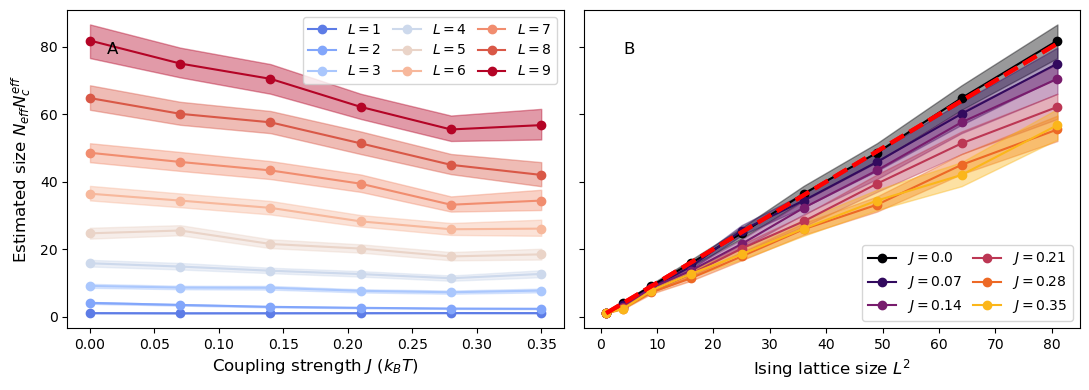

In [415]:
# preparation
fig_eff_mwc = plt.figure(figsize=(11,4))

# create subplots
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1],sharey=ax1)

# plot as functions of J
for l,L in enumerate(L_arr):
    color = colormap((l+1)/L_arr.size)
    ax1.plot(J_arr,Neff_arr[l]*Nc_eff[l],'-o',color=color,label=f'$L={L}$')
    ax1.fill_between(J_arr,Nc_eff_lb[l]*Neff_lb[l],Nc_eff_ub[l]*Neff_ub[l],color=color,alpha=0.4)
    
ax1.set_ylabel(r'Estimated size $N_{eff} N_c^{eff}$',size=12)
ax1.set_xlabel(r'Coupling strength $J$ ($k_B T$)',size=12)
ax1.legend(fontsize=10,ncol=3,columnspacing=0.8,loc='upper right')
ax1.text(0.08,0.86,'A',size=12,transform = ax1.transAxes)
    
# plot as functions of L^2
for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax2.plot(L_arr**2,Neff_arr[:,j]*Nc_eff[:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax2.fill_between(L_arr**2,Nc_eff_lb[:,j]*Neff_lb[:,j],Nc_eff_ub[:,j]*Neff_ub[:,j],color=color,alpha=0.4)

ax2.plot([L_arr[0]**2,L_arr[-1]**2],[L_arr[0]**2,L_arr[-1]**2],'--',color='r',linewidth=3.0)

ax2.plot([L_arr[0]**2,L_arr[-1]**2],[L_arr[0]**2,L_arr[-1]**2],'--',color='r',linewidth=3.0)
ax2.set_xlabel(r'Ising lattice size $L^2$',size=12)
ax2.legend(fontsize=10,ncol=2,columnspacing=0.8,loc='lower right')
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.text(0.08,0.86,'B',size=12,transform = ax2.transAxes)

plt.tight_layout()
plt.show()

In [419]:
fig_eff_mwc.savefig('Figures/eff_mwc.pdf')

### Response kernel

L =  2


/tmp/ipykernel_2861916/2256605852.py:6: RuntimeWarning: overflow encountered in exp
  return G*(1-np.exp(-t/tau_r))


L =  4


/home/ipausers/zewe/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


L =  6
L =  8


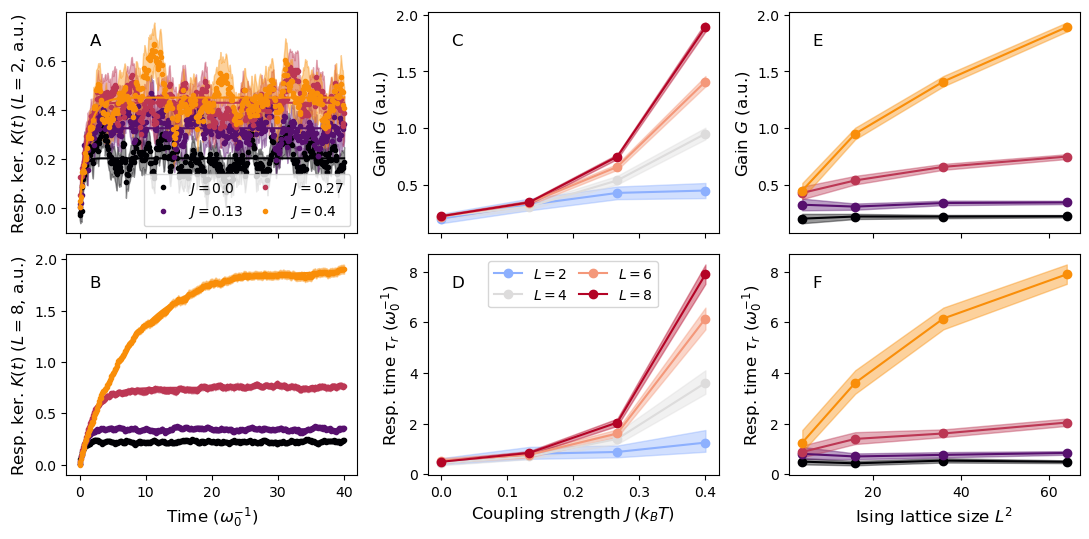

In [74]:
# preparation
fig_rk_ising_na = plt.figure(figsize=(11,5.5))

# nonadaptive response kernel
def rk_star(t,G,tau_r):
    return G*(1-np.exp(-t/tau_r))

# create subplots
gs = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0],sharex=ax1)
ax3 = plt.subplot(gs[0,1])
ax4 = plt.subplot(gs[1,1],sharex=ax3)
ax5 = plt.subplot(gs[0,2],sharey=ax3)
ax6 = plt.subplot(gs[1,2],sharex=ax5,sharey=ax4)

Ns = 3000 # 5000
tf = 43
tc = 3
st = 0.1
L = 3
c0 = 100
cf = 90
Nbs = 1000
alpha = 0.32
open_boundary = True

L_arr = np.array([2,4,6,8])
J_arr = np.linspace(0.,0.4,4)

rk_parms = np.zeros((2,L_arr.size,J_arr.size),dtype='float64')
rk_lb = np.zeros_like(rk_parms)
rk_ub = np.zeros_like(rk_parms)
handles = []

for l,L in enumerate(L_arr):
    print('L = ',L)
    for j,J in enumerate(J_arr):
        # obtain an ensemble and sample
        ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=cf,c0=c0,open_boundary=open_boundary)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
        time_s = t_grid[t_grid >= tc] - tc

        if l == 0 and j == 0:
            all_responses = np.zeros((Ns,L_arr.size,J_arr.size,time_s.size),dtype='float64')
            mean_response = np.zeros((L_arr.size,J_arr.size,time_s.size),dtype='float64')
        
        # find response kernel
        all_responses[:,l,j] = 0.5*np.mean(all_samples[:,t_grid>=tc] - np.expand_dims(all_samples[:,int(tc/st)-1],axis=1),axis=(-1,-2))/np.log(c0/cf)
        mean_response[l,j] = np.mean(all_responses[:,l,j],axis=0)

        # fitting and bootstrappin'
        rk_parms[:,l,j], rk_lb[:,l,j], rk_ub[:,l,j], bs_parms = bs_fitting(time_s,all_responses[:,l,j],rk_star,Nbs,alpha=alpha)
    
        if L == L_arr[0]:
            # show the response kernels for a given L
            lb, ub, _ = bs_ci(time_s,all_responses[:,l,j],Nbs,alpha=alpha)

            color = colormap_inferno(j/J_arr.size)
            ax1.plot(time_s,mean_response[l,j],'.',color=color,label=f'$J={np.round(J,2)}$')
            ax1.fill_between(time_s,lb,ub,color=color,alpha=0.4)
            ax1.plot(time_s,rk_star(time_s,*rk_parms[:,l,j]),color=color)
            ax1.set_ylabel(f'Resp. ker. $K(t)$ ($L={L}$, a.u.)',size=12)

        elif L == L_arr[-1]:
            # show the response kernels for a given L
            lb, ub, _ = bs_ci(time_s,all_responses[:,l,j],Nbs,alpha=alpha)

            color = colormap_inferno(j/J_arr.size)
            ax2.plot(time_s,mean_response[l,j],'.',color=color,label=f'$J={np.round(J,2)}$')
            ax2.fill_between(time_s,lb,ub,color=color,alpha=0.4)
            ax2.plot(time_s,rk_star(time_s,*rk_parms[:,l,j]),color=color)
            ax2.set_ylabel(f'Resp. ker. $K(t)$ ($L={L}$, a.u.)',size=12)
            ax2.set_xlabel(r'Time ($\omega_0^{-1}$)',size=12)

# show the gain and response time as functions of J
for l,L in enumerate(L_arr):
    color = colormap((l+1)/L_arr.size)
    ax3.plot(J_arr,rk_parms[0,l,:],'-o',color=color,label=f'$L={L}$')
    ax3.fill_between(J_arr,rk_lb[0,l,:],rk_ub[0,l,:],color=color,alpha=0.4)
    
    ax4.plot(J_arr,rk_parms[1,l,:],'-o',color=color,label=f'$L={L}$')
    ax4.fill_between(J_arr,rk_lb[1,l,:],rk_ub[1,l,:],color=color,alpha=0.4)
    
# show the gain and response time as functions of L^2
for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax5.plot(L_arr**2,rk_parms[0,:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax5.fill_between(L_arr**2,rk_lb[0,:,j],rk_ub[0,:,j],color=color,alpha=0.4)
    
    ax6.plot(L_arr**2,rk_parms[1,:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax6.fill_between(L_arr**2,rk_lb[1,:,j],rk_ub[1,:,j],color=color,alpha=0.4)

# formatting
for ax in (ax1,ax3,ax5):
    plt.setp(ax.get_xticklabels(), visible=False)

ax1.legend(fontsize=10,ncol=2,columnspacing=0.6,loc='lower right')
ax4.legend(fontsize=10,loc='upper center',ncol=2,columnspacing=0.8)
# ax6.legend(fontsize=10,loc='center right',ncol=3,columnspacing=0.8)

ax3.set_ylabel(r'Gain $G$ (a.u.)',size=12)
ax4.set_xlabel(r'Coupling strength $J \, (k_B T)$',size=12)
ax4.set_ylabel(r'Resp. time $\tau_r$ ($\omega_0^{-1}$)',size=12)
ax5.set_ylabel(r'Gain $G$ (a.u.)',size=12)
ax6.set_xlabel(r'Ising lattice size $L^2$',size=12)
ax6.set_ylabel(r'Resp. time $\tau_r$ ($\omega_0^{-1}$)',size=12)

letter_list = ['A','B','C','D','E','F']
for i,ax in enumerate((ax1,ax2,ax3,ax4,ax5,ax6)):
    ax.text(0.08,0.85,letter_list[i],size=12,transform = ax.transAxes)
    
plt.tight_layout()
plt.show()

L =  1
L =  2
L =  3
L =  4
L =  5
L =  6
L =  7
L =  8


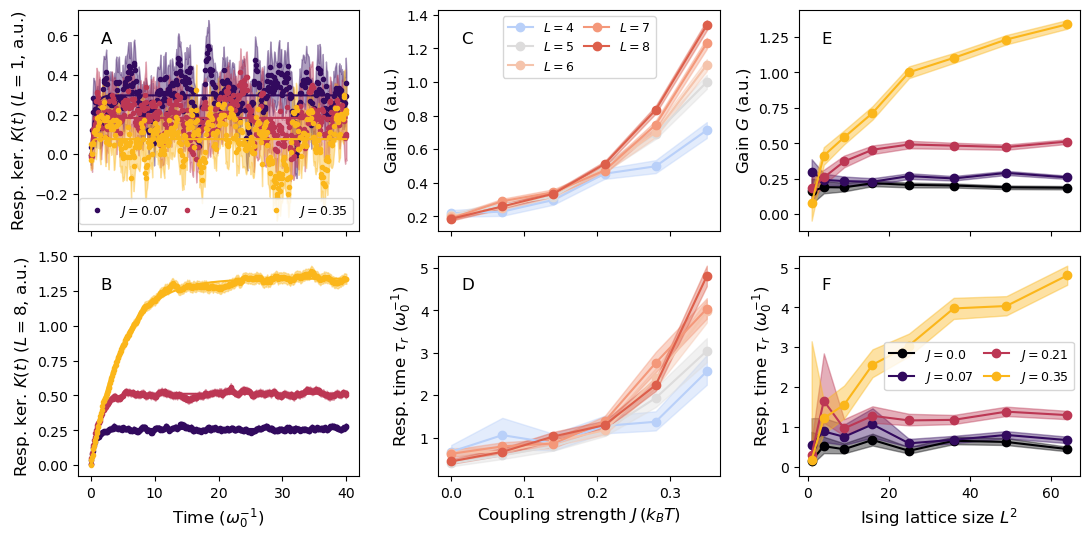

In [433]:
# preparation
fig_rk_ising_na = plt.figure(figsize=(11,5.5))

# create subplots
gs = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0],sharex=ax1)
ax3 = plt.subplot(gs[0,1])
ax4 = plt.subplot(gs[1,1],sharex=ax3)
ax5 = plt.subplot(gs[0,2])
ax6 = plt.subplot(gs[1,2],sharex=ax5)

Ns = 3000 # 5000
tf = 43
tc = 3
st = 0.1
L = 3
c0 = 100
cf = 90
Nbs = 1000
alpha = 0.32
open_boundary = True

L_arr = np.array([1,2,3,4,5,6,7,8]) # same as for Neff
J_arr = np.linspace(0,0.35,6) # or until 0.4

# rk_parms = np.zeros((2,L_arr.size,J_arr.size),dtype='float64')
# rk_lb = np.zeros_like(rk_parms)
# rk_ub = np.zeros_like(rk_parms)
# handles = []

for l,L in enumerate(L_arr):
    print('L = ',L)
    for j,J in enumerate(J_arr):
#         # obtain an ensemble and sample
#         ensemble, all_tau = ising_simulator(Ns,tf,tc,L,J,cf=cf,c0=c0,open_boundary=open_boundary)
#         all_samples, t_grid = ising_sampler(ensemble,all_tau,Ns,tf,st)
        t_grid = np.linspace(0,tf,int(tf/st)+1)
        time_s = t_grid[t_grid >= tc] - tc

#         if l == 0 and j == 0:
#             all_responses = np.zeros((Ns,L_arr.size,J_arr.size,time_s.size),dtype='float64')
#             mean_response = np.zeros((L_arr.size,J_arr.size,time_s.size),dtype='float64')
        
#         # find response kernel
#         all_responses[:,l,j] = 0.5*np.mean(all_samples[:,t_grid>=tc] - np.expand_dims(all_samples[:,int(tc/st)-1],axis=1),axis=(-1,-2))/np.log(c0/cf)
#         mean_response[l,j] = np.mean(all_responses[:,l,j],axis=0)

#         # fitting and bootstrappin'
#         rk_parms[:,l,j], rk_lb[:,l,j], rk_ub[:,l,j], bs_parms = bs_fitting(time_s,all_responses[:,l,j],rk_star,Nbs,alpha=alpha)
    
        if L == L_arr[0] and (j+1)%2 == 0:
            # show the response kernels for a given L
            lb, ub, _ = bs_ci(time_s,all_responses[:,l,j],Nbs,alpha=alpha)

            color = colormap_inferno(j/J_arr.size)
            ax1.plot(time_s,mean_response[l,j],'.',color=color,label=f'$J={np.round(J,2)}$')
            ax1.fill_between(time_s,lb,ub,color=color,alpha=0.4)
            ax1.plot(time_s,rk_star(time_s,*rk_parms[:,l,j]),color=color)
            ax1.set_ylabel(f'Resp. ker. $K(t)$ ($L={L}$, a.u.)',size=12)

        elif L == L_arr[-1] and (j+1)%2 == 0:
            # show the response kernels for a given L
            lb, ub, _ = bs_ci(time_s,all_responses[:,l,j],Nbs,alpha=alpha)

            color = colormap_inferno(j/J_arr.size)
            ax2.plot(time_s,mean_response[l,j],'.',color=color,label=f'$J={np.round(J,2)}$')
            ax2.fill_between(time_s,lb,ub,color=color,alpha=0.4)
            ax2.plot(time_s,rk_star(time_s,*rk_parms[:,l,j]),color=color)
            ax2.set_ylabel(f'Resp. ker. $K(t)$ ($L={L}$, a.u.)',size=12)
            ax2.set_xlabel(r'Time ($\omega_0^{-1}$)',size=12)

# show the gain and response time as functions of J
for l,L in enumerate(L_arr[3:]):
    color = colormap((l+3)/L_arr.size)
    ax3.plot(J_arr,rk_parms[0,l+3,:],'-o',color=color,label=f'$L={L}$')
    ax3.fill_between(J_arr,rk_lb[0,l+3,:],rk_ub[0,l+3,:],color=color,alpha=0.4)
    
    ax4.plot(J_arr,rk_parms[1,l+3,:],'-o',color=color,label=f'$L={L}$')
    ax4.fill_between(J_arr,rk_lb[1,l+3,:],rk_ub[1,l+3,:],color=color,alpha=0.4)
    # if L > 1:
    #     ax4.fill_between(J_arr,rk_lb[1,l,:],rk_ub[1,l,:],color=color,alpha=0.4)
    
# show the gain and response time as functions of L^2
for j,J in enumerate(J_arr):
    if j == 0. or (j+1)%2 == 0:
        color = colormap_inferno(j/J_arr.size)
        ax5.plot(L_arr**2,rk_parms[0,:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
        ax5.fill_between(L_arr**2,rk_lb[0,:,j],rk_ub[0,:,j],color=color,alpha=0.4)

        ax6.plot(L_arr**2,rk_parms[1,:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
        ax6.fill_between(L_arr**2,rk_lb[1,:,j],rk_ub[1,:,j],color=color,alpha=0.4)

# formatting
for ax in (ax1,ax3,ax5):
    plt.setp(ax.get_xticklabels(), visible=False)

ax1.legend(fontsize=9,ncol=3,columnspacing=0.4,loc='lower right')
ax3.legend(fontsize=9,loc='upper center',ncol=2,columnspacing=0.8)
ax6.legend(fontsize=9,loc='center right',ncol=2,columnspacing=0.8)

ax3.set_ylabel(r'Gain $G$ (a.u.)',size=12)
ax4.set_xlabel(r'Coupling strength $J \, (k_B T)$',size=12)
ax4.set_ylabel(r'Resp. time $\tau_r$ ($\omega_0^{-1}$)',size=12)
ax5.set_ylabel(r'Gain $G$ (a.u.)',size=12)
ax6.set_xlabel(r'Ising lattice size $L^2$',size=12)
ax6.set_ylabel(r'Resp. time $\tau_r$ ($\omega_0^{-1}$)',size=12)

letter_list = ['A','B','C','D','E','F']
for i,ax in enumerate((ax1,ax2,ax3,ax4,ax5,ax6)):
    ax.text(0.08,0.85,letter_list[i],size=12,transform = ax.transAxes)
    
plt.tight_layout()
plt.show()

In [75]:
fig_rk_ising_na.savefig('Figures/rk_ising_na_clean.pdf')

### Noise kernel

In [18]:
@numba.jit(nopython=True)
def cell_activity_ising(Ns,Nc,tf,tc,st,L,J,cf=90,open_boundary=True):
    '''
    Finds an ensemble of single-cell activities, i.e., activities averaged over the cell's clusters
    for the Ising model. Runs on Numba's nopython mode.

    Parameters
    ----------
    Ns: int
        number of samples, i.e., the number of cells in the ensemble
    Nc: int
        number of clusters per cell
    tf: float
        final time of the underlying Gillepsie simulation
    tc: float
        time at which the concentration is changed
    st: float
        sampling time period
    L: int
        linear dimension of cluster size
    J: float
        coupling strength in kBT
    cf: float, optional
        final concentration. Default is 90 microM

    Returns
    ----------
    all_cell_act: ndarray
        time-sampled traces of the activity for each cell. Shape is (Ns,int(tf/st) + 1)
    t_grid: ndarray
        times at which the time series are sampled, length int(tf/st) + 1
       
    '''
   
    # array to save result
    all_cell_act = np.zeros((Ns,int(tf/st) + 1,L,L),dtype='float64')
   
    for s in range(Ns):
        # obtain a single-cell realisation
        ensemble, all_tau = ising_simulator(Nc,tf,tc,L,J,cf=cf,open_boundary=open_boundary)
        all_samples, t_grid = ising_sampler(ensemble,all_tau,Nc,tf,st)
        # average over the cell's clusters
        all_cell_act[s,:,:,:] = np.sum(0.5*all_samples + 0.5,axis=0)/Nc
   
    return all_cell_act, t_grid

L =  2
L =  4
L =  6
L =  8


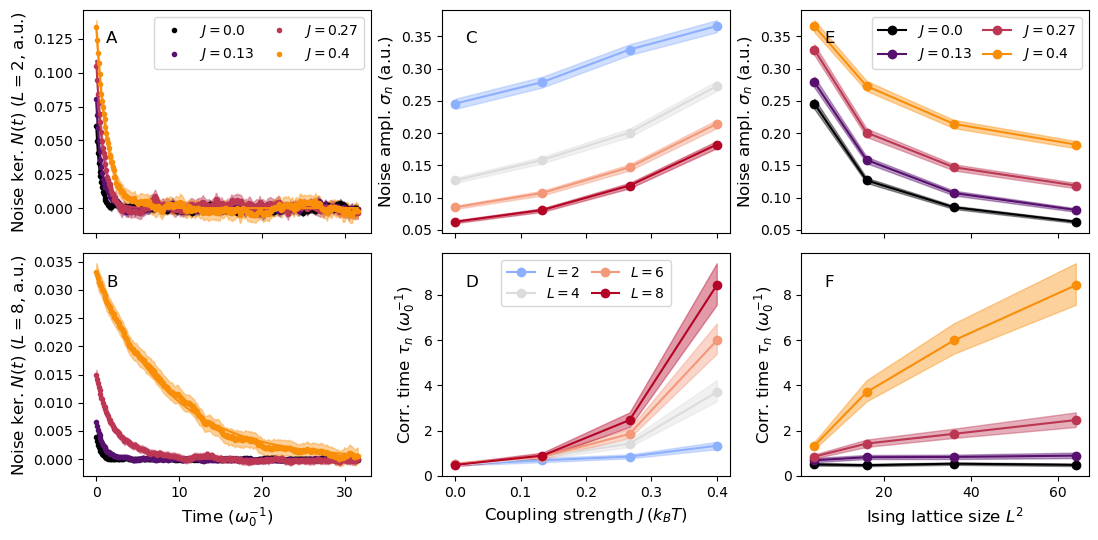

In [76]:
# noise kernel
def nk(t,sigma_n,tau_n):
    return sigma_n**2*np.exp(-np.abs(t)/tau_n)

# preparation
fig_nk_ising_na = plt.figure(figsize=(11,5.5))

# create subplots
gs = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0],sharex=ax1)
ax3 = plt.subplot(gs[0,1])
ax4 = plt.subplot(gs[1,1],sharex=ax3)
ax5 = plt.subplot(gs[0,2],sharey=ax3)
ax6 = plt.subplot(gs[1,2],sharex=ax5,sharey=ax4)

Ns = 2000 # 2000?
Nc = 1
tf = 35
tc = 0
st = 0.1
co = int(0.1*tf/st)
c0 = 100
cf = 100
Nbs = 1000
alpha = 0.05
open_boundary = True

L_arr = np.array([2,4,6,8])
J_arr = np.linspace(0.,0.4,4)

nk_parms = np.zeros((2,L_arr.size,J_arr.size),dtype='float64')
nk_lb = np.zeros_like(nk_parms)
nk_ub = np.zeros_like(nk_parms)
handles = []

for l,L in enumerate(L_arr):
    print('L = ',L)
    for j,J in enumerate(J_arr):
        # obtain a cell-ensemble
        cell_ensemble, t_grid = cell_activity_ising(Ns,Nc,tf,tc,st,L,J,open_boundary=open_boundary)
        time_s = t_grid[co:]-t_grid[co]

        # compute autocorrelation
        cell_act = np.mean(cell_ensemble,axis=(-1,-2))
        av_prod = np.mean(cell_act[:,co:].T*np.expand_dims(cell_act[:,co],axis=1).T,axis=1)
        prod_av = np.mean(cell_act[:,co:],axis=0)*np.mean(cell_act[:,co])
        nkernel = av_prod - prod_av

        # fitting and bootstrappin'
        nk_parms[:,l,j], pcov = curve_fit(nk,time_s,nkernel)
        all_auto_corr = np.zeros((Nbs,time_s.size),dtype='float64')
        bs_parms = np.zeros((nk_parms[:,l,j].size,Nbs),dtype='float64')

        for n in range(Nbs):
            # resample the original data
            idx = np.random.choice(np.arange(Ns),size=Ns,replace=True)
            bs_sample = np.mean(cell_ensemble[idx],axis=(-1,-2))

            # compute the autocorrelation for the bootstrapping sample and fit
            av_prod = np.mean(bs_sample[:,co:].T*bs_sample[:,co].T,axis=1)
            prod_av = np.mean(bs_sample[:,co:],axis=0)*np.mean(bs_sample[:,co])
            all_auto_corr[n,:] = av_prod - prod_av
            bs_parms[:,n],_ = curve_fit(nk,time_s,all_auto_corr[n,:])

        # extract confidence interval from bootstrapped distributions
        nk_lb[:,l,j] = np.percentile(bs_parms,100*alpha/2,axis=1) # fitting
        nk_ub[:,l,j] = np.percentile(bs_parms,100*(1-alpha/2),axis=1)
    
        if L == L_arr[0]:
            # show the noise kernels for a given L
            lb = np.percentile(all_auto_corr,100*alpha/2,axis=0)
            ub = np.percentile(all_auto_corr,100*(1-alpha/2),axis=0)

            color = colormap_inferno(j/J_arr.size)
            ax1.plot(time_s,nkernel,'.',color=color,label=f'$J={np.round(J,2)}$')
            ax1.fill_between(time_s,lb,ub,color=color,alpha=0.4)
            ax1.plot(time_s,nk(time_s,*nk_parms[:,l,j]),color=color)
            ax1.set_ylabel(f'Noise ker. $N(t)$ ($L={L}$, a.u.)',size=12)

        elif L == L_arr[-1]:
                    # show the noise kernels for a given L
            lb = np.percentile(all_auto_corr,100*alpha/2,axis=0)
            ub = np.percentile(all_auto_corr,100*(1-alpha/2),axis=0)

            color = colormap_inferno(j/J_arr.size)
            ax2.plot(time_s,nkernel,'.',color=color,label=f'$J={np.round(J,2)}$')
            ax2.fill_between(time_s,lb,ub,color=color,alpha=0.4)
            ax2.plot(time_s,nk(time_s,*nk_parms[:,l,j]),color=color)
            ax2.set_ylabel(f'Noise ker. $N(t)$ ($L={L}$, a.u.)',size=12)

# show the gain and response time as functions of J
for l,L in enumerate(L_arr):
    color = colormap((l+1)/L_arr.size)
    ax3.plot(J_arr,nk_parms[0,l,:],'-o',color=color,label=f'$L={L}$')
    ax3.fill_between(J_arr,nk_lb[0,l,:],nk_ub[0,l,:],color=color,alpha=0.4)
    
    ax4.plot(J_arr,nk_parms[1,l,:],'-o',color=color,label=f'$L={L}$')
    ax4.fill_between(J_arr,nk_lb[1,l,:],nk_ub[1,l,:],color=color,alpha=0.4)
    
# show the gain and response time as functions of L^2
for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax5.plot(L_arr**2,nk_parms[0,:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax5.fill_between(L_arr**2,nk_lb[0,:,j],nk_ub[0,:,j],color=color,alpha=0.4)
    
    ax6.plot(L_arr**2,nk_parms[1,:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax6.fill_between(L_arr**2,nk_lb[1,:,j],nk_ub[1,:,j],color=color,alpha=0.4)

# formatting
for ax in (ax1,ax3,ax5):
    plt.setp(ax.get_xticklabels(), visible=False)

ax1.legend(fontsize=10,ncol=2,columnspacing=0.8)
ax4.legend(fontsize=10,ncol=2,loc='upper center',columnspacing=0.8)
ax5.legend(fontsize=10,ncol=2,loc='upper right',columnspacing=0.8)

ax2.set_xlabel(r'Time ($\omega_0^{-1}$)',size=12)
ax3.set_ylabel(r'Noise ampl. $\sigma_n$ (a.u.)',size=12)
ax4.set_xlabel(r'Coupling strength $J \, (k_B T)$',size=12)
ax4.set_ylabel(r'Corr. time $\tau_n$ ($\omega_0^{-1}$)',size=12)
ax5.set_ylabel(r'Noise ampl. $\sigma_n$ (a.u.)',size=12)
ax6.set_ylabel(r'Corr. time $\tau_n$ ($\omega_0^{-1}$)',size=12)
ax6.set_xlabel(r'Ising lattice size $L^2$',size=12)

letter_list = ['A','B','C','D','E','F']
for i,ax in enumerate((ax1,ax2,ax3,ax4,ax5,ax6)):
    ax.text(0.08,0.85,letter_list[i],size=12,transform = ax.transAxes)
    
plt.tight_layout()
plt.show()

In [77]:
fig_nk_ising_na.savefig('Figures/nk_ising_na.pdf')

### Alternative, slower implementations

In [29]:
@numba.jit(nopython=True)
def original_ising_rates(s,J,H,omega0=1,open_boundary=True):
    # roll the states to find the nearest neighbours for each spin
    left = np.empty(s.shape)
    right = np.empty(s.shape)
    top = np.empty(s.shape)
    bottom = np.empty(s.shape)

    # roll the states (in the dumb numba way)
    for i in range(s.shape[0]):
        left[i,:] = np.roll(s[i,:],1)
        right[i,:] = np.roll(s[i,:],-1)
        top[:,i] = np.roll(s[:,i],1)
        bottom[:,i] = np.roll(s[:,i],-1)
        
    # if have open boundaries, remove neighbours at the edges
    if open_boundary:
        # remove boundary neighbours
        left[:,0] = 0.
        right[:,-1] = 0.
        top[0,:] = 0.
        bottom[-1,:] = 0.
    
    # compute the energy contributions
    coupling = J*s*(left+right+top+bottom) # coupling energy
    external = H*s # external-field energy
    
    # return the rates; based on detailed balance
    return omega0*np.exp(-(coupling+external))

In [30]:
@numba.jit(nopython=True)
def loop_ising_rates(s,J,H,omega0=1,open_boundary=True):
    # arrays to store the nearest neighbours
    left = np.empty_like(s)
    right = np.empty_like(s)
    top = np.empty_like(s)
    bottom = np.empty_like(s)

    # loop through the array to store nearest neighbours (fast than using np.roll in Numba)
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            left[i,j] = s[i,j-1]
            right[i,j] = s[i,(j+1)%s.shape[1]]
            top[i,j] = s[i-1,j]
            bottom[i,j] = s[(i+1)%s.shape[0],j]
                    
    # if have open boundaries, remove neighbours at the edges
    if open_boundary:
        left[:,0] = 0.
        right[:,-1] = 0.
        top[0,:] = 0.
        bottom[-1,:] = 0.
    
    # compute the energy contributions
    coupling = J*s*(left+right+top+bottom) # coupling energy
    external = H*s # external-field energy
    
    # return the rates; based on detailed balance
    return omega0*np.exp(-(coupling+external))

In [31]:
@numba.jit(nopython=True)
def open_ising_rates(s,J,H,omega0=1,open_boundary=True):
    # arrays to store the nearest neighbours
    nn = np.empty_like(s)

    # loop through the array to store nearest neighbours (fast than using np.roll in Numba)
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            if j == 0:
                left = 0
            elif j == s.shape[1] - 1:
                right = 0
            else:
                left = s[i,j-1]
                right = s[i,(j+1)%s.shape[1]]
            if i == 0:
                top = 0
            elif i == s.shape[0] - 1:
                bottom = 0
            else:
                top = s[i-1,j]
                bottom = s[(i+1)%s.shape[0],j]
            
            nn[i,j] = left + right + top + bottom
                    
    # if have periodic boundaries, add neighbours at the edges
    if open_boundary == False:
        nn[:,0] += s[:,-1]
        nn[:,-1] += s[:,0]
        nn[0,:] += s[-1,:]
        nn[-1,:] += s[0,:]
    
    # compute the energy contributions
    coupling = J*s*nn # coupling energy
    external = H*s # external-field energy
    
    # return the rates; based on detailed balance
    return omega0*np.exp(-(coupling+external))

In [32]:
J = 1
H = 1
s = np.random.choice([-1.,1.],size=(50,50))

%timeit original_ising_rates(s,J,H)
%timeit loop_ising_rates(s,J,H)
%timeit open_ising_rates(s,J,H)
%timeit ising_rates(s,J,H)

191 µs ± 61 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
121 µs ± 42 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
132 µs ± 55.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
122 µs ± 43.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Adaptive Ising Model

### Main functions

In [19]:
@numba.jit(nopython=True)
def demethylation_rates(s,m,kR,kB):
    # array to store results
    demeth_rates = np.zeros_like(m,dtype='float64')
    meth_rates = np.zeros_like(m,dtype='float64')
 
    # loop through all receptors and check whether they can (de)methylate        
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            # demethylation
            if s[i,j] == 1 and m[i,j] > 0:
                demeth_rates[i,j] = kB
                
            # methylation
            if s[i,j] == -1 and m[i,j] < 4:
                meth_rates[i,j] = kR

    return demeth_rates, meth_rates

In [20]:
s = np.random.choice([-1.,1.],size=(50,50))
m = np.random.choice(np.arange(0,5),size=(50,50))
kR = 1
kB = 2

%timeit demethylation_rates(s,m,kR,kB)

The slowest run took 6.69 times longer than the fastest. This could mean that an intermediate result is being cached.
23.4 µs ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
@numba.jit(nopython=True)
def adaptive_ising_simulator(Ns,tf,tc,L,J,
                    omega0=1,c0=100,cf=90,Ki=18,Ka=2900,dfm=-2,m0=0.5,kR=0.01,kB=0.02,open_boundary=True):
    '''
    Simulates a kinetic, non-adaptive two-dimensional Ising model on a square lattice 
    using Gillespie's algorithm. Runs in Numba's nopython mode.
    
    Parameters
    ----------
    Ns: int
        number of realisations
    tf: float
        final time of the simulation
    tc: float
        time at which the concentration changes
    L: int
        linear dimension of lattice, i.e., there are LxL spins
    J: float
        coupling strength in units of kBT
    omega0: float, optional
        fundamental flipping frequency. Note that all time is in units of 1/omega0
    c0: float, optional
        baseline concentration. Default is 100 microM
    cf: float, optional
        concentration after the step change Default is 90 microM
    Ki, Ka: float, optional
        dissocation constants for inactive and active state, respectively, in microM.
        Defaults are 18 and 2900 microM, respectively.
    dfm: float
        free-energy cost of an additional methyl group. Default is -2 kT
    m0: float
        baseline methylation level. Default is 0.5
    kR, kB: float
        methylation and demethylation rate, respectively. Defaults are 0.01 omega0
        and 0.02 omega0, respectively
    open_boundary: bool, optional
        defines the boundary condition. By default, open boundaries are used
        
    Returns
    ---------
    s_ensemble: typed List
        contains the ensemble of Ns realisations of the Ising model's spins
        note: ensemble[0] gives the first realisation; ensemble[0][0] the first lattice of
        the first realisation etc.
    m_ensemble: typed List
        contains the ensemble of Ns realisations of the Ising model's methylation level
        note: the shape is the same as for s_ensemble and methylation level is NOT normalised
    all_tau: typed List
        contains the ensemble of Ns waiting time traces
    '''
    # Numba lists to store results
    s_ensemble = List()
    m_ensemble = List()
    all_tau = List()

    # obtain Ns realisations
    for n in range(Ns):
        s = biased_choice(np.array([-1.,1.]),np.array([kB/(kR+kB),kR/(kR+kB)]),size=L**2).reshape((L,L)) # spins
        m = biased_choice(np.array([1.,2.]),np.array([0.84,0.16]),size=L**2).reshape((L,L)) # methylation level

        #m = biased_choice(np.linspace(0,4,5),np.linspace(0,4,5)[::-1]/np.sum(np.linspace(0,4,5)),
        #                   size=L**2).reshape((L,L)) # methylation level
        # m = np.ones((L,L),dtype='float64')
        spins = np.expand_dims(s,axis=0)
        meth = np.expand_dims(m,axis=0)

        tau = np.zeros(1,dtype='float64') # waiting time and time counter
        time = 0

        H = -0.5*np.log((1+c0/Ki)/(1+c0/Ka))-0.5*dfm*(m-m0) # initial external field
        switch_bool = False # to check whether concentration has changed

        # evolve system until tf
        while time <= tf:
            # determine the various rates
            flipping_rates = ising_rates(s,J,H,omega0=omega0,open_boundary=open_boundary)
            demeth_rates, meth_rates = demethylation_rates(s,m,kR,kB)
            Omega = np.sum(flipping_rates + demeth_rates + meth_rates)

            # sample time until next event
            u = np.random.uniform(0,1)
            time += -np.log(u)/Omega

            # if has passed tc: reset the system to the time of the concentration change
            if time > tc and switch_bool == False:
                # time needed to advance from last time step to tc
                advance = tc-(time + np.log(u)/Omega)

                # update external field and rates
                H = -0.5*np.log((1+cf/Ki)/(1+cf/Ka))-0.5*dfm*(m-m0)
                flipping_rates = ising_rates(s,J,H,omega0=omega0,open_boundary=open_boundary) # only flipping rates change
                Omega = np.sum(flipping_rates + demeth_rates + meth_rates)

                # sample time until next event
                u = np.random.uniform(0,1)
                time = tc-np.log(u)/Omega
                tau = np.append(tau,advance-np.log(u)/Omega)

                # update the boolean to prevent further switching
                switch_bool = True

            else: # most cases; just append time and continue
                tau = np.append(tau,-np.log(u)/Omega)

            # determine which event occurs
            flat_rates = np.concatenate((flipping_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                         meth_rates.reshape(L**2))) # useful to have a 1-dim 3L^2 array
            p = np.random.uniform(0,1)*Omega
            e_idx = np.argmax(p < np.cumsum(flat_rates))

            # obtain the type of event and coordinate
            e_type, coord = np.divmod(e_idx,L**2)
            x,y = np.divmod(coord,L)

            # perform event based on what type of event occurred
            if e_type == 0: # spin flip
                s[x,y] *= -1.
            elif e_type == 1: # demethylation
                m[x,y] += -1.
                H[x,y] += 0.5*dfm # update external field
            else: # methylation
                m[x,y] += 1.
                H[x,y] += -0.5*dfm # update external field

            # save state
            spins = np.concatenate((spins,np.expand_dims(s,axis=0)))
            meth = np.concatenate((meth,np.expand_dims(m,axis=0)))

        s_ensemble.append(spins)
        m_ensemble.append(meth)
        all_tau.append(tau)
        
    return s_ensemble, m_ensemble, all_tau

In [22]:
Ns = 100
tf = 30
tc = 15
L = 2
J = 0.3

%timeit adaptive_ising_simulator(Ns,tf,tc,L,J)

23.4 ms ± 645 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Time series

In [166]:
Ns = 1000
tf = 600
tc = 100
L = 2
J = 0.2
kR = 0.005
kB = 2*kR

s_ensemble, m_ensemble, all_tau = adaptive_ising_simulator(Ns,tf,tc,L,J,cf=70,kR=kR,kB=kB)

In [167]:
st = 5
s_samples, t_grid = ising_sampler(s_ensemble,all_tau,Ns,tf,st)
m_samples, t_grid = ising_sampler(m_ensemble,all_tau,Ns,tf,st)

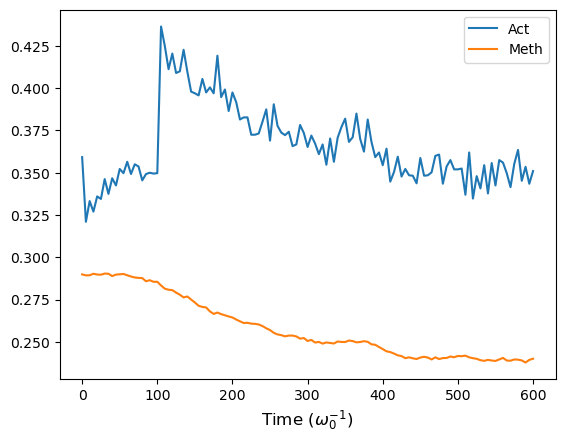

In [168]:
spin = np.mean(s_samples,axis=(0,-1,-2))
meth_level = np.mean(m_samples,axis=(0,-1,-2))/4
plt.plot(t_grid,0.5*(spin+1),label='Act')
plt.plot(t_grid,meth_level,label='Meth')
plt.legend()
plt.xlabel(r'Time ($\omega_0^{-1}$)',size=12)
plt.show()

### Response kernel (fitting)

L =  1
  J =  0.0
  J =  0.11666666666666665
  J =  0.2333333333333333
  J =  0.35
L =  2
  J =  0.0


/tmp/ipykernel_1213369/3698692997.py:3: RuntimeWarning: overflow encountered in exp
  return G*(1-np.exp(-t/tau_r))*np.exp(-t/tau_a)


  J =  0.11666666666666665


/tmp/ipykernel_1213369/3698692997.py:3: RuntimeWarning: invalid value encountered in multiply
  return G*(1-np.exp(-t/tau_r))*np.exp(-t/tau_a)
/tmp/ipykernel_1213369/3698692997.py:3: RuntimeWarning: overflow encountered in multiply
  return G*(1-np.exp(-t/tau_r))*np.exp(-t/tau_a)


  J =  0.2333333333333333
  J =  0.35
L =  3
  J =  0.0
  J =  0.11666666666666665
  J =  0.2333333333333333
  J =  0.35


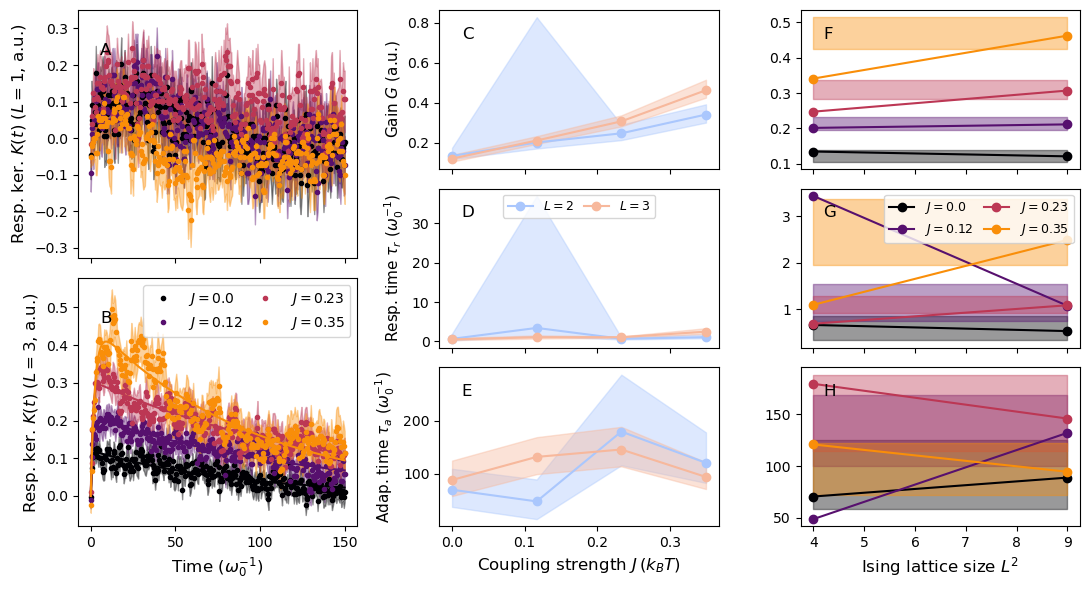

In [110]:
# adaptive response kernel
def rk(t,G,tau_r,tau_a):
    return G*(1-np.exp(-t/tau_r))*np.exp(-t/tau_a)

def meth_fit(t,Gm,tau_m):
    return Gm*(1-np.exp(-t/tau_m))

# preparation
fig_rk_ising_ad = plt.figure(figsize=(11,6))

# create subplots
gs = gridspec.GridSpec(6, 3)
ax1 = plt.subplot(gs[:3,0])
ax2 = plt.subplot(gs[3:,0],sharex=ax1)
ax3 = plt.subplot(gs[:2,1])
ax4 = plt.subplot(gs[2:4,1],sharex=ax3)
ax5 = plt.subplot(gs[4:,1],sharex=ax3)
ax6 = plt.subplot(gs[:2,2])
ax7 = plt.subplot(gs[2:4,2],sharex=ax6)
ax8 = plt.subplot(gs[4:,2],sharex=ax6)

Ns = 500
tf = 250
tc = 100
st = 0.5
kR = 0.005
kB = 2*kR
c0 = 100
cf = 70
open_boundary=False
Nbs = 1000
alpha = 0.32

L_arr = np.array([1,2,3])
J_arr = np.linspace(0.,0.35,4)

rk_ising_ad = np.zeros((3,L_arr.size-1,J_arr.size),dtype='float64')
rk_lb_ising_ad = np.zeros_like(rk_ising_ad)
rk_ub_ising_ad = np.zeros_like(rk_ising_ad)

ltr_ising_lb = np.zeros((L_arr.size-1,J_arr.size),dtype='float64') # for log of ratio of time scales
ltr_ising_ub = np.zeros_like(ltr_ising_lb)

# meth_parms_ad = np.zeros((2,N_arr.size),dtype='float64')
# meth_lb_ad = np.zeros_like(meth_parms_ad)
# meth_ub_ad = np.zeros_like(meth_parms_ad)

handles = []
    
for l,L in enumerate(L_arr):
    print('L = ',L)
    for j,J in enumerate(J_arr):
        print('  J = ',J)
        # obtain an ensemble and sample
        s_ensemble, m_ensemble, all_tau = adaptive_ising_simulator(Ns,tf,tc,L,J,cf=cf,kR=kR,kB=kB,open_boundary=open_boundary)
        s_samples, t_grid = ising_sampler(s_ensemble,all_tau,Ns,tf,st)
        time_s = t_grid[t_grid >= tc] - tc

        if l == 0 and j == 0:
            all_responses = np.zeros((Ns,L_arr.size,J_arr.size,time_s.size),dtype='float64')
            mean_response = np.zeros((L_arr.size,J_arr.size,time_s.size),dtype='float64')
        
        # find response kernel
        all_responses[:,l,j] = 0.5*np.mean(s_samples[:,t_grid>=tc] - np.expand_dims(s_samples[:,int(tc/st)-1],axis=1),axis=(-1,-2))/np.log(c0/cf)
        mean_response[l,j] = np.mean(all_responses[:,l,j],axis=0)

        # fitting and bootstrappin' for L > 1
        if L > 1:
            rk_ising_ad[:,l-1,j], rk_lb_ising_ad[:,l-1,j], rk_ub_ising_ad[:,l-1,j], bs_parms = bs_fitting(time_s,all_responses[:,l,j],rk,Nbs,alpha=alpha)

            # save log of time ratio
            ltr = np.log10(bs_parms[2]/bs_parms[1])
            ltr_ising_lb[l-1,j] = np.percentile(ltr,100*alpha/2)
            ltr_ising_ub[l-1,j] = np.percentile(ltr,100*(1-alpha/2))
    
        if L == L_arr[0]:
            # show the response kernels for a given L
            lb, ub, _ = bs_ci(time_s,all_responses[:,l,j],Nbs,alpha=alpha)

            color = colormap_inferno(j/J_arr.size)
            ax1.plot(time_s,mean_response[l,j],'.',color=color,label=f'$J={np.round(J,2)}$')
            ax1.fill_between(time_s,lb,ub,color=color,alpha=0.4)
            ax1.set_ylabel(f'Resp. ker. $K(t)$ ($L={L}$, a.u.)',size=12)

        elif L == L_arr[-1]:
            # show the response kernels for a given L
            lb, ub, _ = bs_ci(time_s,all_responses[:,l,j],Nbs,alpha=alpha)

            color = colormap_inferno(j/J_arr.size)
            ax2.plot(time_s,mean_response[l,j],'.',color=color,label=f'$J={np.round(J,2)}$')
            ax2.fill_between(time_s,lb,ub,color=color,alpha=0.4)
            ax2.plot(time_s,rk(time_s,*rk_ising_ad[:,l-1,j]),color=color)
            ax2.set_ylabel(f'Resp. ker. $K(t)$ ($L={L}$, a.u.)',size=12)
            ax2.set_xlabel(r'Time ($\omega_0^{-1}$)',size=12)
    
# show the gain, response time and adaptation time as functions of J for L > 1
for l,L in enumerate(L_arr[1:]):
    color = colormap((l+1)/L_arr.size)
    ax3.plot(J_arr,rk_ising_ad[0,l,:],'-o',color=color,label=f'$L={L}$')
    ax3.fill_between(J_arr,rk_lb_ising_ad[0,l,:],rk_ub_ising_ad[0,l,:],color=color,alpha=0.4)
    
    ax4.plot(J_arr,rk_ising_ad[1,l,:],'-o',color=color,label=f'$L={L}$')
    ax4.fill_between(J_arr,rk_lb_ising_ad[1,l,:],rk_ub_ising_ad[1,l,:],color=color,alpha=0.4)
        
    ax5.plot(J_arr,rk_ising_ad[2,l,:],'-o',color=color,label=f'$L={L}$')
    ax5.fill_between(J_arr,rk_lb_ising_ad[2,l,:],rk_ub_ising_ad[2,l,:],color=color,alpha=0.4)
    
# show the gain, response time and adaptation time as functions of L^2
for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax6.plot(L_arr[1:]**2,rk_ising_ad[0,:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax6.fill_between(L_arr[1:]**2,rk_lb_ising_ad[0,:,j],rk_ub_ising_ad[0,:,j],color=color,alpha=0.4)
    
    ax7.plot(L_arr[1:]**2,rk_ising_ad[1,:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax7.fill_between(L_arr[1:]**2,rk_lb_ising_ad[1,:,j],rk_ub_ising_ad[1,:,j],color=color,alpha=0.4)
    
    ax8.plot(L_arr[1:]**2,rk_ising_ad[2,:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax8.fill_between(L_arr[1:]**2,rk_lb_ising_ad[2,:,j],rk_ub_ising_ad[2,:,j],color=color,alpha=0.4)

# formatting
for ax in (ax1,ax3,ax4,ax6,ax7):
    plt.setp(ax.get_xticklabels(), visible=False)

ax2.legend(fontsize=10,ncol=2,columnspacing=0.6,loc='upper right')
ax4.legend(fontsize=9,loc='upper center',ncol=2,columnspacing=0.8)
ax7.legend(fontsize=9,ncol=2,loc='upper right',columnspacing=0.8)

ax3.set_ylabel(r'Gain $G$ (a.u.)',size=11)
ax4.set_ylabel(r'Resp. time $\tau_r$ ($\omega_0^{-1}$)',size=11)
ax5.set_ylabel(r'Adap. time $\tau_a$ ($\omega_0^{-1}$)',size=11)
ax5.set_xlabel(r'Coupling strength $J \, (k_B T)$',size=12)
ax8.set_xlabel(r'Ising lattice size $L^2$',size=12)

letter_list = ['A','B','C','D','E','F','G','H']
for i,ax in enumerate((ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8)):
    ax.text(0.08,0.82,letter_list[i],size=12,transform = ax.transAxes)
    
plt.tight_layout()
plt.show()

In [ ]:
fig_rk_ising_ad.savefig('Figures/rk_ising_ad.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


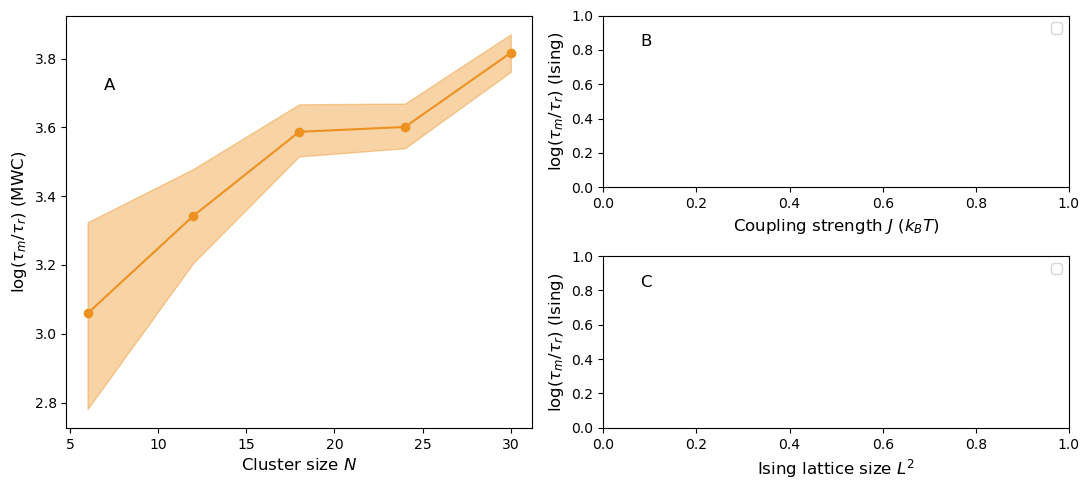

In [192]:
# plot of log time ratios
fig_ltr = plt.figure(figsize=(11,5))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1])

ax1.plot(N_arr,np.log10(rk_parms_ad[2]/rk_parms_ad[1]),'-o',color=my_yellow)
ax1.fill_between(N_arr,ltr_lb,ltr_ub,color=my_yellow,alpha=0.4)

for l,L in enumerate(L_arr[1:]):
    color = colormap((l+1)/L_arr.size)
    ax2.plot(J_arr,np.log10(rk_ising_ad[2,l,:]/rk_ising_ad[1,l,:]),'-o',color=color,label=f'$L={L}$')
    ax2.fill_between(J_arr,ltr_ising_lb[l,:],ltr_ising_ub[l,:],color=color,alpha=0.4)
    
for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax3.plot(L_arr[1:]**2,np.log10(rk_ising_ad[2,:,j]/rk_ising_ad[1,:,j]),'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax3.fill_between(L_arr[1:]**2,ltr_ising_lb[:,j],ltr_ising_ub[:,j],color=color,alpha=0.4)

ax1.set_ylabel(r'log($\tau_m/\tau_r$) (MWC)',size=12)
ax1.set_xlabel(r'Cluster size $N$',size=12)

ax2.legend(ncol=2,columnspacing=0.8)
ax2.set_ylabel(r'log($\tau_m/\tau_r$) (Ising)',size=12)
ax2.set_xlabel(r'Coupling strength $J$ ($k_B T$)',size=12)

ax3.legend(ncol=2,columnspacing=0.8)
ax3.set_ylabel(r'log($\tau_m/\tau_r$) (Ising)',size=12)
ax3.set_xlabel(r'Ising lattice size $L^2$',size=12)

letter_list = ['A','B','C']
for i,ax in enumerate((ax1,ax2,ax3)):
    ax.text(0.08,0.82,letter_list[i],size=12,transform = ax.transAxes)
    
plt.tight_layout()
plt.show()

In [ ]:
fig_ltr.savefig('Figures/ltr.pdf')

### Response kernel (clean)

L =  1
  J =  0.0
  J =  0.175
  J =  0.35
L =  2
  J =  0.0
  J =  0.175
  J =  0.35
L =  5
  J =  0.0
  J =  0.175
  J =  0.35
L =  7
  J =  0.0
  J =  0.175
  J =  0.35


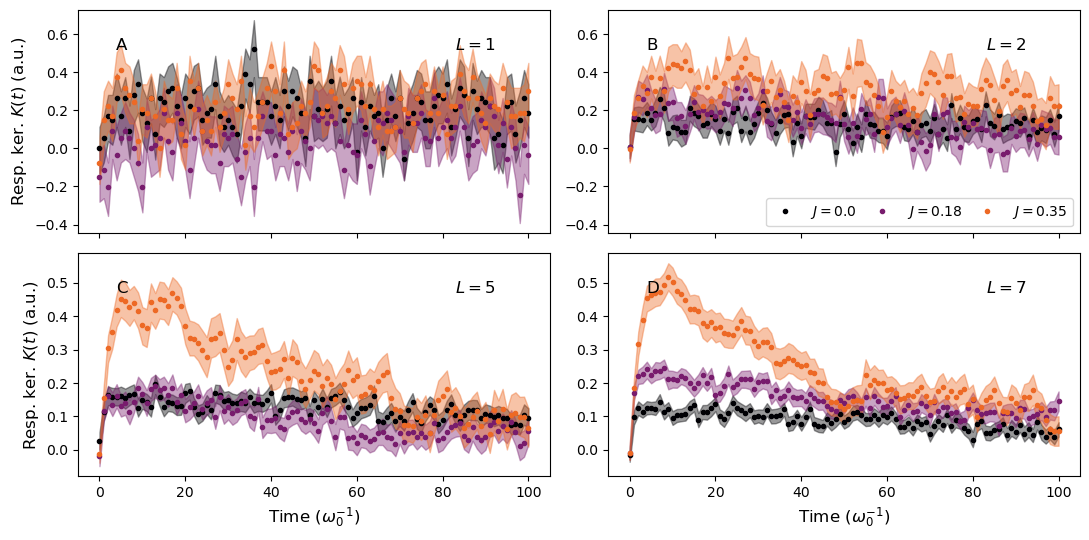

In [55]:
# preparation
fig_rk_ising_ad = plt.figure(figsize=(11,5.5))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1],sharey=ax1)
ax3 = plt.subplot(gs[1,0],sharex=ax1)
ax4 = plt.subplot(gs[1,1],sharex=ax2,sharey=ax3)

Ns = 150
tf = 250
tc = 150
st = 1.
kR = 0.005
kB = 2*kR
c0 = 100
cf = 70
open_boundary=False
Nbs = 1000
alpha = 0.32

L_arr = np.array([1,3,5,7])
J_arr = np.linspace(0.,0.35,3)
    
for l,ax in enumerate((ax1,ax2,ax3,ax4)):
    L = L_arr[l]
    print('L = ',L)
    for j,J in enumerate(J_arr):
        print('  J = ',J)
        # obtain an ensemble and sample
        s_ensemble, m_ensemble, all_tau = adaptive_ising_simulator(Ns,tf,tc,L,J,cf=cf,kR=kR,kB=kB,open_boundary=open_boundary)
        s_samples, t_grid = ising_sampler(s_ensemble,all_tau,Ns,tf,st)
        time_s = t_grid[t_grid >= tc] - tc

        if l == 0 and j == 0:
            all_responses = np.zeros((Ns,L_arr.size,J_arr.size,time_s.size),dtype='float64')
            mean_response = np.zeros((L_arr.size,J_arr.size,time_s.size),dtype='float64')
        
        # find response kernel
        all_responses[:,l,j] = 0.5*np.mean(s_samples[:,t_grid>=tc] - np.expand_dims(s_samples[:,int(tc/st)-1],axis=1),axis=(-1,-2))/np.log(c0/cf)
        mean_response[l,j] = np.mean(all_responses[:,l,j],axis=0)
    
        # show the response kernels for a given L
        lb, ub, _ = bs_ci(time_s,all_responses[:,l,j],Nbs,alpha=alpha)

        color = colormap_inferno(j/J_arr.size)
        ax.plot(time_s,mean_response[l,j],'.',color=color,label=f'$J={np.round(J,2)}$')
        ax.fill_between(time_s,lb,ub,color=color,alpha=0.4)
        
        if l == 0 or l == 2:
            ax.set_ylabel(f'Resp. ker. $K(t)$ (a.u.)',size=12)
            
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.legend(fontsize=10,ncol=3,columnspacing=0.8,loc='lower right')
ax3.set_xlabel(r'Time ($\omega_0^{-1}$)',size=12)
ax4.set_xlabel(r'Time ($\omega_0^{-1}$)',size=12)

letter_list = ['A','B','C','D']
for i,ax in enumerate((ax1,ax2,ax3,ax4)):
    ax.text(0.08,0.82,letter_list[i],size=12,transform = ax.transAxes)
    ax.text(0.8,0.82,f'$L={L_arr[i]}$',size=12,transform = ax.transAxes)
    
plt.tight_layout()
plt.show()

In [56]:
fig_rk_ising_ad.savefig('Figures/rk_ising_ad.pdf')

### Noise kernel (clean)

L =  1
  J =  0.0
  J =  0.175
  J =  0.35
L =  2
  J =  0.0
  J =  0.175
  J =  0.35
L =  5
  J =  0.0
  J =  0.175
  J =  0.35
L =  7
  J =  0.0
  J =  0.175
  J =  0.35


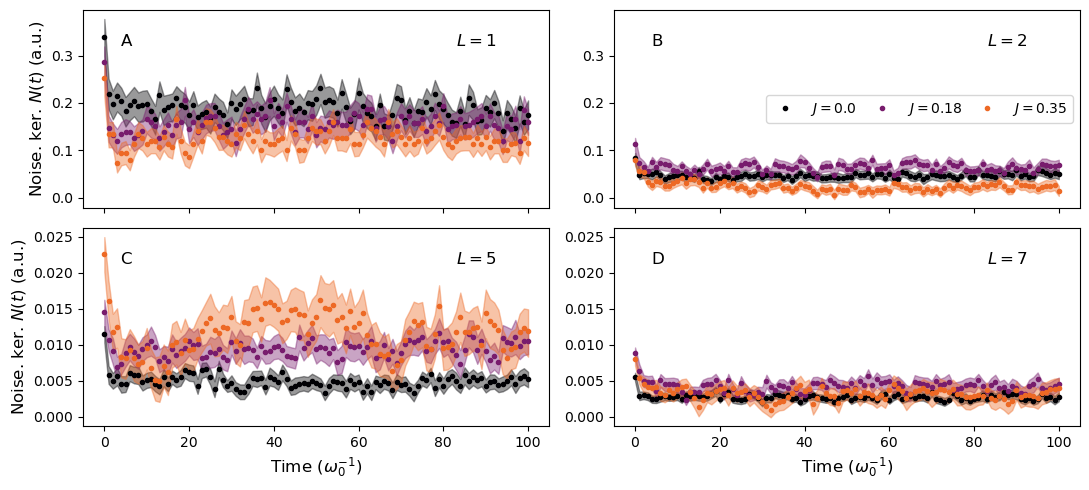

In [57]:
# preparation
fig_nk_ising_ad = plt.figure(figsize=(11,5))

# create subplots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1],sharey=ax1)
ax3 = plt.subplot(gs[1,0],sharex=ax1)
ax4 = plt.subplot(gs[1,1],sharey=ax3,sharex=ax2)

Ns = 150
tf = 250
tc = 150
st = 1
kR = 0.005
kB = 2*kR
c0 = 100
cf = 100
open_boundary=False
Nbs = 1000
alpha = 0.32

L_arr = np.array([1,2,5,7])
J_arr = np.linspace(0.,0.35,3)

for l,ax in enumerate((ax1,ax2,ax3,ax4)):
    L = L_arr[l]
    print('L = ',L)
    for j,J in enumerate(J_arr):
        print('  J = ',J)
        # obtain an ensemble and sample
        s_ensemble, m_ensemble, all_tau = adaptive_ising_simulator(Ns,tf,tc,L,J,cf=cf,kR=kR,kB=kB,open_boundary=open_boundary)
        s_samples, t_grid = ising_sampler(s_ensemble,all_tau,Ns,tf,st)
        time_s = t_grid[t_grid >= tc] - tc
        
        if l == 0 and j == 0:
            all_act = np.zeros((Ns,L_arr.size,J_arr.size,time_s.size),dtype='float64')

        # compute autocorrelation
        all_act[:,l,j] = 0.5*np.mean(s_samples[:,t_grid>=tc] - np.expand_dims(s_samples[:,int(tc/st)-1],axis=1),axis=(-1,-2))
        av_prod = np.mean(all_act[:,l,j].T*np.expand_dims(all_act[:,l,j,0],axis=1).T,axis=1)
        prod_av = np.mean(all_act[:,l,j],axis=0)*np.mean(all_act[:,l,j,0])
        nkernel = av_prod - prod_av
        
        # bootstrapping
        all_auto_corr = np.zeros((Nbs,time_s.size),dtype='float64')
        for n in range(Nbs):
            # resample the original data
            idx = np.random.choice(np.arange(Ns),size=Ns,replace=True)
            bs_sample = all_act[idx,l,j]

            # compute the autocorrelation for the bootstrapping sample and fit
            av_prod = np.mean(bs_sample.T*np.expand_dims(bs_sample[:,0],axis=1).T,axis=1)
            prod_av = np.mean(bs_sample,axis=0)*np.mean(bs_sample[:,0])
            all_auto_corr[n,:] = av_prod - prod_av
            
        # show the noise kernels for a given L
        lb = np.percentile(all_auto_corr,100*alpha/2,axis=0)
        ub = np.percentile(all_auto_corr,100*(1-alpha/2),axis=0)

        color = colormap_inferno(j/J_arr.size)
        ax.plot(time_s,nkernel,'.',color=color,label=f'$J={np.round(J,2)}$')
        ax.fill_between(time_s,lb,ub,color=color,alpha=0.4)
        if l == 0 or l == 2:
            ax.set_ylabel(f'Noise. ker. $N(t)$ (a.u.)',size=12)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.legend(fontsize=10,ncol=3,columnspacing=0.8,loc='center right')
ax3.set_xlabel(r'Time ($\omega_0^{-1}$)',size=12)
ax4.set_xlabel(r'Time ($\omega_0^{-1}$)',size=12)

letter_list = ['A','B','C','D']
for i,ax in enumerate((ax1,ax2,ax3,ax4)):
    ax.text(0.08,0.82,letter_list[i],size=12,transform = ax.transAxes)
    ax.text(0.8,0.82,f'$L={L_arr[i]}$',size=12,transform = ax.transAxes)
    
plt.tight_layout()
plt.show()

In [58]:
fig_nk_ising_ad.savefig('Figures/nk_ising_ad.pdf')

### Fitting noise kernel

L =  1
  J =  0.0
  J =  0.175
  J =  0.35
L =  3
  J =  0.0
  J =  0.175
  J =  0.35


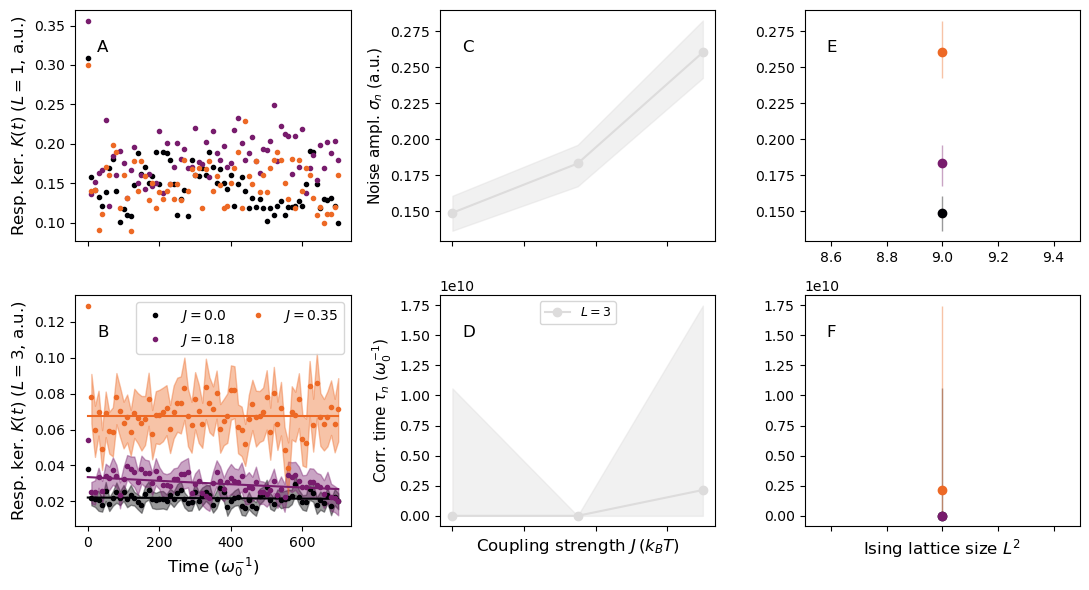

In [177]:
# preparation
fig_nk_ising_ad = plt.figure(figsize=(11,6))

# create subplots
gs = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0],sharex=ax1)
ax3 = plt.subplot(gs[0,1])
ax4 = plt.subplot(gs[1,1],sharex=ax3)
ax5 = plt.subplot(gs[0,2])
ax6 = plt.subplot(gs[1,2],sharex=ax5)

Ns = 100
tf = 800
tc = 100
st = 10
kR = 0.005
kB = 2*kR
c0 = 100
cf = 100
open_boundary=False
Nbs = 1000
alpha = 0.32

L_arr = np.array([1,3])
J_arr = np.linspace(0.,0.35,3)

nk_ising_ad = np.zeros((2,L_arr.size-1,J_arr.size),dtype='float64')
nk_lb_ising_ad = np.zeros_like(nk_ising_ad)
nk_ub_ising_ad = np.zeros_like(nk_ising_ad)

handles = []
    
for l,L in enumerate(L_arr):
    print('L = ',L)
    for j,J in enumerate(J_arr):
        print('  J = ',J)
        # obtain an ensemble and sample
        s_ensemble, m_ensemble, all_tau = adaptive_ising_simulator(Ns,tf,tc,L,J,cf=cf,kR=kR,kB=kB,open_boundary=open_boundary)
        s_samples, t_grid = ising_sampler(s_ensemble,all_tau,Ns,tf,st)
        time_s = t_grid[t_grid >= tc] - tc
        
        if l == 0 and j == 0:
            all_act = np.zeros((Ns,L_arr.size,J_arr.size,time_s.size),dtype='float64')
            mean_act = np.zeros((L_arr.size,J_arr.size,time_s.size),dtype='float64')

        # compute autocorrelation
        all_act[:,l,j] = 0.5*np.mean(s_samples[:,t_grid>=tc] - np.expand_dims(s_samples[:,int(tc/st)-1],axis=1),axis=(-1,-2))
        av_prod = np.mean(all_act[:,l,j].T*np.expand_dims(all_act[:,l,j,0],axis=1).T,axis=1)
        prod_av = np.mean(all_act[:,l,j],axis=0)*np.mean(all_act[:,l,j,0])
        nkernel = av_prod - prod_av

        # fitting and bootstrappin'
        if L > 1:
            nk_ising_ad[:,l-1,j], _ = curve_fit(nk,time_s[1:],nkernel[1:])
            all_auto_corr = np.zeros((Nbs,time_s.size),dtype='float64')
            bs_parms = np.zeros((nk_ising_ad[:,l-1,j].size,Nbs),dtype='float64')

            for n in range(Nbs):
                # resample the original data
                idx = np.random.choice(np.arange(Ns),size=Ns,replace=True)
                bs_sample = all_act[idx,l,j]

                # compute the autocorrelation for the bootstrapping sample and fit
                av_prod = np.mean(bs_sample.T*np.expand_dims(bs_sample[:,0],axis=1).T,axis=1)
                prod_av = np.mean(bs_sample,axis=0)*np.mean(bs_sample[:,0])
                all_auto_corr[n,:] = av_prod - prod_av
                bs_parms[:,n],_ = curve_fit(nk,time_s[1:],all_auto_corr[n,1:])

            # extract confidence interval from bootstrapped distributions
            nk_lb_ising_ad[:,l-1,j] = np.percentile(bs_parms,100*alpha/2,axis=1) # fitting
            nk_ub_ising_ad[:,l-1,j] = np.percentile(bs_parms,100*(1-alpha/2),axis=1)
    
        if L == L_arr[0]:
            color = colormap_inferno(j/J_arr.size)
            ax1.plot(time_s,nkernel,'.',color=color,label=f'$J={np.round(J,2)}$')
            ax1.set_ylabel(f'Resp. ker. $K(t)$ ($L={L}$, a.u.)',size=12)

        elif L == L_arr[-1]:
            # show the noise kernels for a given L
            lb = np.percentile(all_auto_corr[:,1:],100*alpha/2,axis=0)
            ub = np.percentile(all_auto_corr[:,1:],100*(1-alpha/2),axis=0)
            
            color = colormap_inferno(j/J_arr.size)
            ax2.plot(time_s,nkernel,'.',color=color,label=f'$J={np.round(J,2)}$')
            ax2.fill_between(time_s[1:],lb,ub,color=color,alpha=0.4)
            ax2.plot(time_s,nk(time_s,*nk_ising_ad[:,l-1,j]),color=color)
            ax2.set_ylabel(f'Resp. ker. $K(t)$ ($L={L}$, a.u.)',size=12)
            ax2.set_xlabel(r'Time ($\omega_0^{-1}$)',size=12)
    
# show the gain, response time and adaptation time as functions of J for L > 1
for l,L in enumerate(L_arr[1:]):
    color = colormap((l+1)/L_arr.size)
    ax3.plot(J_arr,nk_ising_ad[0,l,:],'-o',color=color,label=f'$L={L}$')
    ax3.fill_between(J_arr,nk_lb_ising_ad[0,l,:],nk_ub_ising_ad[0,l,:],color=color,alpha=0.4)
    
    ax4.plot(J_arr,nk_ising_ad[1,l,:],'-o',color=color,label=f'$L={L}$')
    ax4.fill_between(J_arr,nk_lb_ising_ad[1,l,:],nk_ub_ising_ad[1,l,:],color=color,alpha=0.4)
    
# show the gain, response time and adaptation time as functions of L^2
for j,J in enumerate(J_arr):
    color = colormap_inferno(j/J_arr.size)
    ax5.plot(L_arr[1:]**2,nk_ising_ad[0,:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax5.fill_between(L_arr[1:]**2,nk_lb_ising_ad[0,:,j],nk_ub_ising_ad[0,:,j],color=color,alpha=0.4)
    
    ax6.plot(L_arr[1:]**2,nk_ising_ad[1,:,j],'-o',color=color,label=f'$J={np.round(J,2)}$')
    ax6.fill_between(L_arr[1:]**2,nk_lb_ising_ad[1,:,j],nk_ub_ising_ad[1,:,j],color=color,alpha=0.4)

# formatting
for ax in (ax1,ax3,ax4,ax6,ax7):
    plt.setp(ax.get_xticklabels(), visible=False)

ax2.legend(fontsize=10,ncol=2,columnspacing=0.6,loc='upper right')
ax4.legend(fontsize=9,loc='upper center',ncol=2,columnspacing=0.8)
ax7.legend(fontsize=9,ncol=2,loc='upper right',columnspacing=0.8)

ax3.set_ylabel(r'Noise ampl. $\sigma_n$ (a.u.)',size=11)
ax4.set_ylabel(r'Corr. time $\tau_n$ ($\omega_0^{-1}$)',size=11)
ax4.set_xlabel(r'Coupling strength $J \, (k_B T)$',size=12)
ax6.set_xlabel(r'Ising lattice size $L^2$',size=12)

letter_list = ['A','B','C','D','E','F']
for i,ax in enumerate((ax1,ax2,ax3,ax4,ax5,ax6)):
    ax.text(0.08,0.82,letter_list[i],size=12,transform = ax.transAxes)
    
plt.tight_layout()
plt.show()

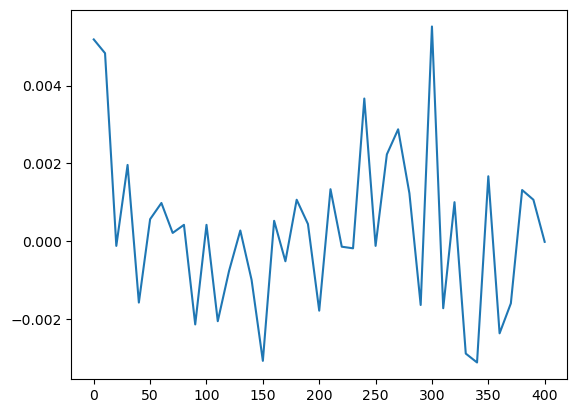

In [180]:
l = 0
j = 0

Ns = 10
tf = 500
tc = 100
L = 7
J = 0.2
cf = 100

# obtain an ensemble and sample
s_ensemble, m_ensemble, all_tau = adaptive_ising_simulator(Ns,tf,tc,L,J,cf=cf,kR=kR,kB=kB,open_boundary=open_boundary)
s_samples, t_grid = ising_sampler(s_ensemble,all_tau,Ns,tf,st)
time_s = t_grid[t_grid >= tc] - tc

if l == 0 and j == 0:
    all_act = np.zeros((Ns,L_arr.size,J_arr.size,time_s.size),dtype='float64')
    mean_act = np.zeros((L_arr.size,J_arr.size,time_s.size),dtype='float64')

# compute autocorrelation
all_act[:,l,j] = 0.5*np.mean(s_samples[:,t_grid>=tc] - np.expand_dims(s_samples[:,int(tc/st)-1],axis=1),axis=(-1,-2))
av_prod = np.mean(all_act[:,l,j].T*np.expand_dims(all_act[:,l,j,0],axis=1).T,axis=1)
prod_av = np.mean(all_act[:,l,j],axis=0)*np.mean(all_act[:,l,j,0])

auto_corr = av_prod-prod_av

plt.plot(time_s,auto_corr)

### Spatial structure

J = 0
J = 0.43
J = 0.6


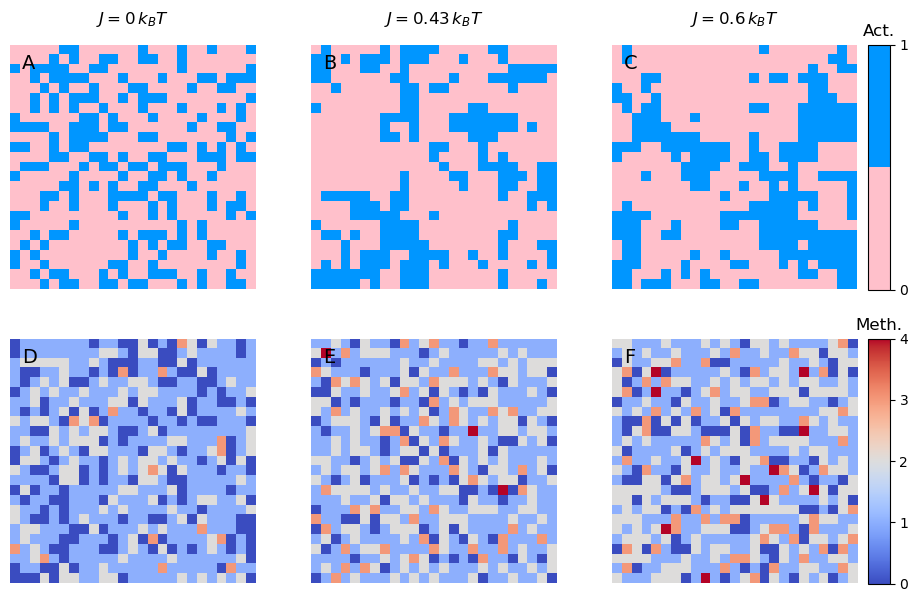

In [85]:
fig_meth_space = plt.figure(figsize=(11,7))

# create subplots
gs = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])

ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
ax6 = plt.subplot(gs[1,2])

# parameters
Ns = 1
tf = 200 # change to 150
tc = tf + 1
kR = 0.005
kB = 2*kR
c0 = 100
cf = 100
L = 25 # change to 20
J_list = [0,0.43,0.6]
open_boundary = True

# for formatting
text_list = ['A','B','C','D','E','F']
cmap = matplotlib.colors.ListedColormap(['#FFC0CB','#0096FF'])

ax_list = [ax1,ax2,ax3,ax4,ax5,ax6]

for j,J in enumerate(J_list):
    print('J =', J)
    # obtain data and show lattice
    s_ensemble, m_ensemble, all_tau = adaptive_ising_simulator(Ns,tf,tc,L,J,cf=cf,kR=kR,kB=kB,open_boundary=open_boundary)
    
    ax_spin = ax_list[j]
    im1 = ax_spin.imshow(0.5 + 0.5*s_ensemble[0][-1],cmap=cmap)
    ax_spin.set_title(f'$J={J} \, k_B T$', y=1.05, size=12)
    ax_spin.text(0.05,0.9,text_list[j],size=14,transform = ax_spin.transAxes)
    ax_spin.set_axis_off()
    
    ax_meth = ax_list[j+3]
    if j == 2:
        im2 = ax_meth.imshow(m_ensemble[0][-1],cmap=colormap,vmin=0.,vmax =4.)
    else:
        ax_meth.imshow(m_ensemble[0][-1],cmap=colormap,vmin=0.,vmax =4.)
    ax_meth.text(0.05,0.9,text_list[j+3],size=14,transform = ax_meth.transAxes)
    ax_meth.set_axis_off()

cax1 = fig_meth_space.add_axes([ax3.get_position().x1+0.01,ax3.get_position().y0,0.02,ax3.get_position().height])
cbar1 = fig_meth_space.colorbar(im1, cax=cax1)
cbar1.ax.set_title('Act.',size=12)
cbar1.set_ticks([0,1])
cbar1.set_ticklabels(['0','1'])

cax2 = fig_meth_space.add_axes([ax6.get_position().x1+0.01,ax6.get_position().y0,0.02,ax6.get_position().height])
cbar2 = fig_meth_space.colorbar(im2, cax=cax2)
cbar2.ax.set_title('Meth.',size=12)
cbar2.set_ticks([0,1,2,3,4])
cbar2.set_ticklabels(['0','1','2','3','4'])

# plt.tight_layout()
plt.margins(x=0,y=0)
plt.show()

In [86]:
fig_meth_space.savefig('Figures/meth_space.pdf')